Run CCC analysis using LIANA+Tensorcell2cell to analyse communication between T cells (except gd) and DCs in the ABC and DT_ABC contexts. In this version, we add Macrophages and monocytes to the analysis. 

In [1]:
server = 'mando'
if (server == 'jabba'){
    data_path = '/data3/hratch/norcross_abc/'
    gpu_use = F
}else if (server == 'mando'){
    data_path = '/data/hratch/norcross_abc/'
    gpu_use = T
}

library(reticulate, quietly = T)
if (gpu_use){
    device<-'cuda:0'
    tensorly <- reticulate::import('tensorly')
    tensorly$set_backend('pytorch')
}else{
    device<-NULL
}

n.cores<-30
env_name = 'norcross_abc'

In [2]:
suppressPackageStartupMessages({
    suppressWarnings({
        library(liana, quietly = T)
        library(decoupleR, quietly = T)

        library(Seurat, quietly = T)
        
        library(ggplot2, quietly = T)
        library(circlize, quietly = T)
        library(RColorBrewer, quietly = T)
        library(ggExtra, quietly = T)
        
        # library(textshape, quietly = T)
        c2c <- reticulate::import(module = "cell2cell", as="c2c")
        
        library(dplyr, quietly = T)
        library(tidyr, quietly = T)
        library(magrittr, quietly = T)
        library(tibble, quietly = T)
        library(reshape2, quietly = T)
        library(stringr)
        library(plyr, quietly = T)
        library(textshape, quietly = T)
    })
})

Set the pipeline parameters (things we can potentially adjust to get different outputs):

In [3]:
params<-list(return_all = FALSE, #whether to return all LRs in liana after filtering for expr_prop
             filter_specificity = FALSE, # whether to filter scores by specificty
             filter_thresh = 0.05, # specificity filter threshold
             filter_specificity_how = 'fill', # or exclude -- fill insignifanct interactions with min or remove alltogether
             lr_fill_by = NaN, # or 0 or NaN -- what to use in the lr_fill tc2c argument
             how = 'outer' # what to use in the how tc2c argument
            )

Load the data:

In [4]:
abc.integrated<-readRDS(paste0(data_path, 'processed/abc_annotated.RDS'))

Subset to the cell types and contexts of interest:

In [5]:
cell.types<-c('T-cells', 'cDC_1', 'cDC_2', 'Xcr1+ DC_1', 'Xcr1+ DC_2', 'pDC', 'ncMono', 'Mf')
contexts<-c('ABC', 'DT_ABC')
abc.ccc<-subset(abc.integrated, subset = (Cell.Type.Level1 %in% cell.types) & (Cell.Type.Level2 != 'gd-T') &
                                        (orig.ident %in% contexts))
Idents(abc.ccc)<-'Cell.Type.Level2'

Format to input to LIANA:

In [6]:
# format into sce object
DefaultAssay(abc.ccc)<-'RNA'
abc.ccc@meta.data <-abc.ccc@meta.data %>% droplevels()
abc.ccc.sce<-Seurat::as.SingleCellExperiment(abc.ccc)

In [7]:
# map LIANA consensus resource to mouse
suppressMessages({
    suppressWarnings({
        op_resource <- liana::select_resource("Consensus")[[1]]

        # Generate orthologous resource
        ortholog_resource <- liana::generate_homologs(op_resource = op_resource,
                                               target_organism = 10090) # mouse
    })
})

lr_type<-c('Cell-Cell Contact', 'ECM-Receptor', 'Secreted Signaling', NA)
names(lr_type)<-c('cell_surface_ligand', 'ecm', 'ligand', '')
# lr_cat<-factor(unname(lr_type[ortholog_resource$category_intercell_source]), 
#                                            levels = lr_type)

In [8]:
# lr_type<-c('Cell-Cell Contact', 'ECM-Receptor', 'Secreted Signaling', NA)
# names(lr_type)<-c('cell_surface_ligand', 'ecm', 'ligand', '')
# lr_cat_map<-factor(unname(lr_type[ortholog_resource$category_intercell_source]), 
#                                            levels = lr_type)

# lr.pairs.map<-ortholog_resource %>%
# unite(LR, c('source_genesymbol', 'target_genesymbol'), sep = '^')
# names(lr_cat_map)<-lr.pairs.map[['LR']]

Run liana for each context and calculate the consensus rank score:

In [9]:
# suppressWarnings({
#     abc.ccc.sce<-liana_bysample(sce = abc.ccc.sce, 
#                idents_col = 'Cell.Type.Level2', 
#                sample_col = 'orig.ident',
#                assay.type='logcounts', # log-normalized counts
#                verbose = T, 
#               aggregate_how = 'both', # consensus magnitude AND specifity score
#                 resource = 'custom', 
#                 external_resource = ortholog_resource, # consensus resource in mouse
#                min_cells = 5, # default min cells to be considered
#                expr_prop = 0.05, # expressed in atleast 5% of cells to be scored
#                return_all = params$return_all, # assign a low score to those that don't pass expr_prop
#                 parallelize = TRUE, workers = n.cores,
#               )
# })
# saveRDS(abc.ccc.sce@metadata$liana_res, paste0(data_path, 'interim/', 'v2_liana_bysample.rds'))

abc.ccc.sce@metadata$liana_res<-readRDS(paste0(data_path, 'interim/', 'v2_liana_bysample.rds'))

If filtering for specificity rank, will change # of interactions in the contexts as follows:

In [10]:
sapply(abc.ccc.sce@metadata$liana_res, function(x) dim(x)[[1]])
       
if (params$filter_specificity_how == 'exclude'){
        sapply(abc.ccc.sce@metadata$liana_res, function(x) dim(x[x$specificity_rank <= params$filter_thresh, ])[[1]])
    }else if (params$filter_specificity_how == 'fill'){
        sapply(abc.ccc.sce@metadata$liana_res, function(x) dim(x[x$specificity_rank > params$filter_thresh, ])[[1]])
    }


ABC DT_ABC 
 56311  49054

ABC DT_ABC 
 45137  40384

In [11]:
if (params$filter_specificity){
    liana_res<-list()
    for (sample.name in names(abc.ccc.sce@metadata$liana_res)){
        x<-abc.ccc.sce@metadata$liana_res[[sample.name]]
        if (params$filter_specificity_how == 'exclude'){
            x<-x[x$specificity_rank <= params$filter_thresh, ] # eliminate those under threshold
        }else if (params$filter_specificity_how == 'fill'){
            x[x$specificity_rank > params$filter_thresh, 'magnitude_rank']<-max(x$magnitude_rank) # replace with "lowest" value (max because magnitude rank orders lower values as higher importance)
        }
        abc.ccc.sce@metadata$liana_res[[sample.name]]<-x
    }
}

Run Tensor-cell2cell

In [12]:
abc.ccc.sce@metadata$liana_res<-liana:::preprocess_scores(context_df_dict = abc.ccc.sce@metadata$liana_res, 
                                 score_col = 'magnitude_rank', # score to preprocess
                                  outer_fraction = 1/3, # only keep cells/LRs present in atleast in 1/3 of contexts
                                                        # outer_fract shouldn't change things since there are only 3 samples
                                  invert = TRUE, # since magnitude has lower scores being more valuable
                                  invert_fun = function(x) 1-x, 
                                  non_negative = TRUE, # shouldn't effect things since all magnitude ranks are positive
                                  non_negative_fill = 0, 
                                  verbose = T
                                 )

Inverting `magnitude_rank`!

Inverting `magnitude_rank`!



In [13]:
score_col = 'magnitude_rank'

if (params$lr_fill_by == 'min'){
    lr.fill.value<-min(sapply(abc.ccc.sce@metadata$liana_res, function(x) min(x[[score_col]])))
}else if (is.numeric(params$lr_fill_by)){
    lr.fill.value<-params$lr_fill_by
}
lr.fill.value

[1] NaN

In [14]:
# # build tensor
# tensor <- liana::liana_tensor_c2c(sce = abc.ccc.sce,
#                                   context_df_dict = NULL, 
#                                   score_col = 'magnitude_rank', 
#                                   how = params$how, 
#                                   lr_fill = lr.fill.value,
#                                   cell_fill = 0, 
#                                   context_order = levels(abc.ccc.sce@colData$orig.ident), 
#                                   sort_elements = TRUE, 
#                                   conda_env = env_name, 
#                                   build_only = TRUE, 
#                                   device = device)

# # decompose tensor
# tensor<-liana::decompose_tensor(tensor = tensor, 
#                          rank = NULL, 
#                          tf_optimization = 'regular', # CHANGE TO ROBUST
#                          elbow_metric = 'error', # Metric to use in the elbow analysis.
#                          smooth_elbow = FALSE, # Whether smoothing the metric of the elbow analysis.
#                          upper_rank=25, # Max number of factors to try in the elbow analysis
#                          init = 'svd', # Initialization method of the tensor factorization
#                          factors_only = FALSE, 
#                         )
# reticulate::py_save_object(object = tensor, 
#                            filename = paste0(paste0(data_path, 'processed/', 'v2_ccc_tensor.pkl')))

tensor<-reticulate::py_load_object(paste0(paste0(data_path, 'processed/', 'v2_ccc_tensor.pkl')))

In [15]:
tensor$rank

[1] 9

# Downstream Analysis

In [16]:
write.csv(tensor$factors$interactions, 
          paste0(data_path, 'interim/', 'v2_lr_loadings.csv'))

In [16]:
# basic formatting
factors<-liana:::format_c2c_factors(tensor$factors)

# ordering categories
f.c<-factors$contexts
f.c[['context']]<-factor(f.c$context, levels(abc.ccc.sce@colData$orig.ident))
factors[['contexts']]<-f.c
for (ct in c('senders', 'receivers')){
    f.ct<-factors[[ct]]
    f.ct[['celltype']]<-factor(f.ct$celltype, levels(abc.ccc.sce@colData$Cell.Type.Level2))
    factors[[ct]]<-f.ct
}
abc.ccc.sce@metadata$tensor_res<-factors

abc.ccc.sce@colData[['group']] = abc.ccc.sce@colData[['orig.ident']] # must have a "group" for plotting

In [37]:
error_average <- tensor$elbow_metric_raw %>%
    t() %>%
    as.data.frame() %>%
    dplyr::mutate(rank=dplyr::row_number())

[1] "The identified tensor rank is 9"


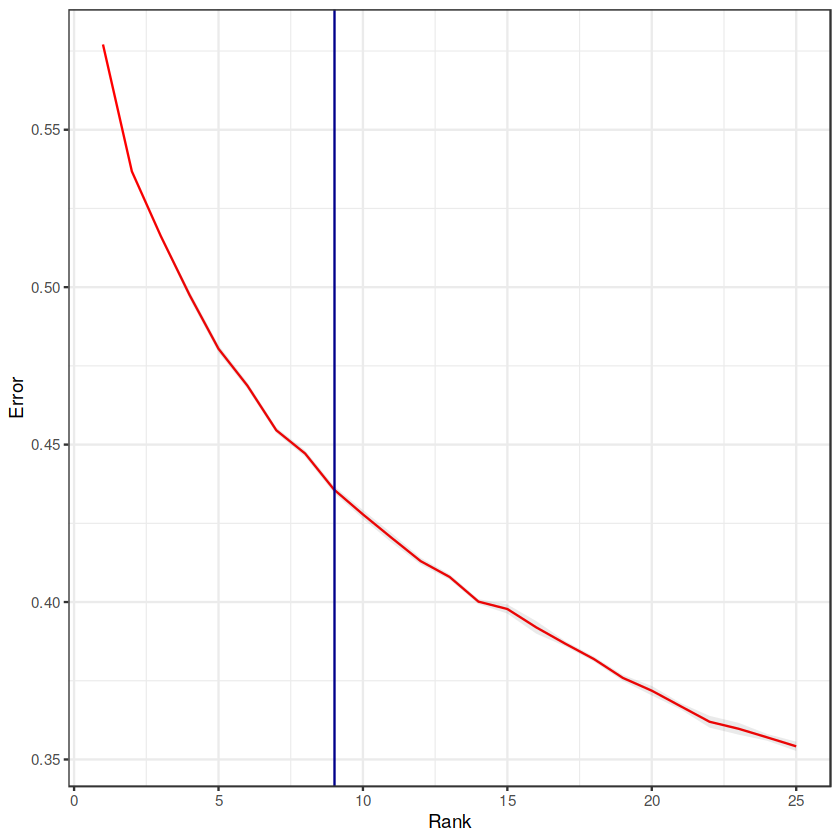

In [38]:
print(paste0('The identified tensor rank is ', tensor$rank))

# Estimate standard error
error_average <- tensor$elbow_metric_raw %>%
    t() %>%
    as.data.frame() %>%
    dplyr::mutate(rank=dplyr::row_number()) %>% 
    pivot_longer(-rank, names_to = "run_no", values_to = "error") %>%
    dplyr::group_by(rank) %>%
    dplyr::summarize(average = mean(error),
              N = n(),
              SE.low = average - (sd(error)/sqrt(N)),
              SE.high = average + (sd(error)/sqrt(N))
           )

# plot
error_average %>%
    ggplot(aes(x=rank, y=average), group=1) +
    geom_line(col='red') + 
    geom_ribbon(aes(ymin = SE.low, ymax = SE.high), alpha = 0.1) +
    geom_vline(xintercept = tensor$rank, colour='darkblue') + # rank of interest
    theme_bw() +
    labs(y="Error", x="Rank")

In [45]:
# addapt from liana
plot_c2c_overview <- function(sce, group_col, sample_col, lr_cat_map=NULL, factors.of.interest=NULL){

    factors <- get_c2c_factors(sce, group_col, sample_col)
    if (is.null(factors.of.interest)){
        factors.of.interest<-names(which(sapply(names(factors$contexts), function(x) startsWith(x, 'Factor.'))))
    }

    # Contexts
    contexts <- factors$contexts %>%
        pivot_longer(cols = -c("context", group_col),
                     names_to = "factor", values_to = "loadings"
        ) %>%
        filter(factor %in% factors.of.interest) %>%
        ggplot(aes(x=context, y=loadings, fill=.data[[group_col]])) +
        geom_bar(stat="identity") +
        facet_grid(factor ~ .) +
        theme_bw(base_size = 14) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank(),
              strip.text.y = element_blank(),
              plot.title = element_text(hjust = 0.5)) +
        ggtitle('Contexts') +
        ylab(NULL)

    # lr
    lr = factors$interactions %>%
        pivot_longer(-lr, names_to = "factor", values_to = "loadings") %>%
        filter(factor %in% factors.of.interest)
                                                
    if (!(is.null(lr_cat_map))){
        lr[['lr.cat']]<-unname(lr_cat_map[lr$lr])
    
        lr = lr %>%
            ggplot(aes(x=lr, y=loadings, fill = lr.cat)) +
            geom_bar(stat="identity") +
            facet_grid(factor ~ ., scales = "free_y") +
            theme_bw(base_size = 14) +
            theme(axis.title.x=element_blank(),
                  axis.text.x=element_blank(),
                  axis.ticks.x=element_blank(),
                  strip.background = element_blank(),
                  strip.text.y = element_blank(),
                  plot.title = element_text(hjust = 0.5)) +
            ggtitle('Interactions') +
            ylab(NULL)
    }else{
        lr = lr %>%
            ggplot(aes(x=lr, y=loadings)) +
            geom_bar(stat="identity") +
            facet_grid(factor ~ ., scales = "free_y") +
            theme_bw(base_size = 14) +
            theme(axis.title.x=element_blank(),
                  axis.text.x=element_blank(),
                  axis.ticks.x=element_blank(),
                  strip.background = element_blank(),
                  strip.text.y = element_blank(),
                  plot.title = element_text(hjust = 0.5)) +
            ggtitle('Interactions') +
            ylab(NULL)
    }                                        


    # Sender cells
    senders <- factors$senders %>%
        pivot_longer(cols = -celltype,
                     names_to = "factor", values_to = "loadings"
        ) %>%
        filter(factor %in% factors.of.interest) %>%
        ggplot(aes(x=celltype, y=loadings,
                   fill=celltype)) +
        geom_bar(stat="identity") +
        facet_grid(factor ~ .) +
        theme_bw(base_size = 14) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank(),
              strip.background = element_blank(),
              strip.text.y = element_blank(),
              plot.title = element_text(hjust = 0.5)) +
        ylab(NULL) +
        ggtitle('Senders')

    # Receiver cells
    receivers <- factors$receivers %>%
        pivot_longer(cols = -celltype,
                     names_to = "factor", values_to = "loadings"
        ) %>%
        filter(factor %in% factors.of.interest) %>%
        ggplot(aes(x=celltype, y=loadings,
                   fill=celltype)) +
        geom_bar(stat="identity") +
        facet_grid(factor ~ .) +
        theme_bw(base_size = 14) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              strip.background = element_blank(),
              axis.ticks.x=element_blank(),
              strip.text.y = element_text(size=15, face = "bold"),
              plot.title = element_text(hjust = 0.5)) +
        ylab(NULL) +
        ggtitle('Receivers')

    # Assemble overview plot
    overview <- patchwork::wrap_plots(list(contexts,
                                           lr,
                                           senders,
                                           receivers
    ),
    ncol=4,
    nrow(1)) +
        patchwork::plot_layout(guides = "collect")

    grid::grid.draw(overview)
}

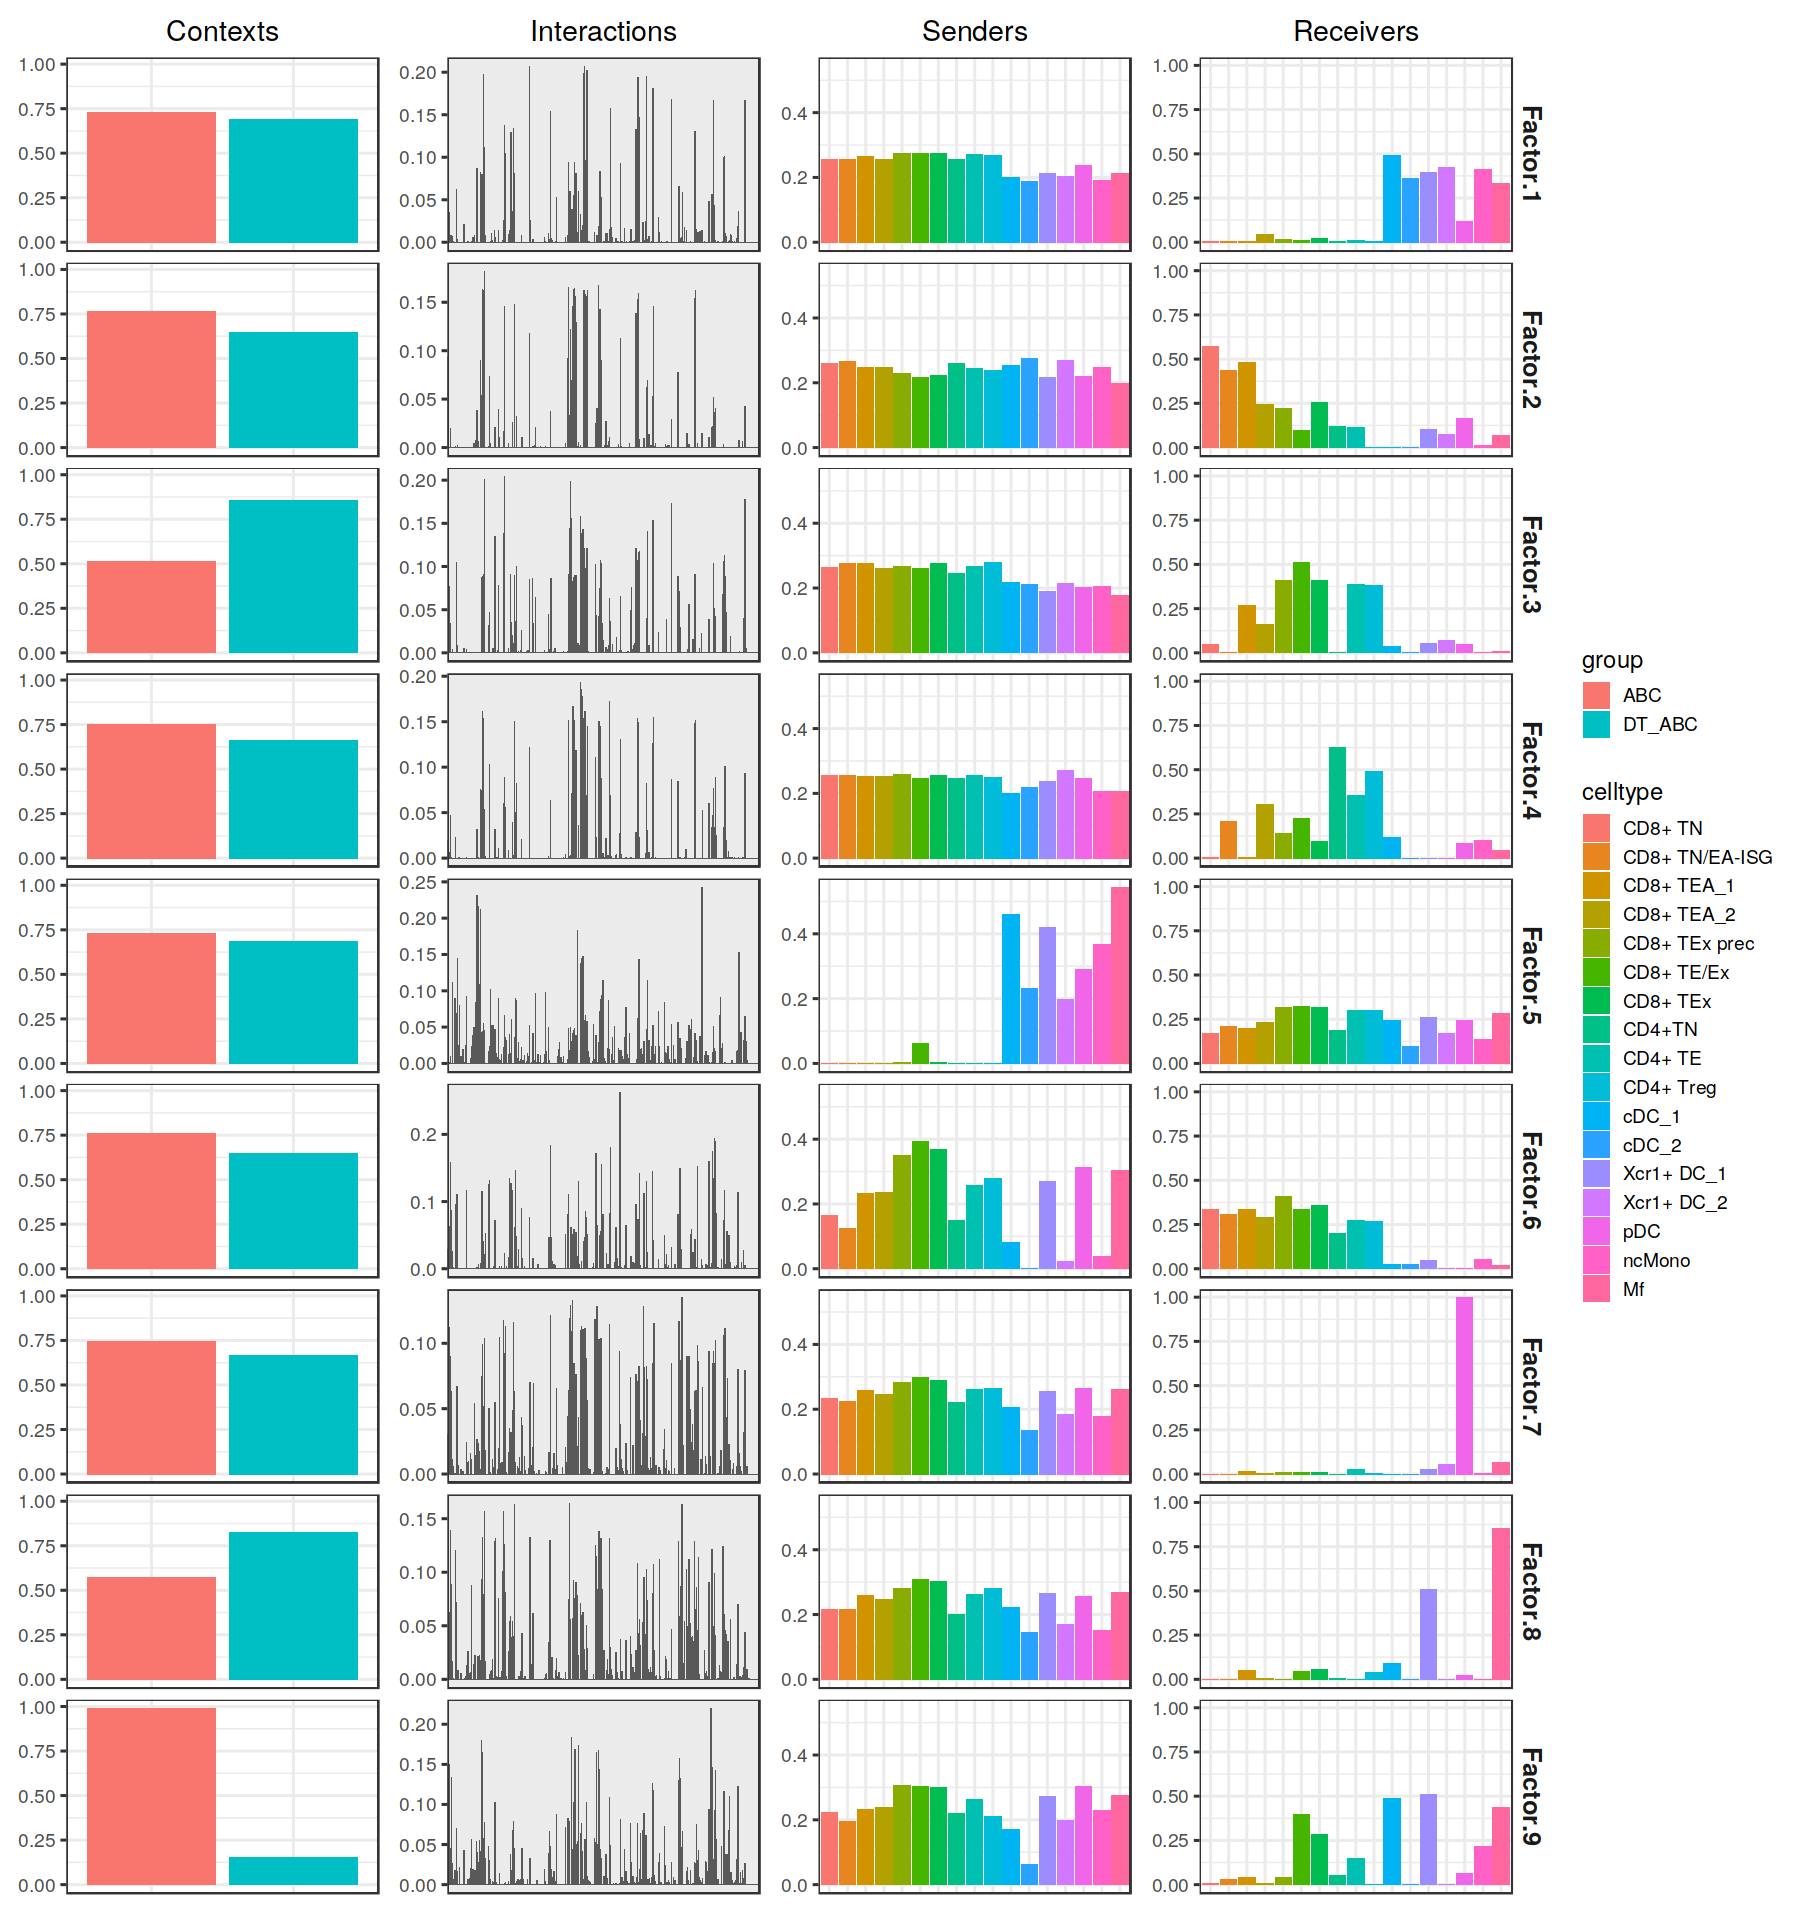

In [46]:
h_ = 16
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

plot_c2c_overview(sce = abc.ccc.sce, group_col = 'group', sample_col = 'orig.ident', 
                 lr_cat_map = NULL)

Context-specific factors are: Factors 3, 8 and 9

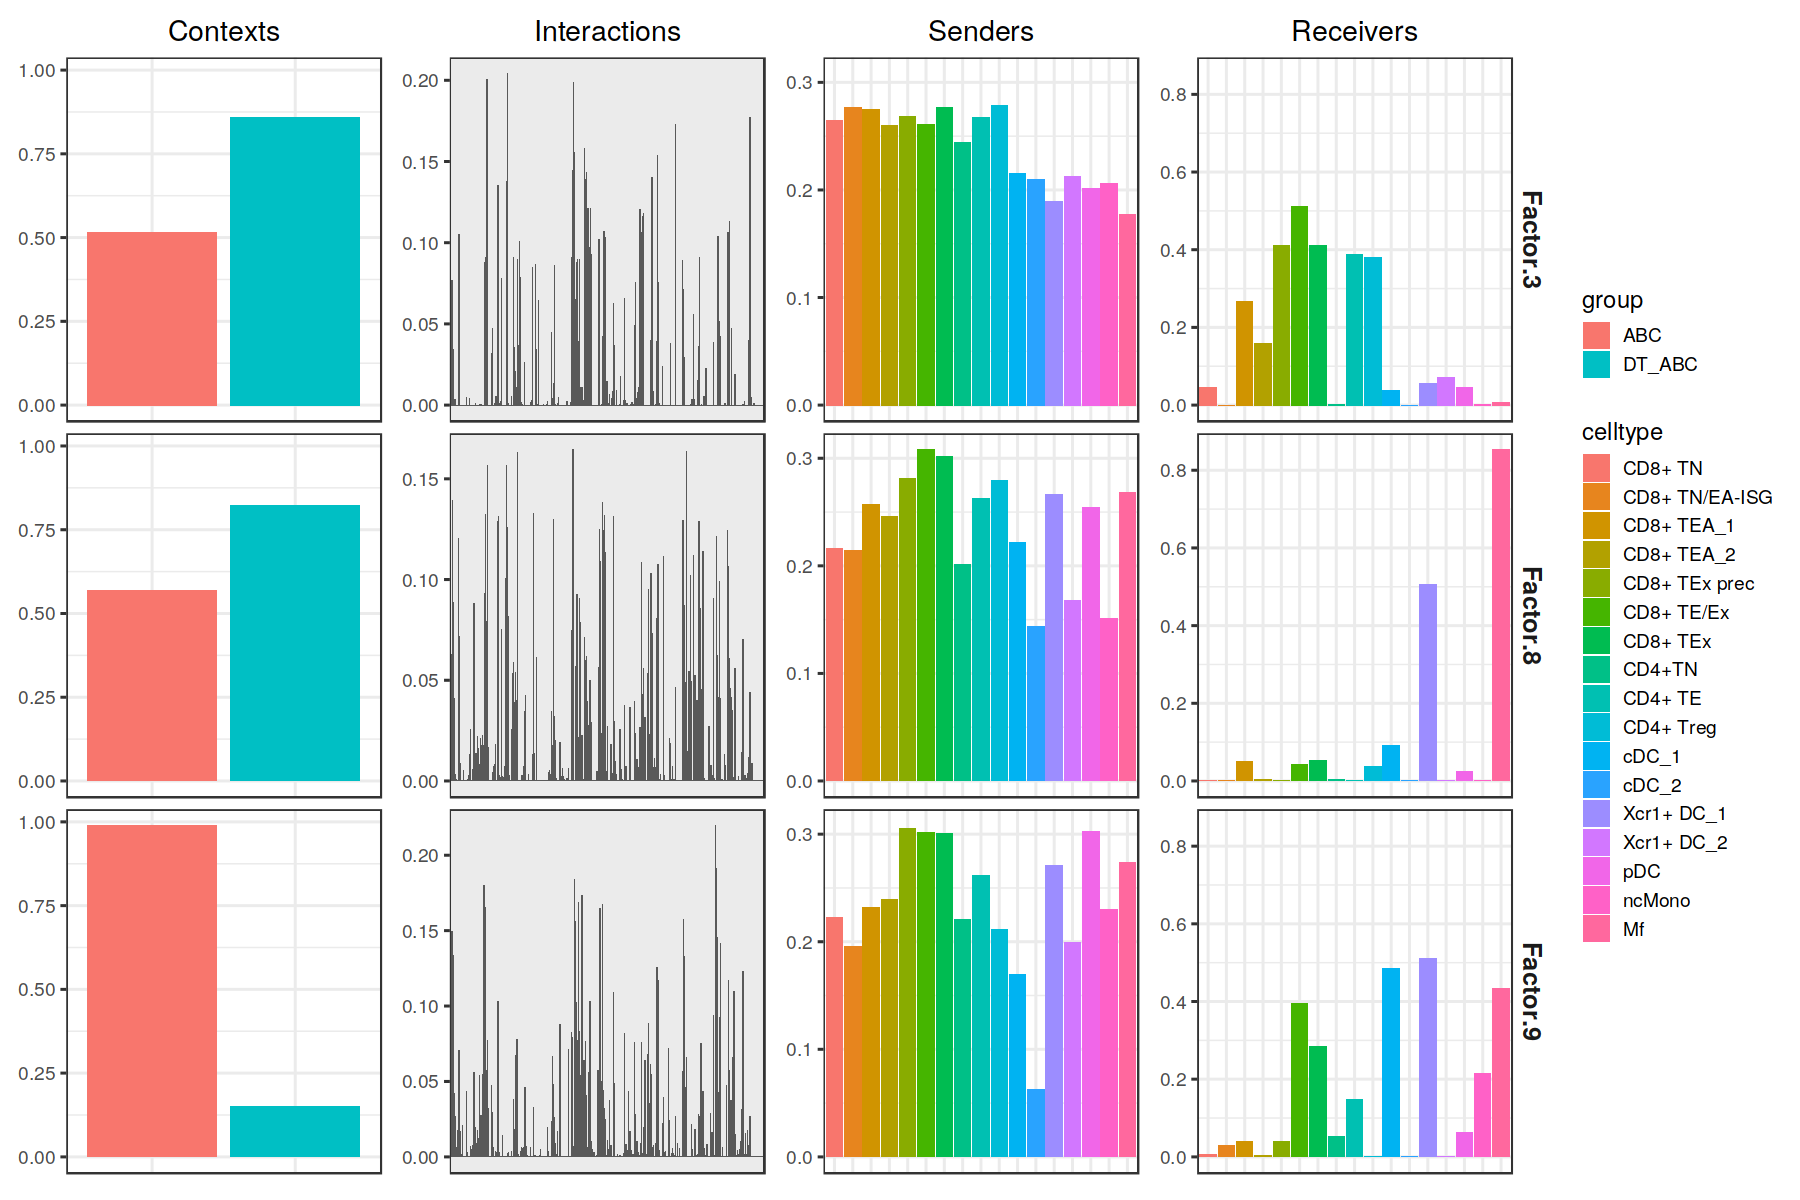

In [48]:
h_ = 10
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)
fos<-c('3', '8', '9')
plot_c2c_overview(sce = abc.ccc.sce, group_col = 'group', sample_col = 'orig.ident', 
                 factors.of.interest = paste0('Factor.', fos), 
                  lr_cat_map = NULL
                 )

In [21]:
calculate_gini(factors$senders) %>% arrange(gini)

factor   gini      
1 Factor.4 0.04662789
2 Factor.2 0.05245001
3 Factor.1 0.07457592
4 Factor.3 0.08376764
5 Factor.7 0.10152487
6 Factor.8 0.12061640
7 Factor.9 0.14044531
8 Factor.6 0.34656555
9 Factor.5 0.68959615

In [22]:
calculate_gini(factors$receivers) %>% arrange(gini)

factor   gini     
1 Factor.5 0.1723785
2 Factor.6 0.4520889
3 Factor.2 0.5527723
4 Factor.4 0.6069823
5 Factor.3 0.6185852
6 Factor.9 0.6444110
7 Factor.1 0.6505925
8 Factor.8 0.8695110
9 Factor.7 0.9298938

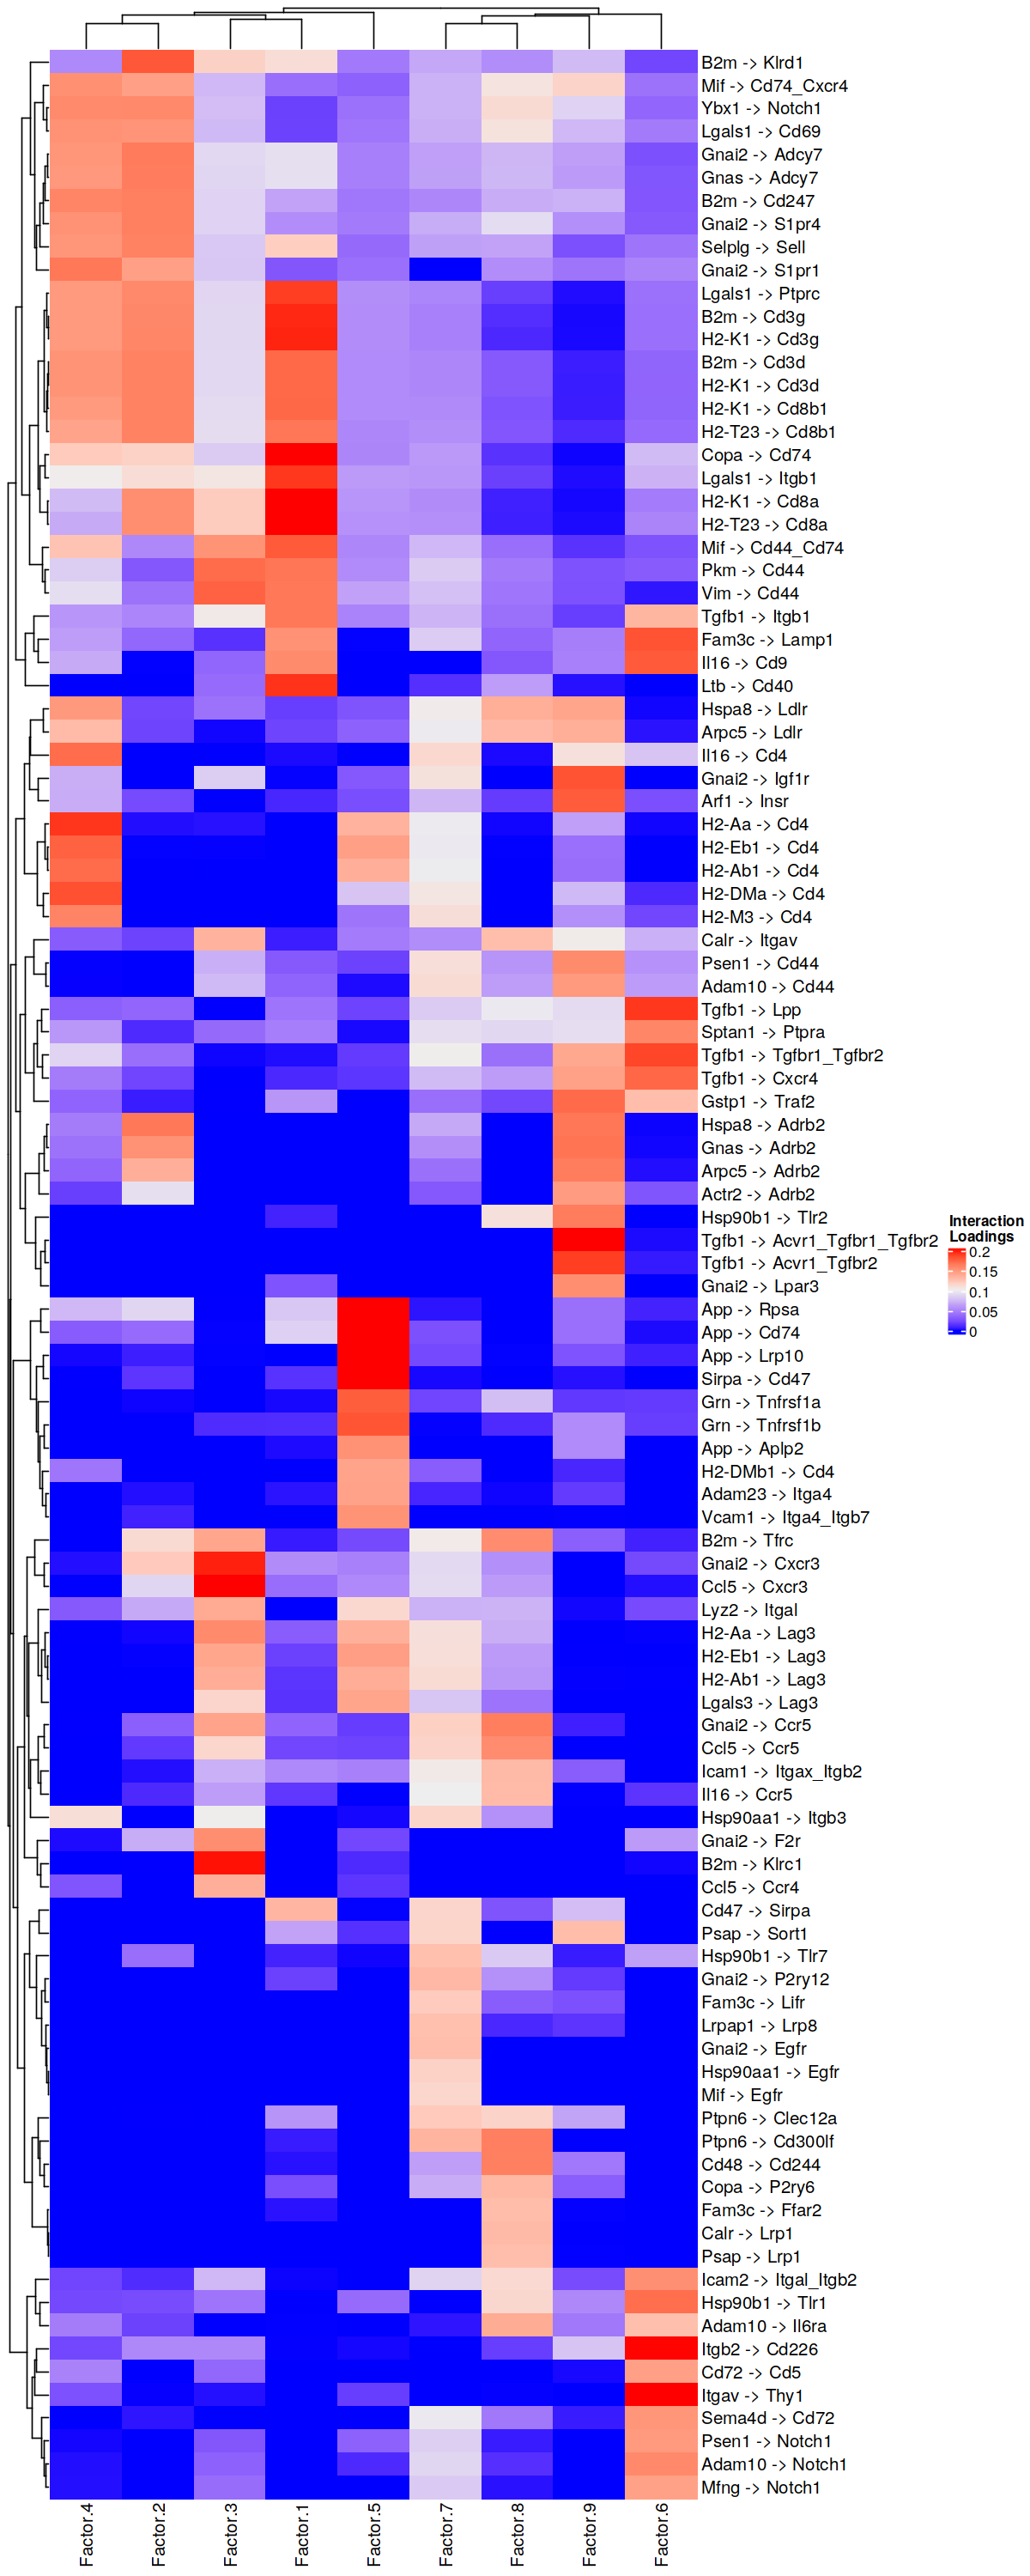

In [23]:
h_ = 25
w_ = 10
n_lrs<-15#5
options(repr.plot.height=h_, repr.plot.width=w_)
liana::plot_lr_heatmap(sce = abc.ccc.sce,  n = n_lrs)

In [24]:
top_lrs = list()
for (factor.name in paste0('Factor ', fos)){
    top_lrs[[factor.name]] = tensor$get_top_factor_elements(order_name='interactions', 
                                factor_name=factor.name, 
                                top_number=as.integer(n_lrs))
}
top_lrs


$`Factor 3`
   Ccl5^Cxcr3     B2m^Klrc1   Gnai2^Cxcr3      Vim^Cd44      Pkm^Cd44 
    0.2039229     0.2007087     0.1986094     0.1773518     0.1728444 
   H2-Aa^Lag3     Gnai2^F2r Mif^Cd44_Cd74    Gnai2^Ccr5   H2-Eb1^Lag3 
    0.1580753     0.1556377     0.1534079     0.1443791     0.1430090 
     B2m^Tfrc    Lyz2^Itgal   H2-Ab1^Lag3     Ccl5^Ccr4    Calr^Itgav 
    0.1428045     0.1404022     0.1387644     0.1377606     0.1353085 

$`Factor 8`
       Gnai2^Ccr5     Ptpn6^Cd300lf        Cd48^Cd244         Ccl5^Ccr5 
        0.1643898         0.1635698         0.1630565         0.1567327 
         B2m^Tfrc      Adam10^Il6ra        Hspa8^Ldlr        Copa^P2ry6 
        0.1567075         0.1393621         0.1382811         0.1325416 
       Arpc5^Ldlr Icam1^Itgax_Itgb2         Calr^Lrp1         Il16^Ccr5 
        0.1324826         0.1316305         0.1315347         0.1311606 
      Fam3c^Ffar2         Psap^Lrp1        Calr^Itgav 
        0.1299237         0.1291485         0.1290568 

$`Factor 9`
Tgfb1^Acvr1_Tgfbr1_Tgfbr2        Tgfb1^Acvr1_Tgfbr2               Gnai2^Igf1r 
                0.2195659                 0.1913889                 0.1836727 
                Arf1^Insr               Gstp1^Traf2                Gnas^Adrb2 
                0.1800842                 0.1735837                 0.1687490 
              Hspa8^Adrb2               Arpc5^Adrb2              Hsp90b1^Tlr2 
                0.1674912                 0.1651395                 0.1648572 
               Psen1^Cd44               Gnai2^Lpar3               Adam10^Cd44 
                0.1575894                 0.1557857                 0.1493177 
              Actr2^Adrb2               Tgfb1^Cxcr4                Hspa8^Ldlr 
                0.1489623                 0.1455712                 0.1431935

For each factor of interest, let's look at how the senders are interacting with teh receivers in more detail:

In [25]:
cc_plots<-list()
for (selected_factor in paste0('Factor.', fos)){
    cc_plots[[selected_factor]]<-liana::plot_c2c_cells(sce = abc.ccc.sce,
                                   factor_of_int = selected_factor,
                                    name = paste0(selected_factor, '\n', 
                                                 "Loadings Product"))    
}

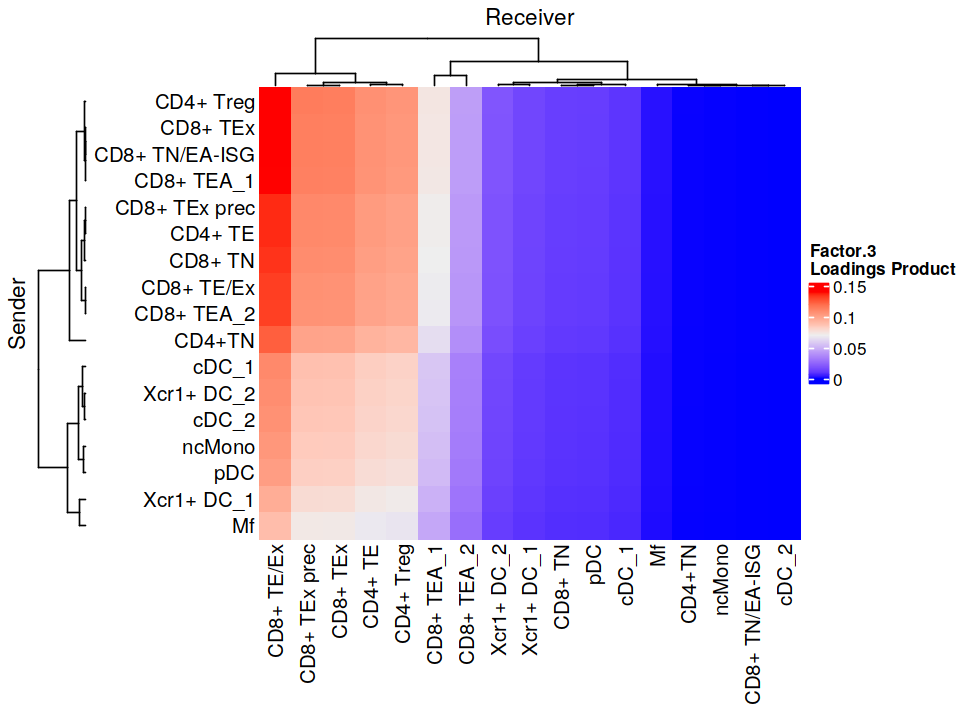

In [26]:
h_ = 6
w_ = 8
options(repr.plot.height=h_, repr.plot.width=w_)
i<-1
cc_plots[[i]]
i<-i+1

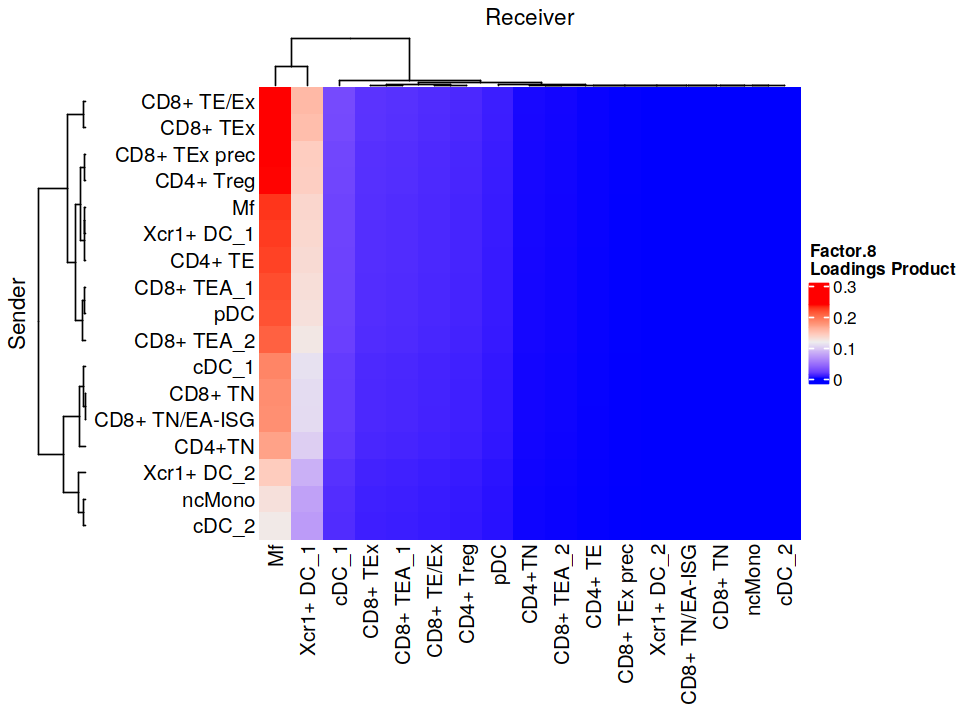

In [27]:
cc_plots[[i]]
i<-i+1

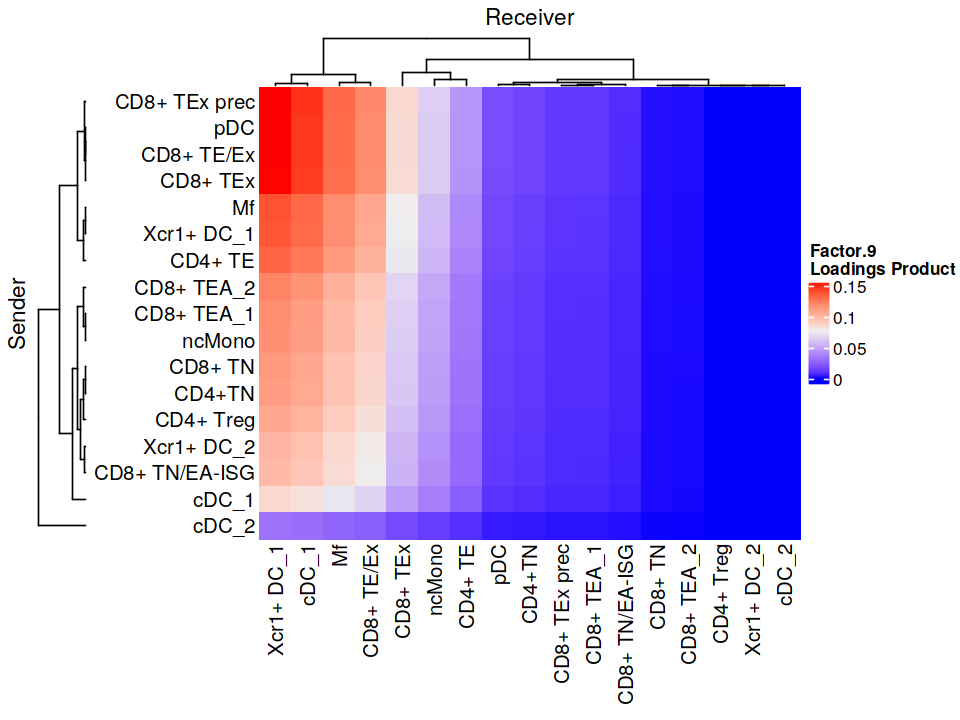

In [28]:
cc_plots[[i]]
i<-i+1

Let's take a look at the relationship between cell-cell and ligand receptor interactions:

In [29]:
get_joint_loadings<-function(tensor, selected_factor, dim1 = 'senders', dim2 = 'receivers'){
    
    v1<-tensor$factors[[dim1]][[selected_factor]]
    names(v1)<-rownames(tensor$factors[[dim1]])

    v2<-tensor$factors[[dim2]][[selected_factor]]
    names(v2)<-rownames(tensor$factors[[dim2]])
    
    return(outer(v1, v2, "*"))
}

get_lr_by_cell_pairs<-function(tensor, selected_factor, n_cci = NULL, n_lrs = NULL){
    sr<-get_joint_loadings(tensor, selected_factor, dim1 = 'senders', dim2 = 'receivers')
    
    # flatten
    sr<-as.vector(sr)
    element.names<-expand.grid(rownames(tensor$factors$senders), rownames(tensor$factors$receivers))
    element.names<-paste0(element.names[[1]], '->', element.names[[2]])
    names(sr)<-element.names
    
    if (!is.null(n_cci)){
#         sr<-sr[sr > cci_threshold]
        sr<-sort(sr, decreasing = T)[1:n_cci]
    }
    
    # get outer with lr
    v2<-tensor$factors$interactions[[selected_factor]]
    names(v2)<-rownames(tensor$factors$interactions) 
    if (!is.null(n_lrs)){
        v2<-sort(v2, decreasing = T)[1:n_lrs]
    }

    mat<-outer(sr, v2, "*")
    
    return(t(mat))
}

In [30]:
lr_cc_list<-list()
for (selected_factor in paste0('Factor ', fos)){
    mat<-get_lr_by_cell_pairs(tensor, selected_factor, n_cci = 30, n_lrs = 30)
    write.csv(mat, paste0(data_path, 'interim/', 'Factor', selected_factor, '_lr_by_cell.csv'))
    lr_cc_list[[selected_factor]]<-ComplexHeatmap::Heatmap(mat, 
                                                   name = paste0(selected_factor), 
                                                   column_title = "lr", row_title = 'cci')
}

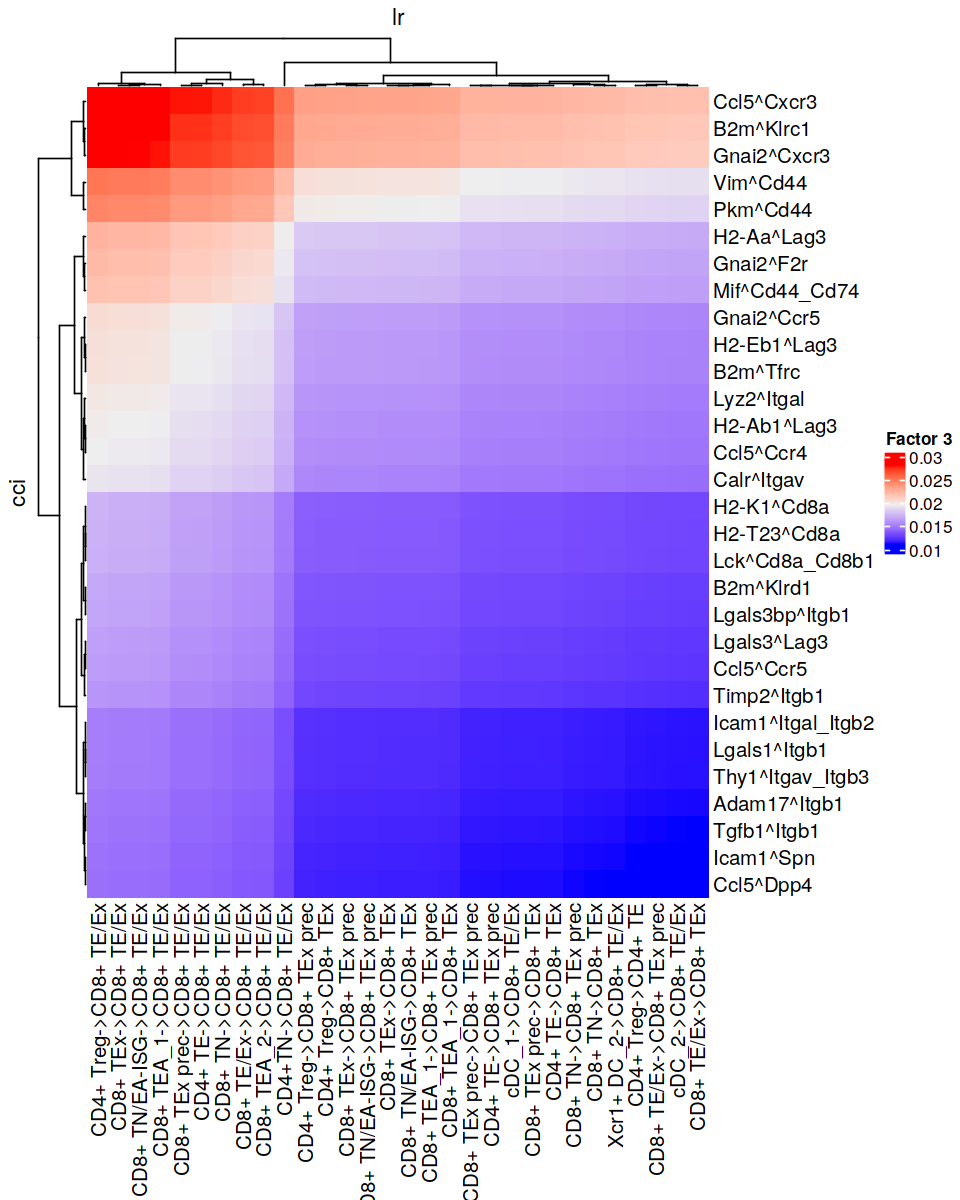

In [31]:
h_ = 10
w_ = 8
options(repr.plot.height=h_, repr.plot.width=w_)

i<-1
lr_cc_list[[i]]

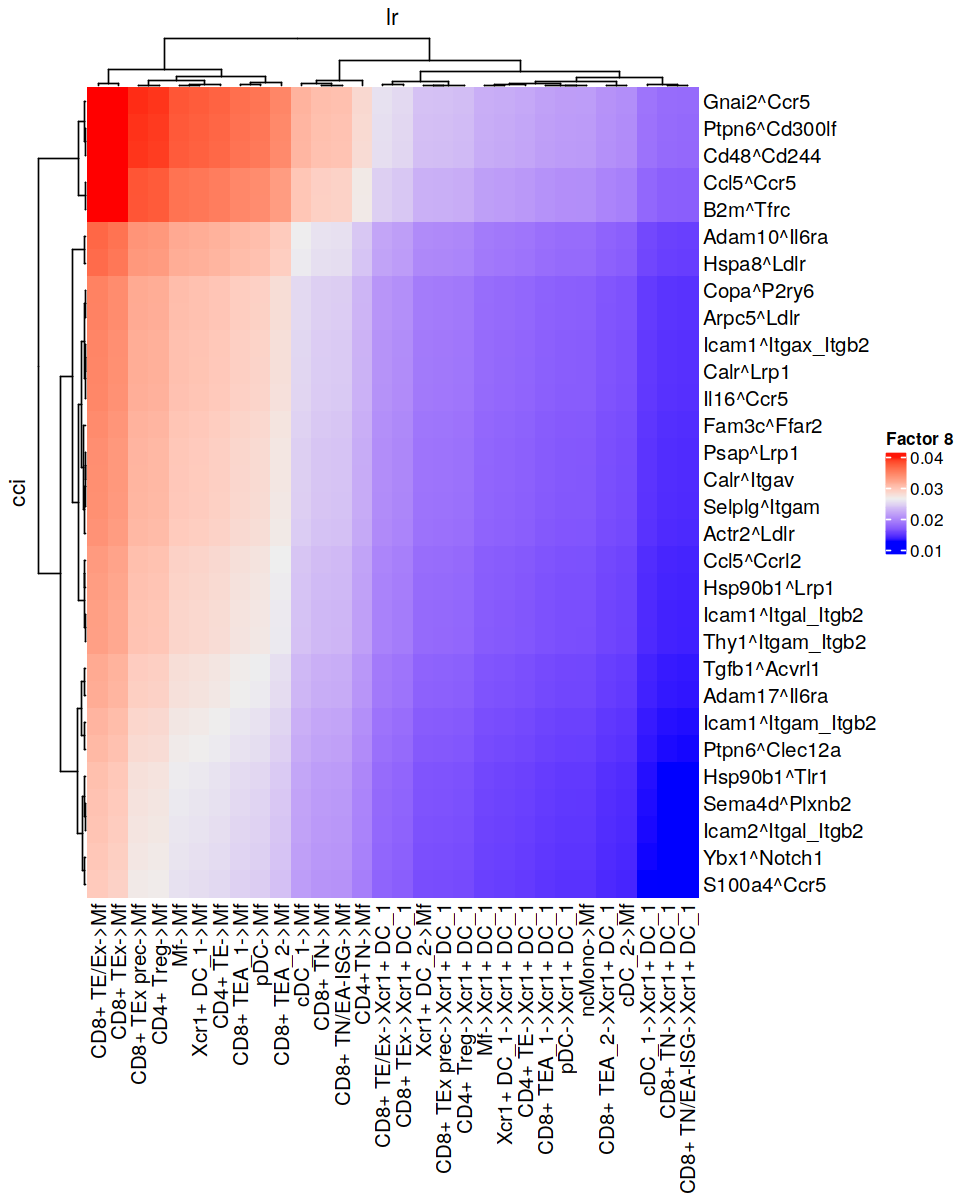

In [32]:
i<-i+1
lr_cc_list[[i]]

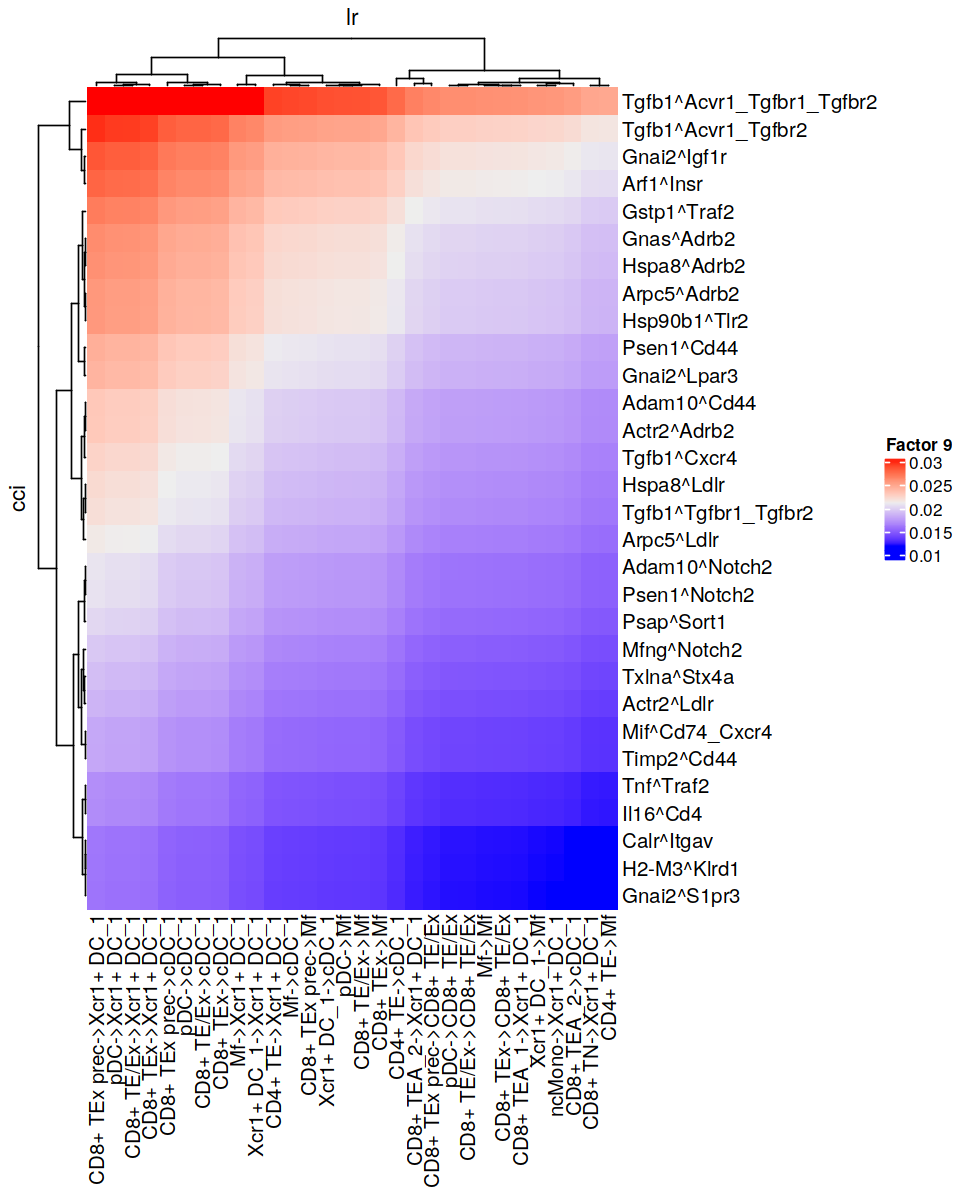

In [33]:
i<-i+1
lr_cc_list[[i]]

<span style="color:red">**Enrichment analysis must be refined a lot once specific factors are decided**

Finally, let's do an enrichment of the LRs for each of the context-specific Factors:

In [581]:
organism = 'mouse' 
pathwaydb = 'GOBP' # KEGG# can't use KEGG with mouse, may want to map ortholog

# lr_pairs <- liana::select_resource('Consensus')
# lr_pairs <- lr_pairs$Consensus[c('source_genesymbol', 'target_genesymbol')]
lr_pairs <- ortholog_resource[c('source_genesymbol', 'target_genesymbol')]
names(lr_pairs) <- c('ligand', 'receptor')
lr_list <- apply(lr_pairs, 1, function(x) paste0(x[[1]], '^', x[[2]]))
                 
lr_set <- c2c$external$generate_lr_geneset(lr_list = lr_list, 
                        complex_sep='_', # Separation symbol of the genes in the protein complex
                          lr_sep='^', # Separation symbol between a ligand and a receptor complex
                          organism=organism,
                          pathwaydb=pathwaydb,
                          readable_name=TRUE)    
lr_loadings = factors[['interactions']] %>% 
                column_to_rownames("lr")

In [35]:
gsea_res <- c2c$external$run_gsea(loadings=lr_loadings, 
                               lr_set=lr_set,
                               output_folder=paste0(data_path, 'interim/')
                              )
names(gsea_res)<-c('pvals', 'scores', 'gsea_df')

In [36]:
gsea.dotplot<-function(pval_df, score_df, significance = 0.05, font_size = 15){
    pval_df <- pval_df[apply(pval_df<significance,1,any), apply(pval_df<significance, 2, any)] %>% 
            mutate_all(function(x) -1*log10(x + 1e-9))
    score_df <- score_df[rownames(pval_df), colnames(pval_df)]
    pval_df <- pval_df %>%
                    tibble::rownames_to_column('Annotation')
    score_df <- score_df %>%
                    tibble::rownames_to_column('Annotation')

    viz_df <- cbind(melt(pval_df), melt(score_df)[[3]])
    names(viz_df) <- c('Annotation', 'Factor', 'Significance', 'NES')
    
                       
    dotplot <- ggplot(viz_df, aes(x = Factor, y = Annotation)) + geom_point(aes(size = Significance, color = NES)) + 
                scale_color_gradient2() + theme_bw(base_size = font_size) + 
                theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5))+
                       scale_size(range = c(0, 8)) + 
                       guides(size=guide_legend(title="-log10(p-value)"))
    return(dotplot)
}

No significant hits...

In [38]:
min(min(gsea_res$pvals))

[1] 0.1050651

In [40]:
h_ = 8
w_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)

dotplot <- gsea.dotplot(pval_df = gsea_res$pvals, 
                       score_df = gsea_res$scores, 
                       significance = 0.05)
dotplot

## ORA 

<font color='red'>**Running through metascape may introduce biases (since converting from LR --> gene list doesn't account for repeating receptors (e.g., L1-R1, L2-R1, L3-R1). It is better to convert gene pathway databases to LRs as done by c2c.external.generate_lr_geneset. Thus, will run ORA using clusterProfiler on the output of that function AND will conver the lr inputs for metascape.**</font> 


### ORA Clusterprofiler

ORA using clusterprofiler, with pathways mapped to LR pairs rather than genes as in c2c.external.generate_lr_geneset:

In [582]:
# p.adjust = BH corrected -- # https://github.com/YuLab-SMU/clusterProfiler/issues/124
# GeneRatio -- ratio of input genes in specific pathway vs input genes in all pathways https://www.biostars.org/p/220465/

# can improve visualization by directly manipulating the @result of each output
# if doing this, change qvalueCutoff to 1 and directly filter

visualize_ora<-function(cp.out, factor.name, sig.thresh = 0.1, top_n_terms = 10){
    viz.df<-cp.out@result
    viz.df[['significant']]<-paste0('fdr > ', sig.thresh)
    viz.df[viz.df$p.adjust <= sig.thresh, 'significant']<-paste0('fdr', ' \u2264 ',  sig.thresh)

    viz.df[['significant']]<-factor(viz.df[['significant']], 
                                    levels = c(paste0('fdr', ' \u2264 ',  sig.thresh), paste0('fdr > ', sig.thresh)))
    viz.df[['log.fdr']]<- -log10(viz.df$p.adjust)
    viz.df[['GeneRatio2']]<-unlist(unname(sapply(viz.df$GeneRatio, function(x) eval(parse(text=x)))))

    viz.df<-viz.df[with(viz.df, order(significant, -GeneRatio2, -log.fdr, -Count)), ]

    viz.df<-viz.df[1:top_n_terms, ]
    viz.df[['ID']]<-factor(viz.df[['ID']], 
                                    levels = rev(viz.df[['ID']]))

    green_hex = brewer.pal(n = 11, name ='RdYlGn')[[11]]
    yellow_hex = brewer.pal(n = 11, name = 'RdYlGn')[[6]]
    red_hex = brewer.pal(n = 11, name = 'RdYlGn')[[1]]

    lower_q = min(viz.df$log.fdr[!(is.na(viz.df$log.fdr))])
    upper_q = max(viz.df$log.fdr[!(is.na(viz.df$log.fdr))])
    middle_q = mean(c(lower_q, upper_q))#median(viz.df$log.fdr[!(is.na(viz.df$log.fdr))]) 
    # middle_q = 7.5

    g<-ggplot(data = viz.df, aes(x = GeneRatio2, y = ID, color = log.fdr, size = Count, shape = significant)) + 
    geom_point() + 
    ylab('') + xlab('GeneRatio') + ggtitle(factor.name) +
#     scale_color_gradient2(low = green_hex, mid = yellow_hex, high = red_hex, name = '-log10(fdr)', 
#                          limits = c(lower_q, upper_q), midpoint = middle_q) + 
    scale_colour_gradientn(colours = rev(c("darkred", "orange", "yellow")), name = '-log10(fdr)')+
    scale_shape_manual(values = c(16,4), drop = FALSE)+
    scale_size_continuous(range = c(4,12))+
    theme_bw() + theme(#axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), 
                      text = element_text(size = 15), plot.title = element_text(hjust = 0.5))


    return(g)
}
                                                 
visualize_ora_all<-function(ora_res, sig.thresh = 0.1, top_n_terms = 15)     {
                             
    viz.df <- data.frame(matrix(ncol = 10))
    colnames(viz.df)<-c('ID','Description','GeneRatio','BgRatio','pvalue','p.adjust','qvalue','geneID','Count', 'Comparison')

    for (comp.name in names(ora_res))({
        viz.df.sub<-ora_res[[comp.name]]@result
        viz.df.sub[['Comparison']]<-comp.name
        viz.df<-rbind(viz.df, viz.df.sub)
    })

    viz.df<-viz.df[-1,]
    rownames(viz.df)<-1:dim(viz.df)[[1]]

    viz.df[['significant']]<-paste0('fdr > ', sig.thresh)
    viz.df[viz.df$p.adjust <= sig.thresh, 'significant']<-paste0('fdr', ' \u2264 ',  sig.thresh)

    viz.df[['significant']]<-factor(viz.df[['significant']], 
                                    levels = c(paste0('fdr', ' \u2264 ',  sig.thresh), paste0('fdr > ', sig.thresh)))
    viz.df[['log.fdr']]<- -log10(viz.df$p.adjust)
    viz.df[['GeneRatio2']]<-unlist(unname(sapply(viz.df$GeneRatio, function(x) eval(parse(text=x)))))

    viz.df<-viz.df[with(viz.df, order(significant, -GeneRatio2, -log.fdr, -Count)), ]

    n_terms<-top_n_terms
    unique_n_terms<-length(unique(viz.df[1:n_terms, 'ID']))
    while ((unique_n_terms < top_n_terms) & (n_terms < dim(viz.df)[[1]])){
        n_terms <- n_terms + 1
        unique_n_terms<-length(unique(viz.df[1:n_terms, 'ID']))
    }
    viz.df<-viz.df[1:n_terms, ]

    green_hex = brewer.pal(n = 11, name ='RdYlGn')[[11]]
    yellow_hex = brewer.pal(n = 11, name = 'RdYlGn')[[6]]
    red_hex = brewer.pal(n = 11, name = 'RdYlGn')[[1]]

    lower_q = min(viz.df$log.fdr[!(is.na(viz.df$log.fdr))])
    upper_q = max(viz.df$log.fdr[!(is.na(viz.df$log.fdr))])
    middle_q = mean(c(lower_q, upper_q))#median(viz.df$log.fdr[!(is.na(viz.df$log.fdr))]) 
    # middle_q = 7.5

    g<-ggplot(data = viz.df, aes(x = Comparison, y = ID, color = log.fdr, size = GeneRatio2, shape = significant)) + 
    geom_point() + 
    ylab('') + xlab('') + ggtitle('') +
    #     scale_color_gradient2(low = green_hex, mid = yellow_hex, high = red_hex, name = '-log10(fdr)', 
    #                          limits = c(lower_q, upper_q), midpoint = middle_q) + 
    scale_colour_gradientn(colours = rev(c("darkred", "orange", "yellow")), name = '-log10(fdr)')+
    scale_shape_manual(values = c(16,4), drop = FALSE)+
    scale_size_continuous(range = c(4,12), name = 'Gene Ratio')+
    theme_bw() + theme(#axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), 
                      text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
    return(g)
}

In [583]:
# prep input
keys<-names(lr_set)

lr_set_R<-list()
for (key in keys){
    lr_set_R[[key]]<-reticulate::iterate(reticulate::as_iterator(lr_set[key]))
} 

ora_db<-stack(lr_set_R)
ora_db<-ora_db[c(2,1)]
names(ora_db)<-c('Pathway', 'LR_Pair')

Run with setting background to the entire LIANA database that mapped to pathways:

In [584]:
# run ORA on top LRs per factor
frac_top = 0.1 # get the top n% of LRs per factor
n_lrs_top<-round(frac_top*dim(factors$interactions)[[1]])

ora_res<-list()
for (factor.name in paste0('Factor ', 1:tensor$rank)){
    factor_lrs<-names(tensor$get_top_factor_elements(order_name='interactions', 
                                factor_name=factor.name, 
                                top_number=as.integer(n_lrs_top)))
    
    if (length(setdiff(factor_lrs, lr_list)) > 0){
        stop('Unexpected LRs in loadings')
    }
    
    # if universe argument is not set, all the LRs in ora_db (which is all the LRs from the DB that mapped
    # to a pathway) will be used
    ora_res[[factor.name]]<-clusterProfiler::enricher(factor_lrs, TERM2GENE = ora_db, 
                                                     pAdjustMethod = 'BH', 
                                                      pvalueCutoff = 1, # will filter later
                                                      qvalueCutoff = 1 # will filter later
                                                     )
}

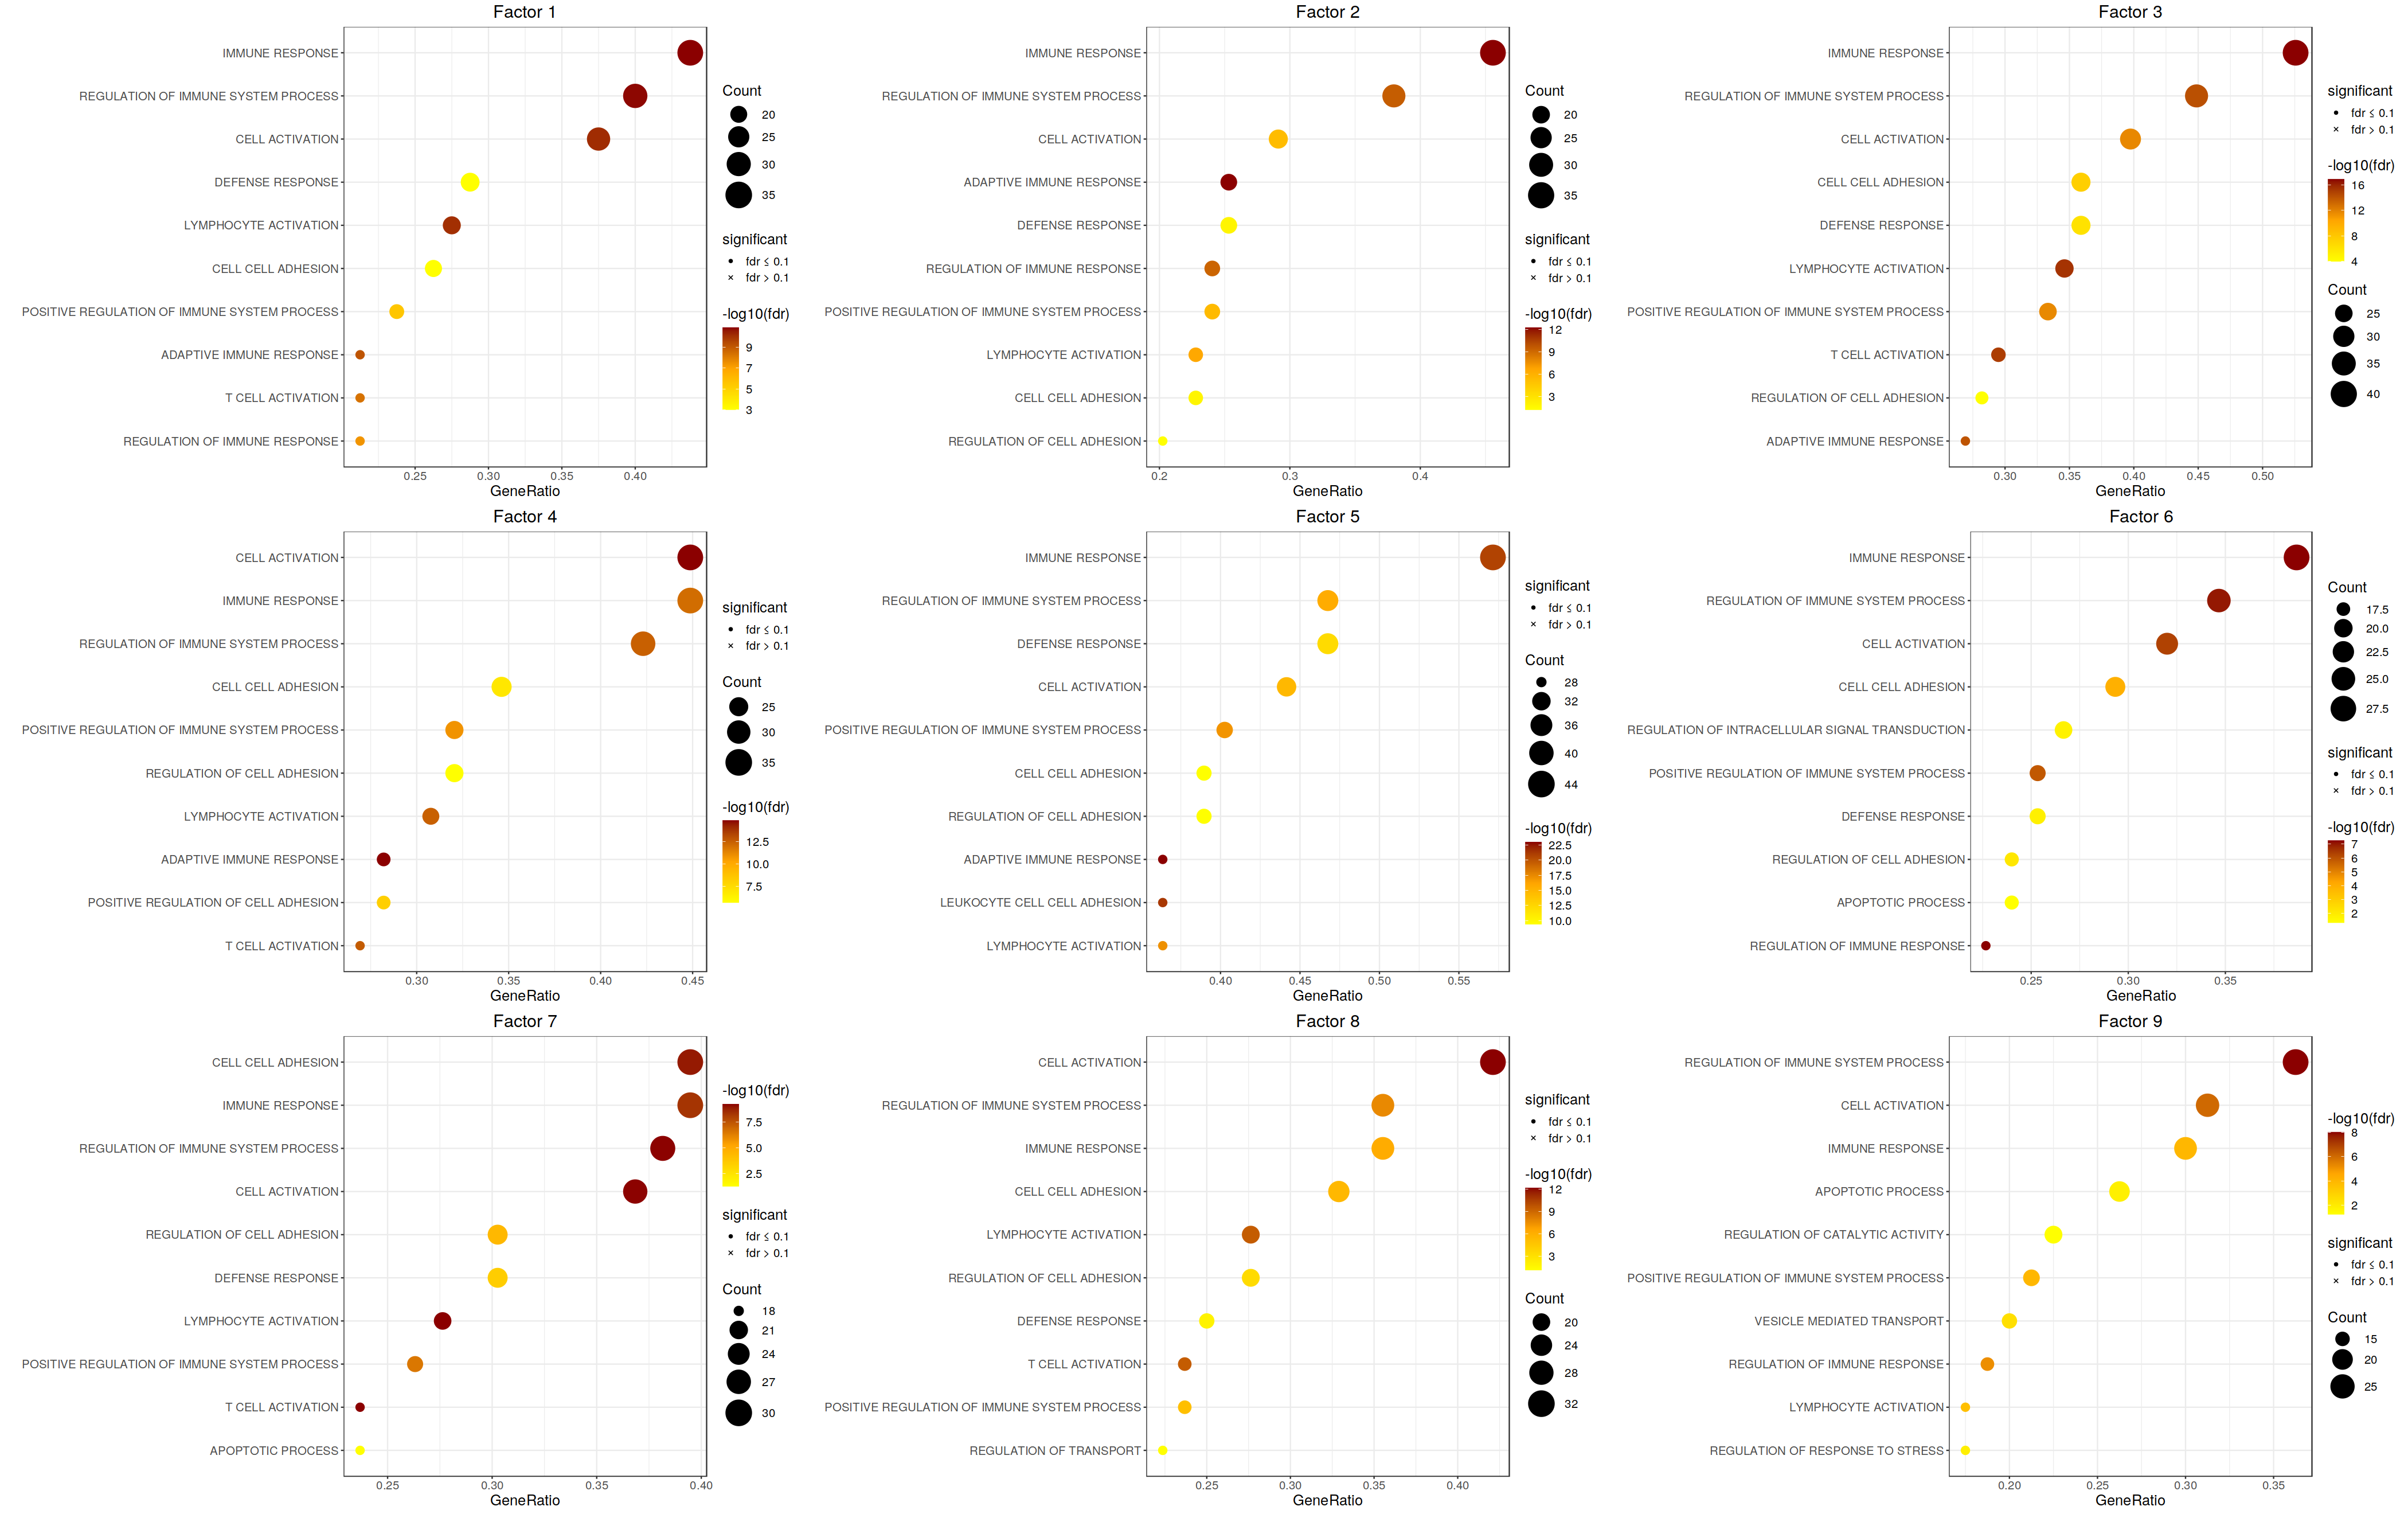

In [587]:
# visualize
dotplot_list<-c()
for (fn in names(ora_res)){
    cp.out<-ora_res[[fn]]
    g<-visualize_ora(cp.out, fn)
    
    dotplot_list[[fn]]<-g
    

}

h_ = 22
w_ = 35
options(repr.plot.height=h_, repr.plot.width=w_)

suppressWarnings({
    g<-cowplot::plot_grid(dotplot_list[[1]], dotplot_list[[2]], dotplot_list[[3]], dotplot_list[[4]], dotplot_list[[5]], 
                   dotplot_list[[6]], dotplot_list[[7]], dotplot_list[[8]], dotplot_list[[9]],
                   ncol = 3)
})

g

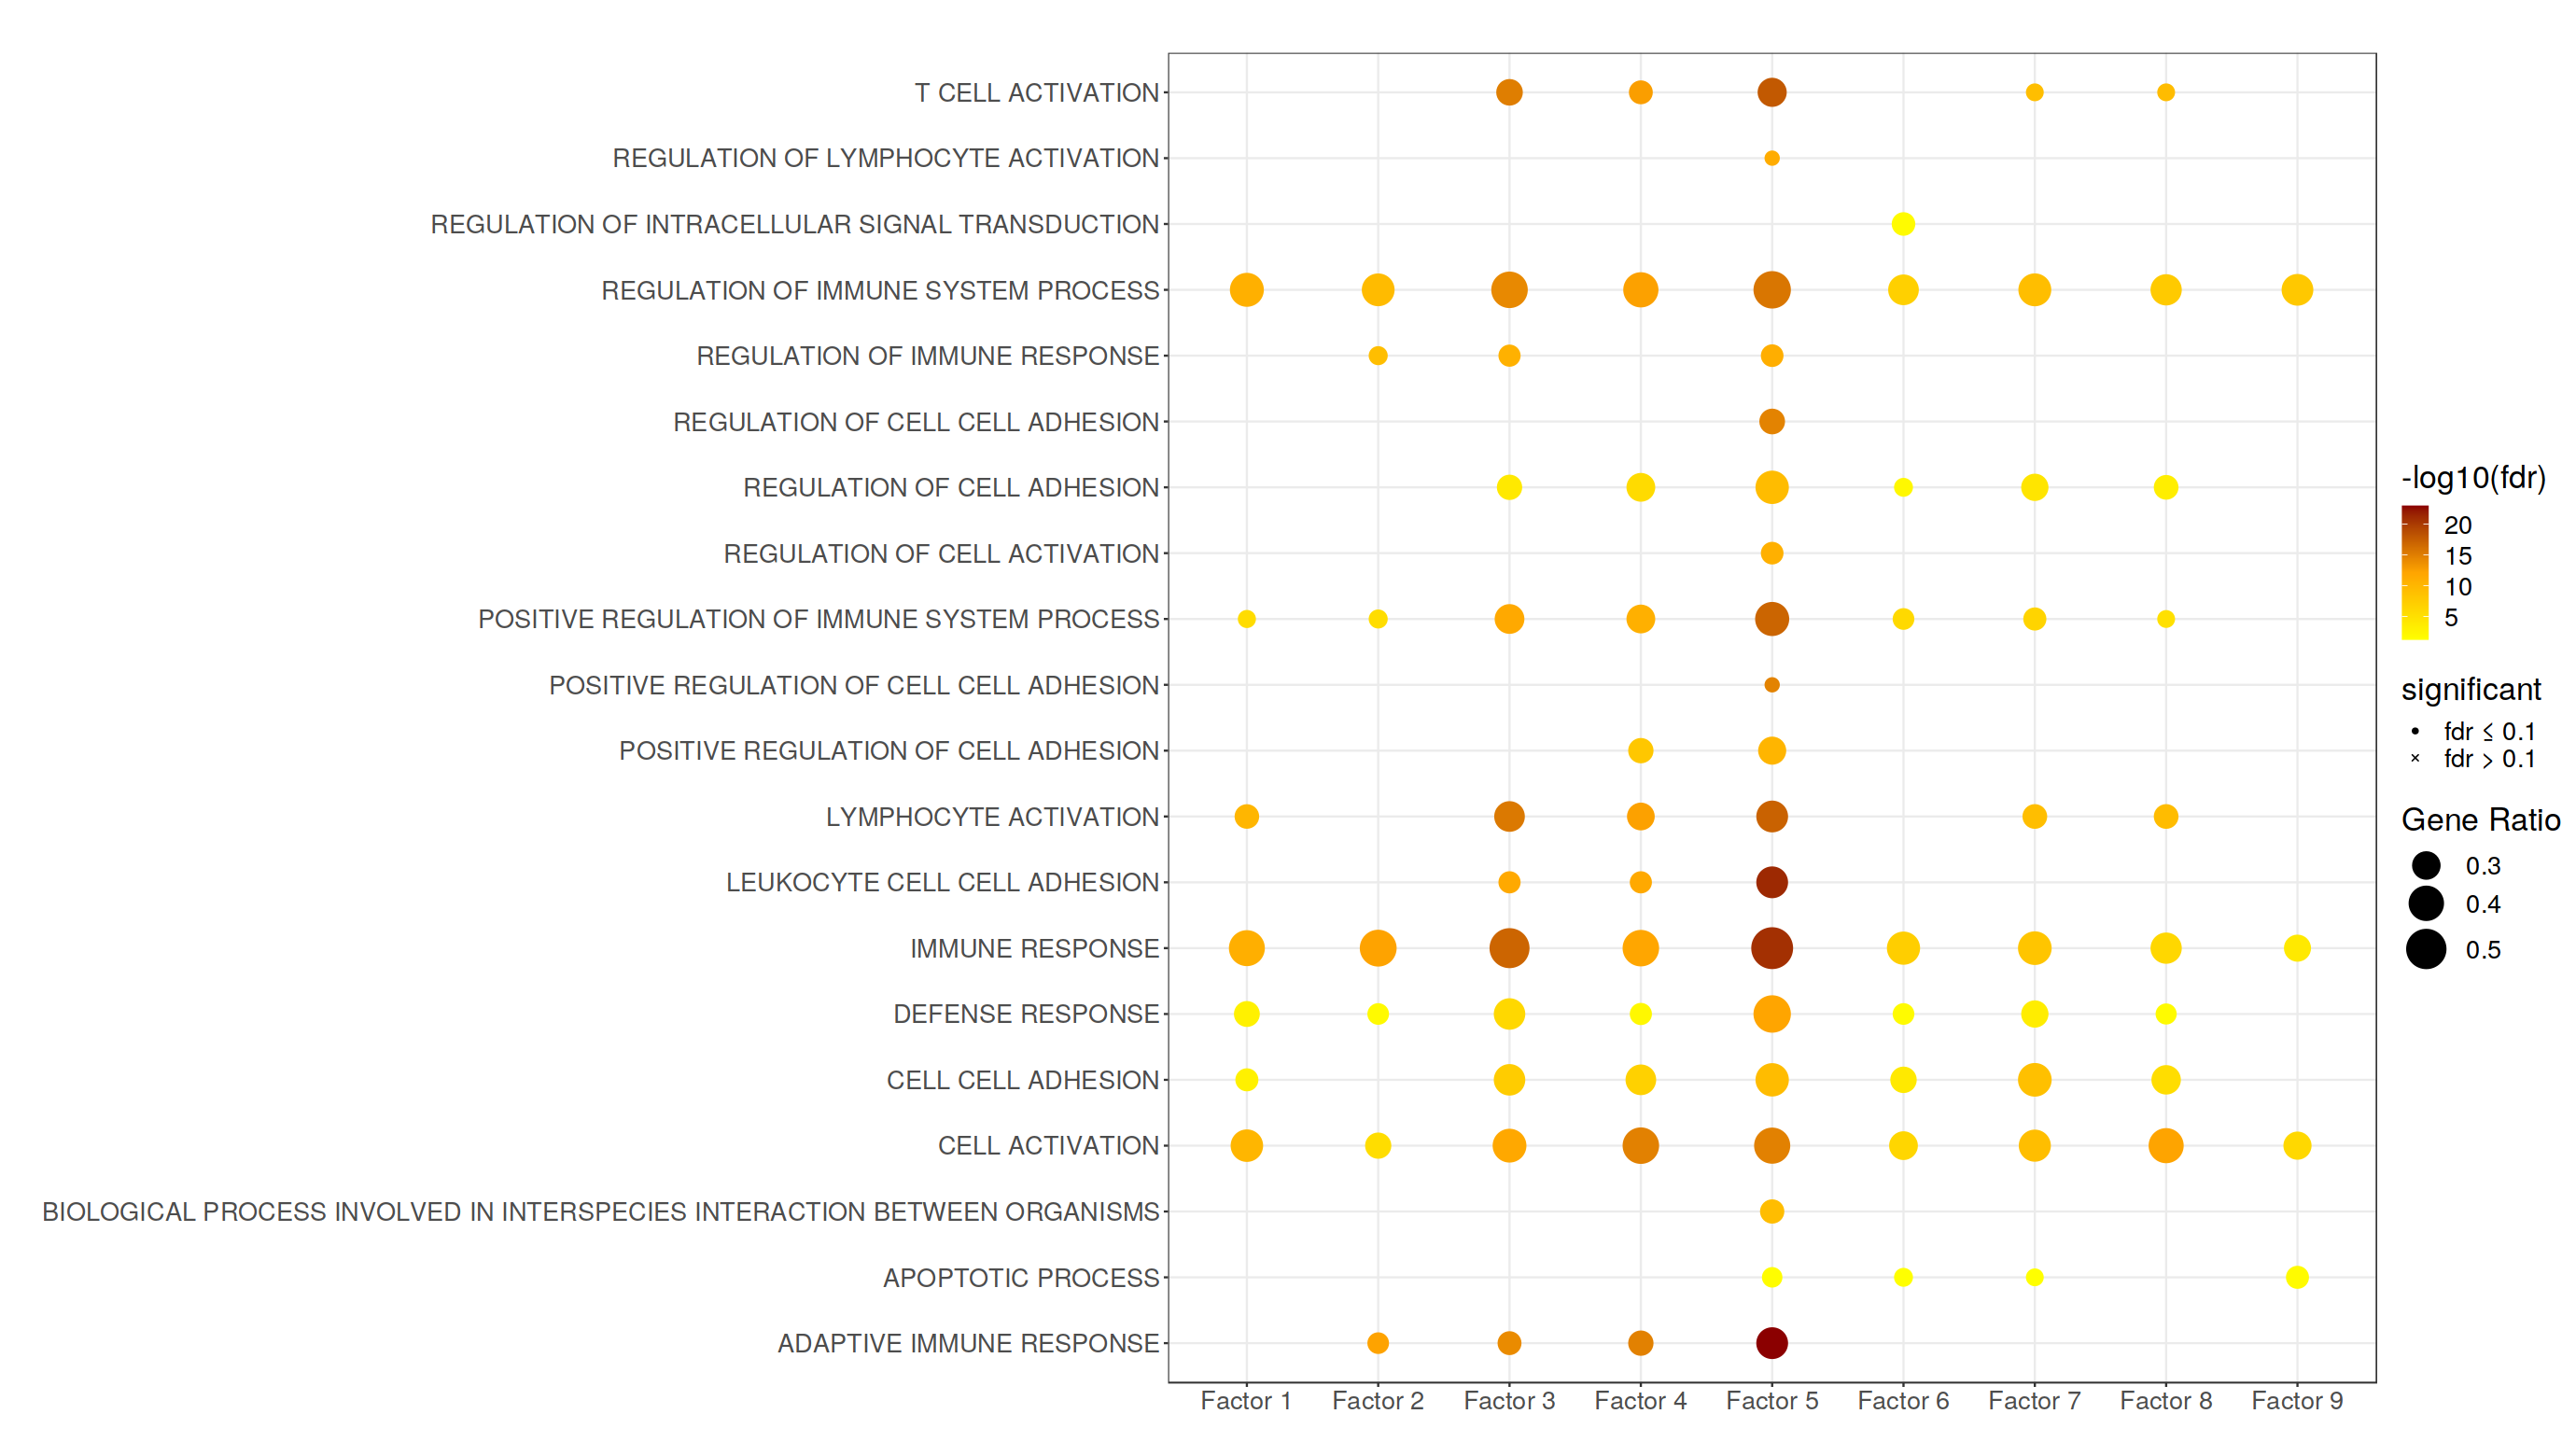

In [588]:
h_ = 13
w_ = 23
options(repr.plot.height=h_, repr.plot.width=w_)

g<-visualize_ora_all(ora_res, sig.thres = 0.1, top_n_terms = 20)
g

In [630]:
# run ORA on top LRs per factor
frac_top = 0.1 # get the top n% of LRs per factor
n_lrs_top<-round(frac_top*dim(factors$interactions)[[1]])

ora_res<-list()
for (factor.name in paste0('Factor ', c(3,8, 9))){
    factor_lrs<-names(tensor$get_top_factor_elements(order_name='interactions', 
                                factor_name=factor.name, 
                                top_number=as.integer(n_lrs_top)))
    
    if (length(setdiff(factor_lrs, lr_list)) > 0){
        stop('Unexpected LRs in loadings')
    }
    
    # if universe argument is not set, all the LRs in ora_db (which is all the LRs from the DB that mapped
    # to a pathway) will be used
    ora_res[[factor.name]]<-clusterProfiler::enricher(factor_lrs, TERM2GENE = ora_db, 
                                                     pAdjustMethod = 'BH', 
                                                      pvalueCutoff = 1, # will filter later
                                                      qvalueCutoff = 1 # will filter later
                                                     )
}

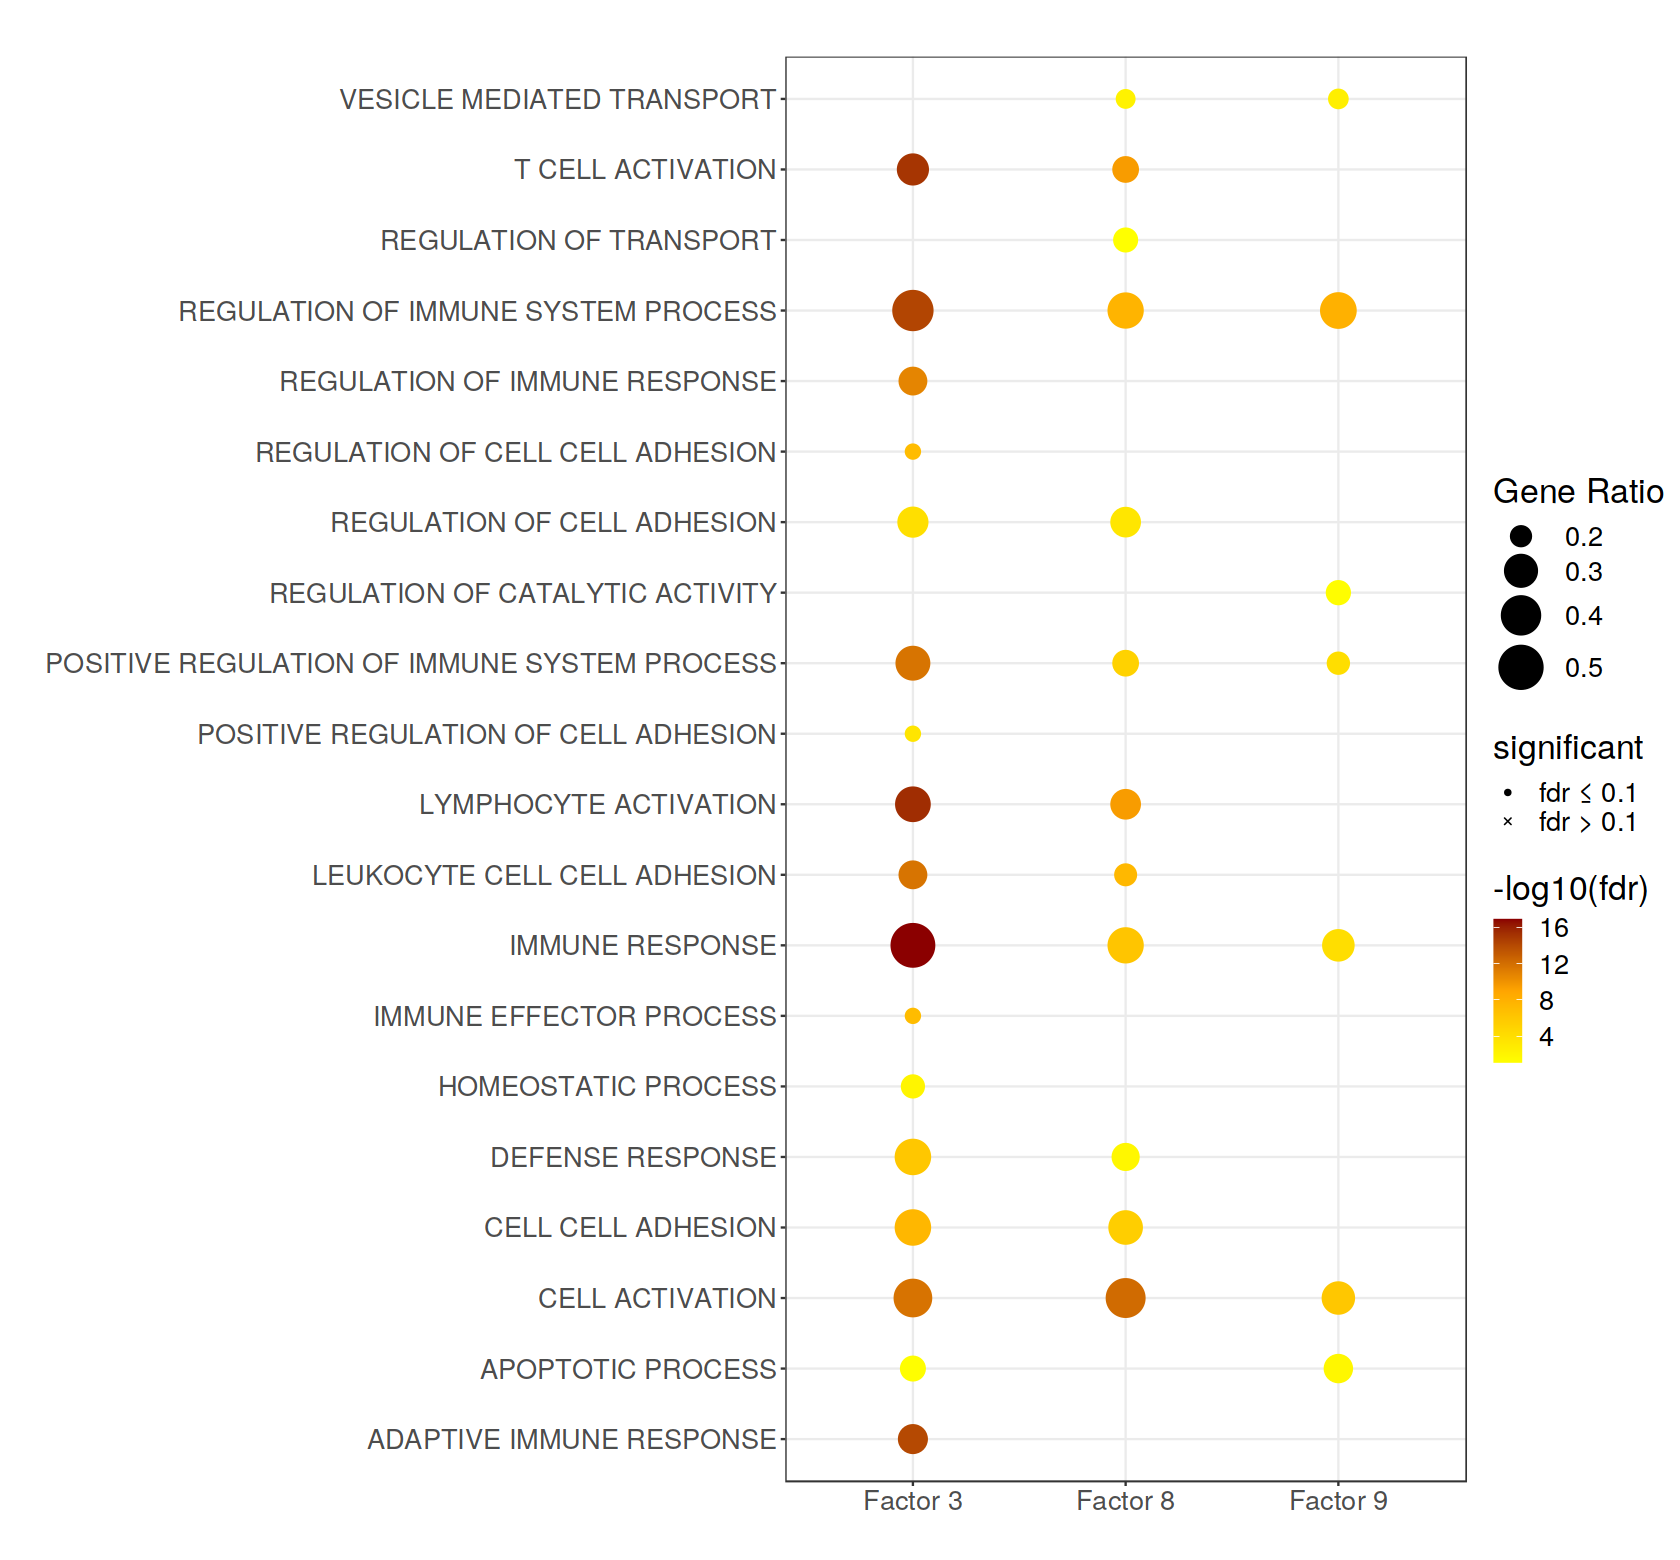

In [632]:
h_ = 13
w_ = 14
options(repr.plot.height=h_, repr.plot.width=w_)

g<-visualize_ora_all(ora_res, sig.thres = 0.1, top_n_terms = 20)
g

Run with setting background only to final scored interctions:


In [589]:
# run ORA on top LRs per factor
frac_top = 0.1 # get the top n% of LRs per factor
n_lrs_top<-round(frac_top*dim(factors$interactions)[[1]])

ora_res_strict<-list()
for (factor.name in paste0('Factor ', 1:tensor$rank)){
    factor_lrs<-names(tensor$get_top_factor_elements(order_name='interactions', 
                                factor_name=factor.name, 
                                top_number=as.integer(n_lrs_top)))
    
    if (length(setdiff(factor_lrs, lr_list)) > 0){
        stop('Unexpected LRs in loadings')
    }
    
    # if universe argument is not set, all the LRs in ora_db (which is all the LRs from the DB that mapped
    # to a pathway) will be used
    
    # for now, set background to all SCORED lrs, which is a subset of ora_db
    ora_res_strict[[factor.name]]<-clusterProfiler::enricher(factor_lrs, TERM2GENE = ora_db, 
                                                      universe = rownames(tensor$factors$interactions), 
                                                     pAdjustMethod = 'BH', 
                                                      pvalueCutoff = 1, # will filter later
                                                      qvalueCutoff = 1 # will filter later
                                                     )
}

In [590]:
# visualize
dotplot_list_strict<-c()
for (fn in names(ora_res_strict)){
    cp.out<-ora_res_strict[[fn]]
    g<-visualize_ora(cp.out, fn)
    
    dotplot_list_strict[[fn]]<-g
    

}

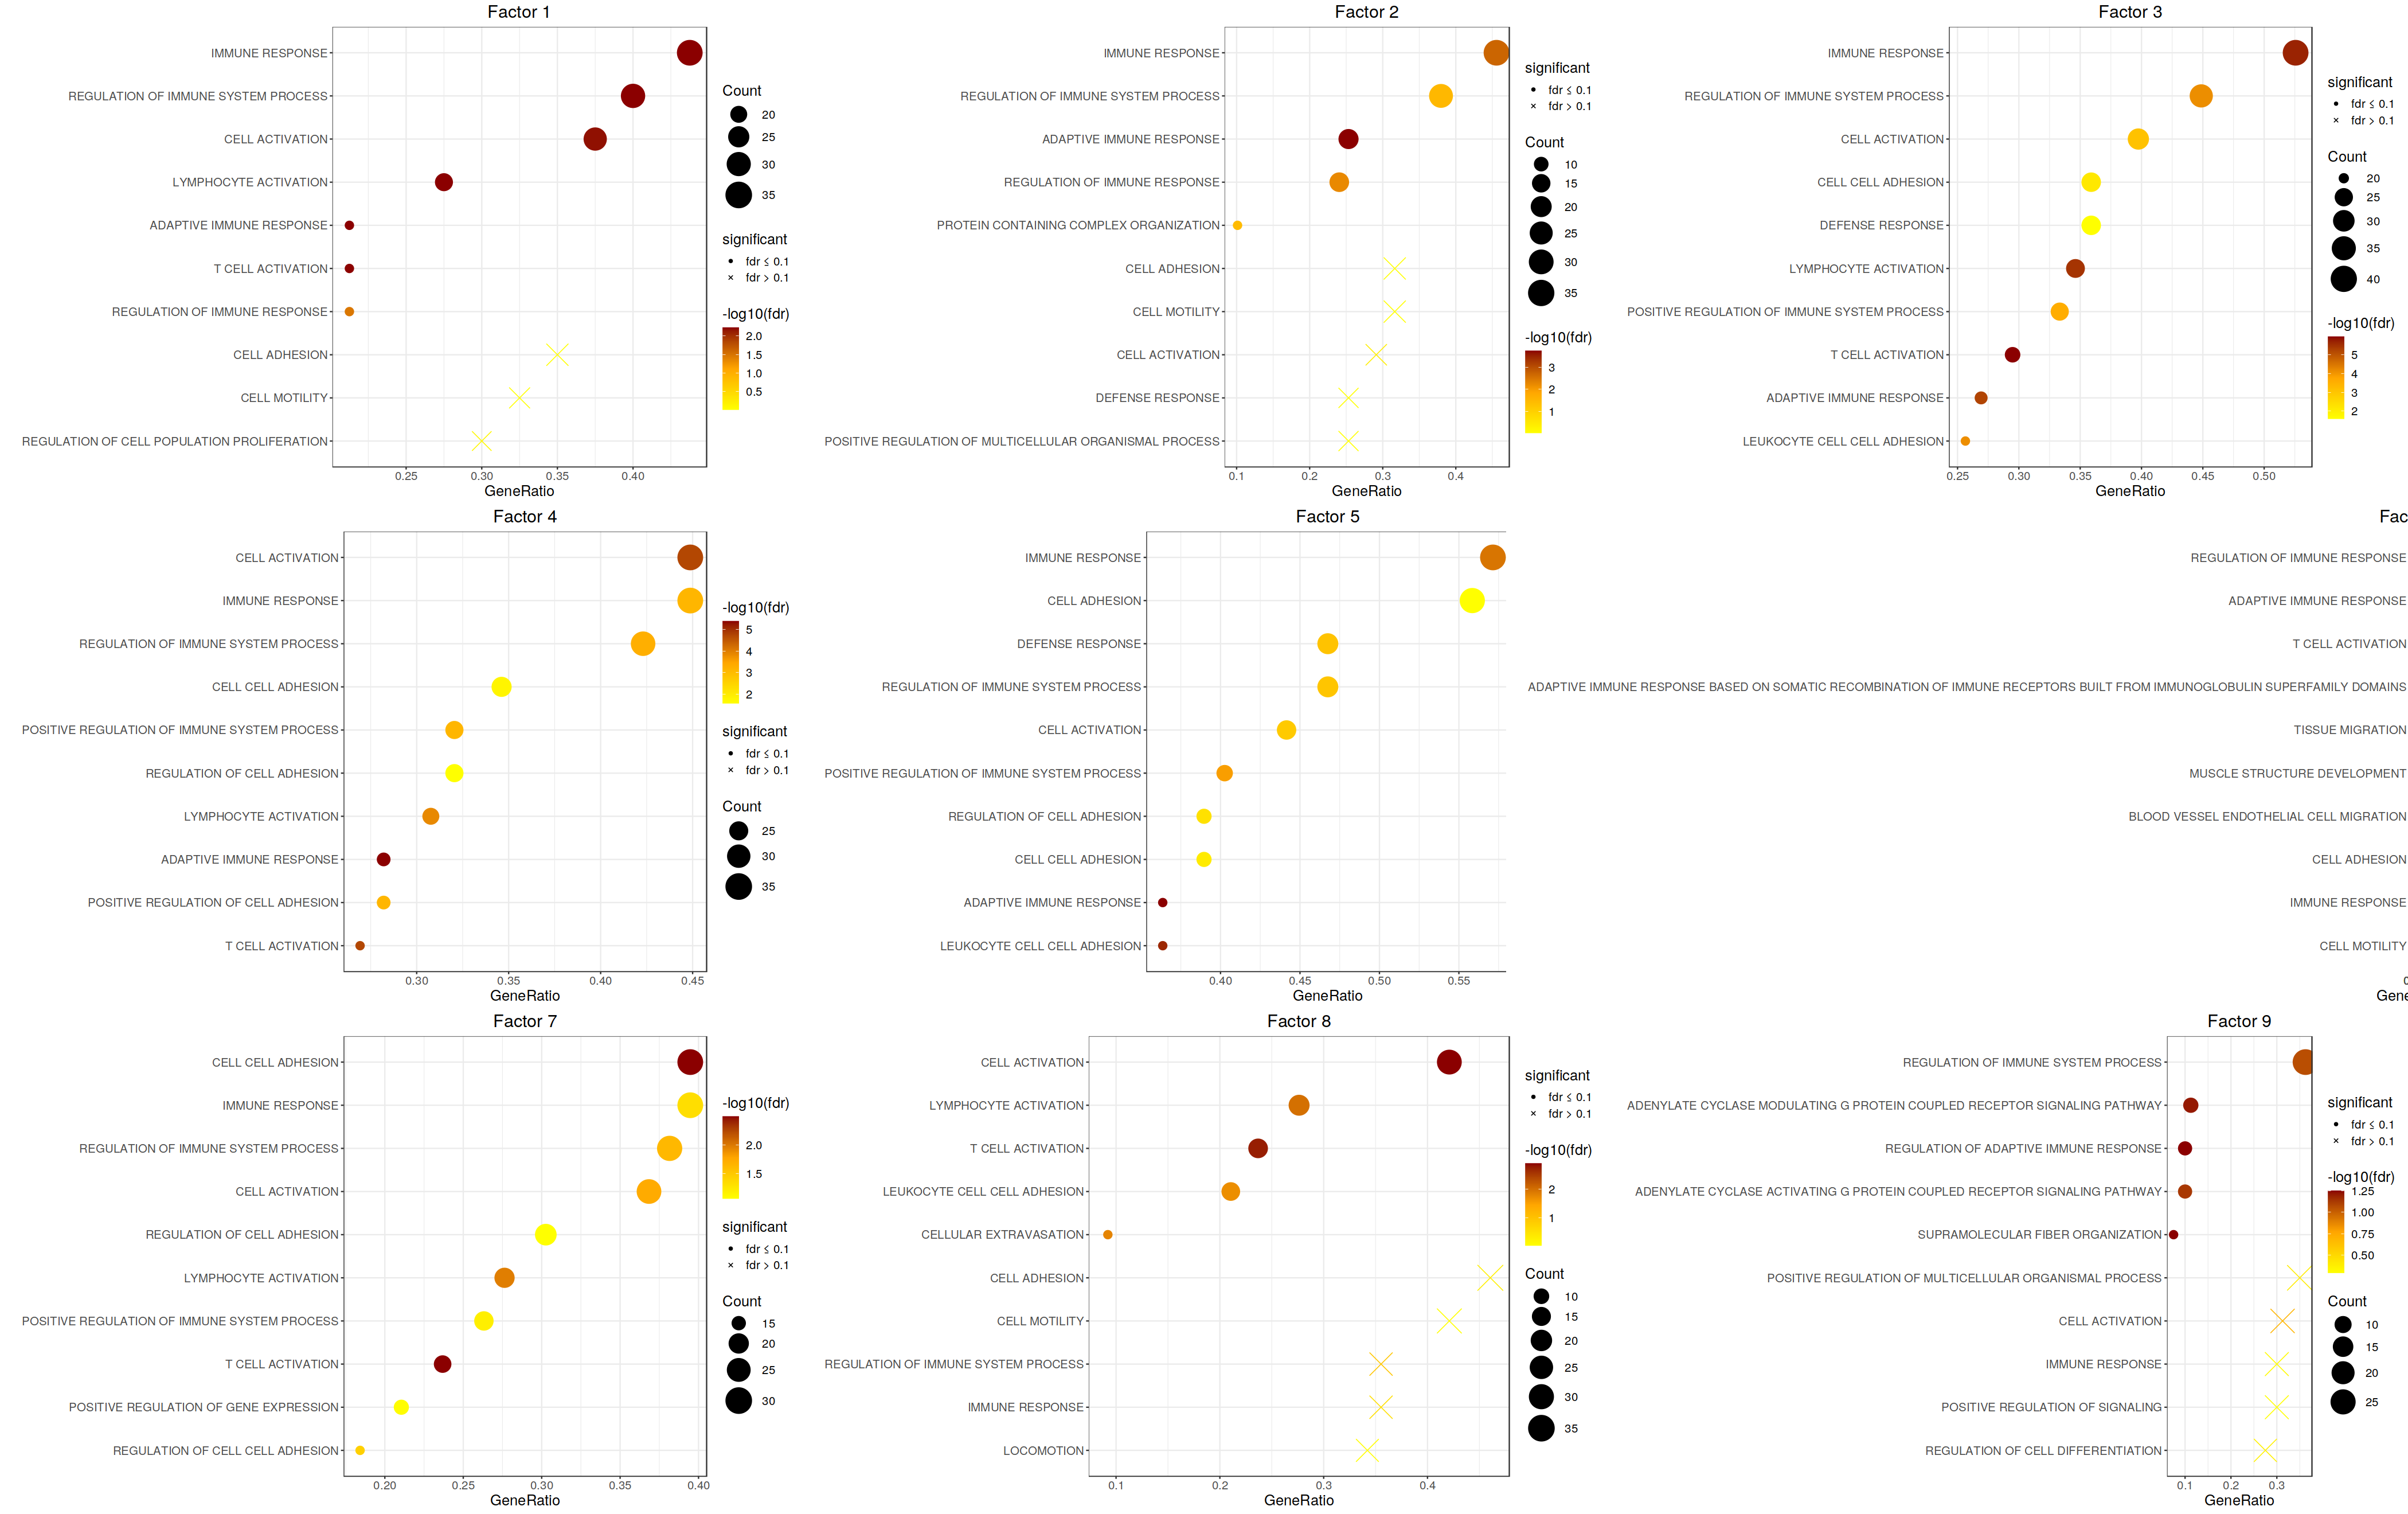

In [591]:
h_ = 22
w_ = 35
options(repr.plot.height=h_, repr.plot.width=w_)

suppressWarnings({
    g<-cowplot::plot_grid(dotplot_list_strict[[1]], dotplot_list_strict[[2]], dotplot_list_strict[[3]], dotplot_list_strict[[4]], dotplot_list_strict[[5]], 
                   dotplot_list_strict[[6]], dotplot_list_strict[[7]], dotplot_list_strict[[8]], dotplot_list_strict[[9]],
                   ncol = 3)
})

g

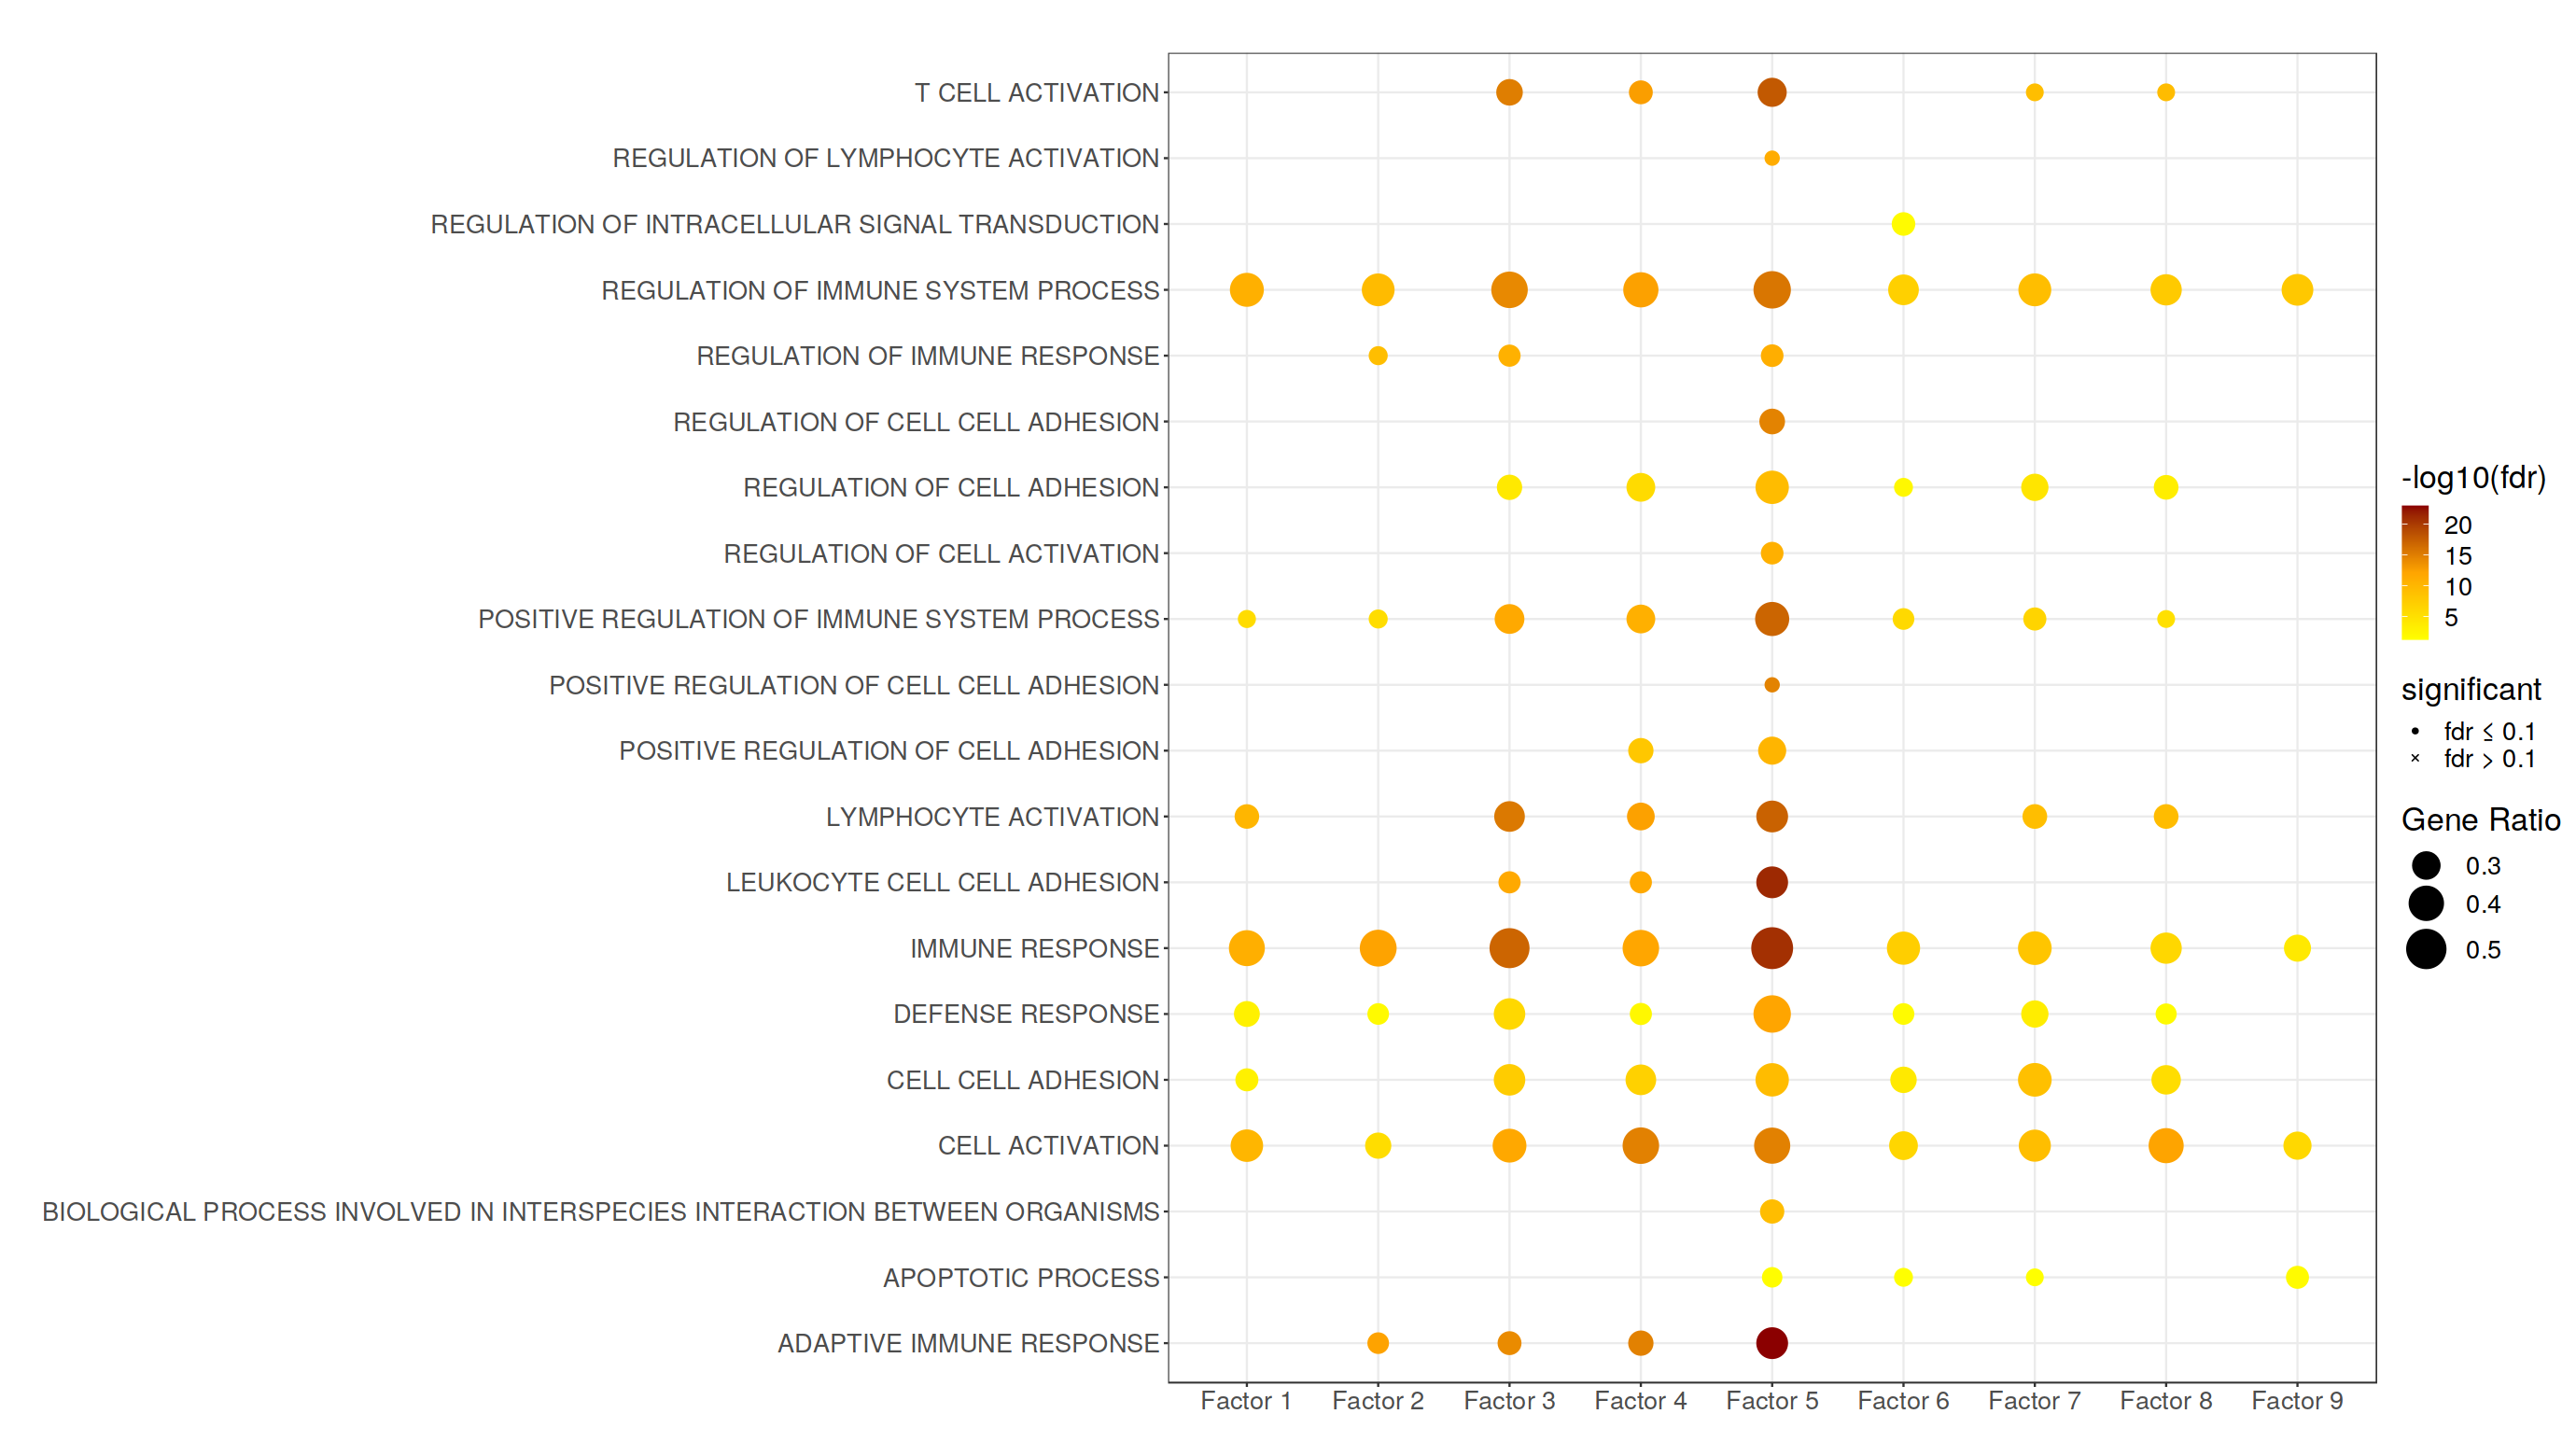

In [592]:
h_ = 13
w_ = 23
options(repr.plot.height=h_, repr.plot.width=w_)

g<-visualize_ora_all(ora_res, sig.thres = 0.1, top_n_terms = 20)
g

Note, neither background approach is perfect. The first includes LRs that may not even have been in the dataset, the second excludes LRs that may have been thresholded out. To get the real backgorund, would need to rerun with the least stringent thresholds. 


## ORA Metascape 

Prepping inputs for metascape. Will run the top 10% of scored LRs for each factor. Will use the background as all genes in the single-cell dataset that are present in the input CCC LR DB:

In [593]:
lr_pair_genes<-unique(c(lr_pairs$ligand, lr_pairs$receptor)) # lr_pairs is the full LR DB that liana was run on
lr_pair_genes<-unique(unlist(str_split(as.character(lr_pair_genes), '_'))) # complexes joined by _
dataset.genes<-rownames(abc.ccc@assays$RNA@data)

universe.background<-intersect(lr_pair_genes, dataset.genes) 

# get all teh scored lrs and convert LRs --> genes
scored_lrs<-unique(unlist(str_split(as.character(factors$interactions$lr), '\\^'))) # interactions joined by ^
scored_lrs<-unique(unlist(str_split(as.character(scored_lrs), '_'))) # complexes joined by _


cond1<-(length(scored_lrs) > length(lr_pair_genes))
cond2<-(length(setdiff(scored_lrs, lr_pair_genes)) > 0)
cond3<-(length(setdiff(scored_lrs, dataset.genes)) > 0)
if ((cond1) | (cond2) | (cond3)){
    stop('Unexpected difference in identified loadings and LR DB')
}

In [594]:
frac_top = 0.1 # get the top n% of LRs per factor
n_lrs_top<-round(frac_top*dim(factors$interactions)[[1]])

metascape_input = list()
# set background as all lr pairs from database that are present in sc dataset
metascape_input[['_BACKGROUND']]<-universe.background

for (factor.name in paste0('Factor ', 1:tensor$rank)){
    factor_lrs<-names(tensor$get_top_factor_elements(order_name='interactions', 
                                factor_name=factor.name, 
                                top_number=as.integer(n_lrs_top)))
    # LRs --> genes
    factor_genes<-unique(unlist(str_split(as.character(factor_lrs), '\\^'))) # LR interactions joined by ^
    factor_genes<-unique(unlist(str_split(as.character(factor_genes), '_'))) # complexes joined by _
    metascape_input[[factor.name]]<-factor_genes
}

# format input to metascape
max.length <- max(sapply(metascape_input, length))
metascape_input <- lapply(metascape_input, function(v) { c(v, rep(NA, max.length-length(v)))})
metascape_input<-do.call(cbind, metascape_input)
write.csv(metascape_input, paste0(data_path, 'interim/', 'lr_metascape_input_v2.csv'), row.names=FALSE)

Let's visualize the output:

In [596]:
format.ms<-function(ms, val_col){
    val_df<-as.data.frame(pivot_wider(data = ms, id_cols = 'GeneList', names_from = 'Description', 
                                      values_from = val_col, 
                                    values_fn = mean))
    val_df<-t(column_to_rownames(x = val_df, loc = 1))

    return(val_df)
}

In [597]:
ms.top20<-read.csv(paste0(data_path, 'interim/', 'lr_metascape_out_v2/Enrichment_heatmap/HeatmapSelectedGO.csv'))
ms.top100<-read.csv(paste0(data_path, 'interim/', 'lr_metascape_out_v2/Enrichment_heatmap/HeatmapSelectedGOTop100.csv'))
ms<-read.csv(paste0(data_path, 'interim/', 'lr_metascape_out_v2/Enrichment_GO/GO_AllLists.csv'))

First, let's see if there is any duplicate Description/GeneList combinations:

In [598]:
ms %>%
  dplyr::group_by(GeneList, Description) %>%
  dplyr::summarise(n = dplyr::n(), .groups = "drop") %>%
  dplyr::filter(n > 1L)

GeneList Description             n
1 Factor 8 Notch signaling pathway 2
2 Factor 9 Notch signaling pathway 2

In [599]:
ms[(ms$Description == 'Notch signaling pathway') & (ms$GeneList %in% c('Factor 8', 'Factor 9')), ]

Category                CategoryID GO         Description            
2311 GO Biological Processes 19         GO:0007219 Notch signaling pathway
2323 WikiPathways            27         WP29       Notch signaling pathway
2423 GO Biological Processes 19         GO:0007219 Notch signaling pathway
2441 WikiPathways            27         WP29       Notch signaling pathway
     PARENT_GO                          LogP Enrichment Z.score
2311 19_GO:0050896 response to stimulus -2.4 3.2        3.4    
2323                                    -2.3 4.0        3.6    
2423 19_GO:0050896 response to stimulus -4.8 4.6        5.6    
2441                                    -4.2 5.8        5.5    
     X.TotalGeneInLibrary X.GeneInGO X.GeneInHitList X.GeneInGOAndHitList
2311 1200                 25         106              7                  
2323 1200                 14         106              5                  
2423 1200                 25         104             10                  
2441 1200                 14         104              7                  
     X.InGO STDV..InGO
2311 6.6    2.4       
2323 4.7    2.1       
2423 9.6    2.9       
2441 6.7    2.5       
     GeneID                                                     
2311 11487|11491|18128|18129|19164|21803|21813                  
2323 11491|17305|18128|18129|19164                              
2423 11487|11491|11820|13610|18128|18129|19164|21803|21813|59287
2441 11491|17305|18128|18129|19164|21926|59287                  
     Hits                                                          
2311 Adam10|Adam17|Notch1|Notch2|Psen1|Tgfb1|Tgfbr2                
2323 Adam17|Mfng|Notch1|Notch2|Psen1                               
2423 Adam10|Adam17|App|S1pr3|Notch1|Notch2|Psen1|Tgfb1|Tgfbr2|Ncstn
2441 Adam17|Mfng|Notch1|Notch2|Psen1|Tnf|Ncstn                     
     Log.q.value. GeneList
2311 -1.4         Factor 8
2323 -1.4         Factor 8
2423 -3.0         Factor 9
2441 -2.6         Factor 9

In [600]:
'Notch signaling pathway' %in% ms.top100$Description

[1] TRUE

Looks l ike there is one term that is repeated , Notch signaling pathway. However, this term's values are quite similar for a given factor. So, we aggregate by the average in this case. 

In [601]:
freq<-format.ms(ms = ms, val_col = 'X.InGO')[ms.top20$Description, paste0('Factor ', 1:tensor$rank)]
pvals<-format.ms(ms = ms, val_col = 'Log.q.value.')[ms.top20$Description, paste0('Factor ', 1:tensor$rank)]

pvals<-as.data.frame(pvals)
pvals[['Enrichment.Term']]<-rownames(pvals)
freq<-as.data.frame(freq)
freq[['Enrichment.Term']]<-rownames(freq)

pvals<-melt(pvals, id.vars = 'Enrichment.Term', value.name = 'log10p', variable.name = 'Condition')
freq<-melt(freq, id.vars = 'Enrichment.Term', value.name = 'Frequency', variable.name = 'Condition')
pvals[['log10p']] <- -as.numeric(pvals[['log10p']]) 

viz.df <- cbind(pvals, Frequency = as.numeric(freq$Frequency))

Warning message:
“Removed 18 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 18 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 18 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 18 rows containing missing values (`geom_point()`).”


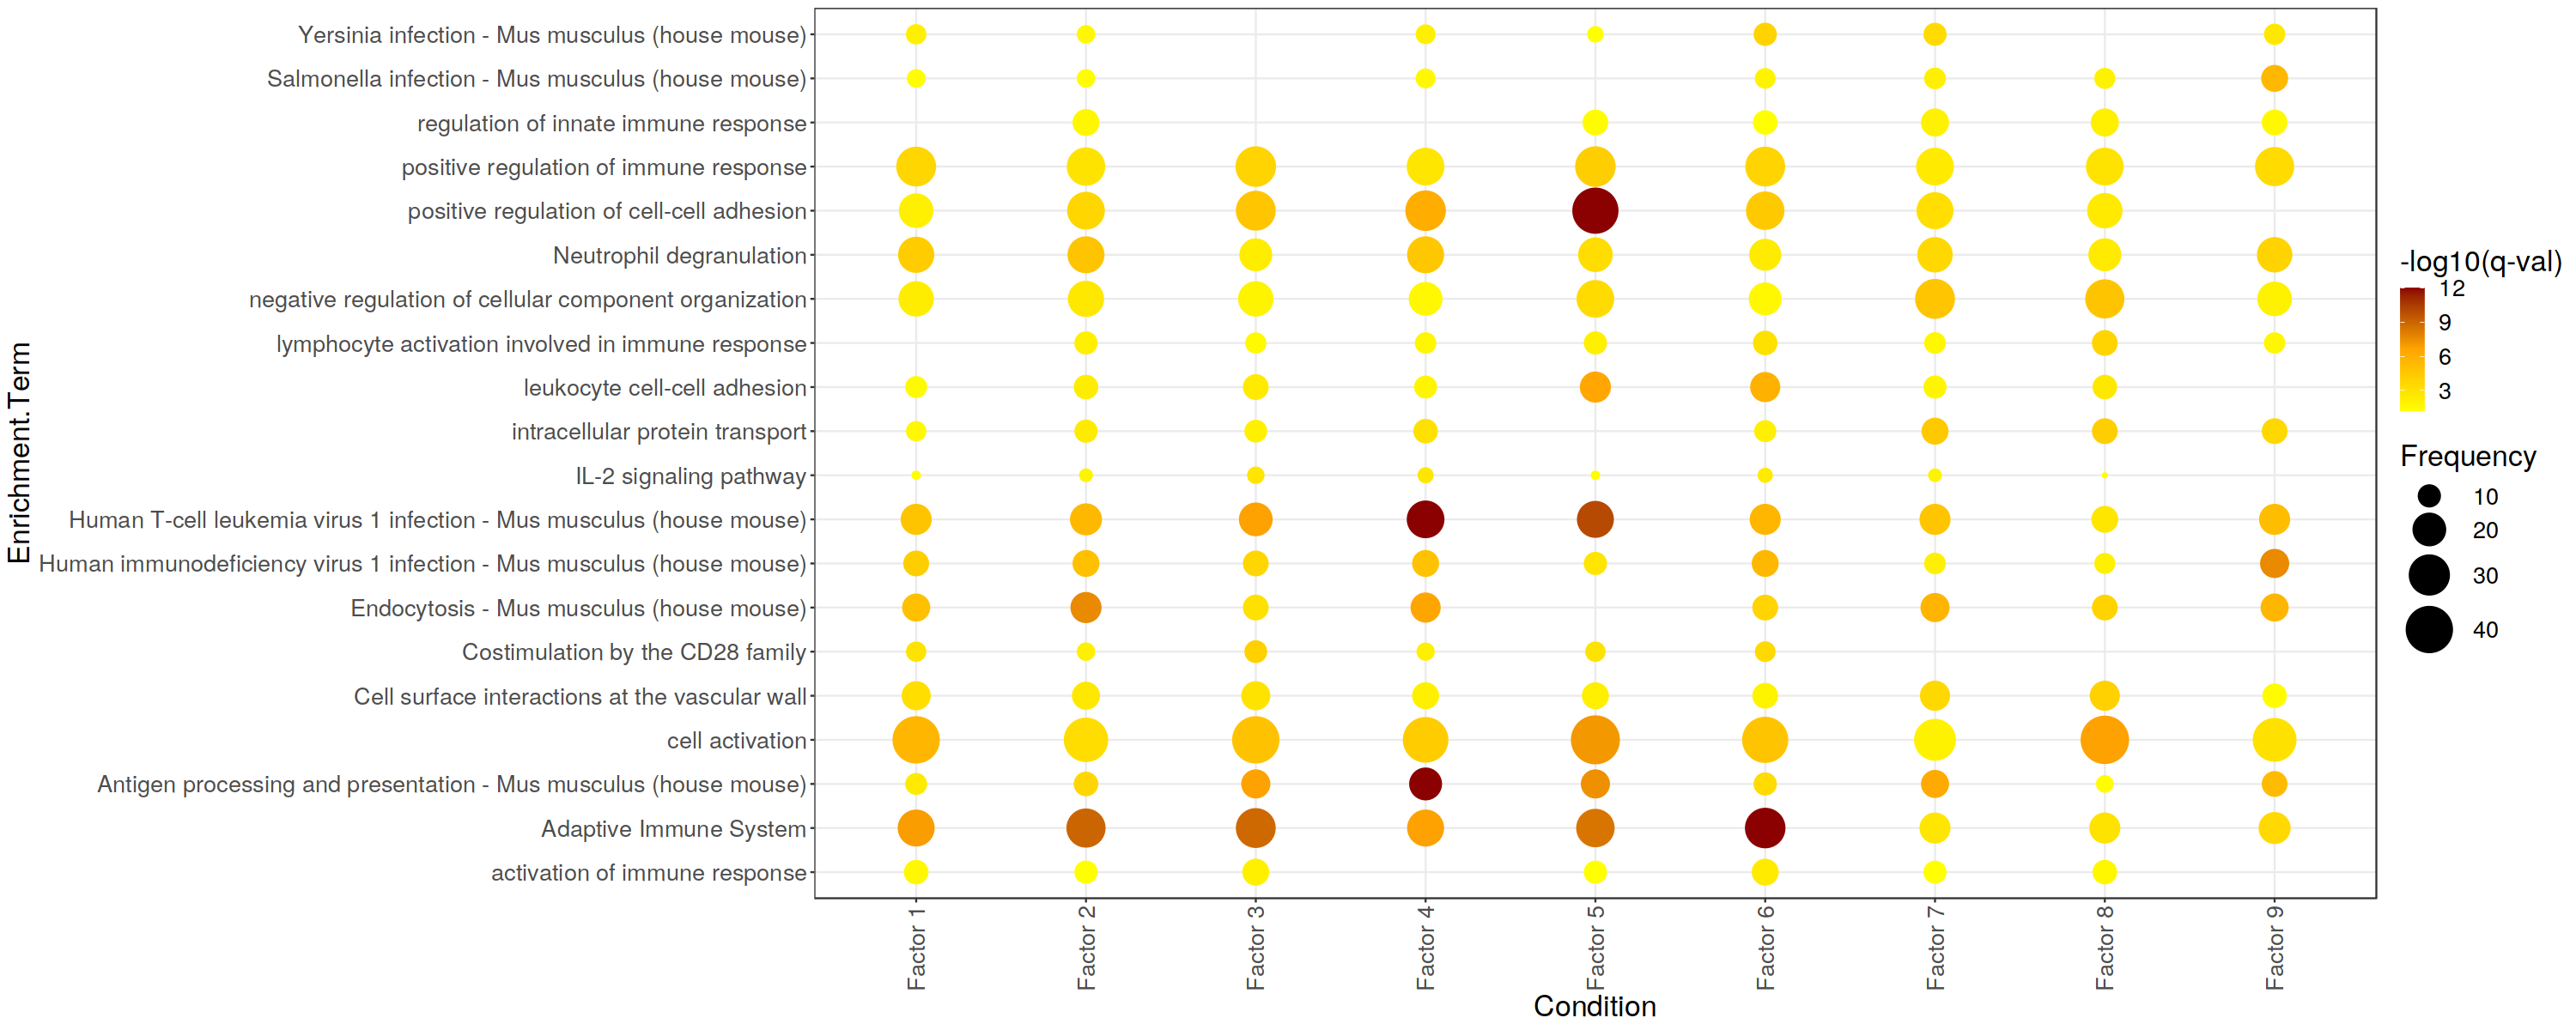

In [602]:
h_ = 10
w_ = 25
options(repr.plot.height=h_, repr.plot.width=w_)

green_hex = brewer.pal(n = 11, name ='RdYlGn')[[11]]
yellow_hex = brewer.pal(n = 11, name = 'RdYlGn')[[6]]
red_hex = brewer.pal(n = 11, name = 'RdYlGn')[[1]]

lower_q = min(viz.df$log10p[!(is.na(viz.df$log10p))])
upper_q = max(viz.df$log10p[!(is.na(viz.df$log10p))])
middle_q = mean(c(lower_q, upper_q)) # median(viz.df$log10p[!(is.na(viz.df$log10p))]) # 
# middle_q = 7.5

g<-ggplot(data = viz.df, aes(x = Condition, y = Enrichment.Term, color = log10p, size = Frequency)) + 
geom_point() + 
# scale_color_gradient2(low = green_hex, mid = yellow_hex, high = red_hex, name = '-log10(q-val)', 
#                      limits = c(lower_q, upper_q), midpoint = middle_q) + 
scale_colour_gradientn(colours = rev(c("darkred", "orange", "yellow")), name = '-log10(q-val)')+
scale_size_continuous(range = c(1,15)) +
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), 
                  text = element_text(size = 20))


for (ext in c('.svg', '.png', '.pdf')){
    fn<-paste0(data_path, 'figures/', 'lr_metascape_enrichment_dotplot', ext)
    ggsave(fn, g, height = h_, width = w_)}

g

Now get downstream enriched pathways:

In [49]:
# obtain progeny gene sets
progeny <- decoupleR::get_progeny(organism = 'mouse', top=5000) %>%
    select(-p_value)

Filter to pathways of interest:

In [50]:
progeny<-progeny[progeny$source %in% c('JAK-STAT', 'NFkB', 'TNFa', 'Trail', 'PI3K'), ] 
# progeny<-progeny[progeny$source %in% c('JAK-STAT', 'Trail'), ]

In [51]:
# convert to LR sets
progeny_lr <- generate_lr_geneset(sce = abc.ccc.sce,
                                  resource = progeny)

Run the enrichment. To be less stringent, we will only consider pathways of interest (see above), factors of interest (3,8, and 9), run the multiple test correction on each factor separately. 

In [52]:
fos<-c('3', '8', '9')
mat <- factors$interactions[, c('lr', paste0('Factor.', fos))] %>%
    column_to_rownames("lr") %>%
  as.matrix()

# run enrichment analysis with decoupler
# (we fit a univariate linear model for each gene set)
# We don't consider genesets with minsize < 10
res <- decoupleR::run_ulm(mat = mat,
                          network = progeny_lr,
                          .source = "set",
                          .target = "lr",
                          minsize=10) 
#   mutate(p_adj = p.adjust(p_value, method = "BH"))

# padj on each factor separately
for (factor_ in fos){
    x = paste0('Factor.', factor_)
    res[res$condition == x, 'p_adj']<-p.adjust(res[res$condition == x, ]$p_value, method = "BH")
}

In [53]:
res[res$p_value <= 0.05,]

statistic source condition score p_value p_adj

In [54]:
res[res$p_adj <= 0.1,]

statistic source condition score p_value p_adj

In [57]:
res<-res[with(res, order(p_adj, -abs(score))), ]
res

statistic source   condition score      p_value    p_adj    
1  ulm       JAK-STAT Factor.3   1.9199841 0.05516068 0.2758034
2  ulm       PI3K     Factor.9  -1.3820581 0.16728046 0.3396468
3  ulm       TNFa     Factor.9   1.3084040 0.19105446 0.3396468
4  ulm       JAK-STAT Factor.9  -1.2717127 0.20378808 0.3396468
5  ulm       NFkB     Factor.9   0.9900396 0.32240821 0.4030103
6  ulm       Trail    Factor.9  -0.6810158 0.49602833 0.4960283
7  ulm       Trail    Factor.3   1.1684620 0.24291515 0.6072879
8  ulm       NFkB     Factor.3  -0.5466763 0.58473022 0.8393486
9  ulm       TNFa     Factor.3  -0.3716973 0.71020156 0.8393486
10 ulm       PI3K     Factor.3   0.2027826 0.83934860 0.8393486
11 ulm       NFkB     Factor.8   0.7848257 0.43275246 0.8903493
12 ulm       TNFa     Factor.8   0.7661451 0.44378127 0.8903493
13 ulm       Trail    Factor.8   0.6218210 0.53420957 0.8903493
14 ulm       PI3K     Factor.8   0.3540472 0.72338248 0.8929243
15 ulm       JAK-STAT Factor.8  -0.1346411 0.89292428 0.8929243

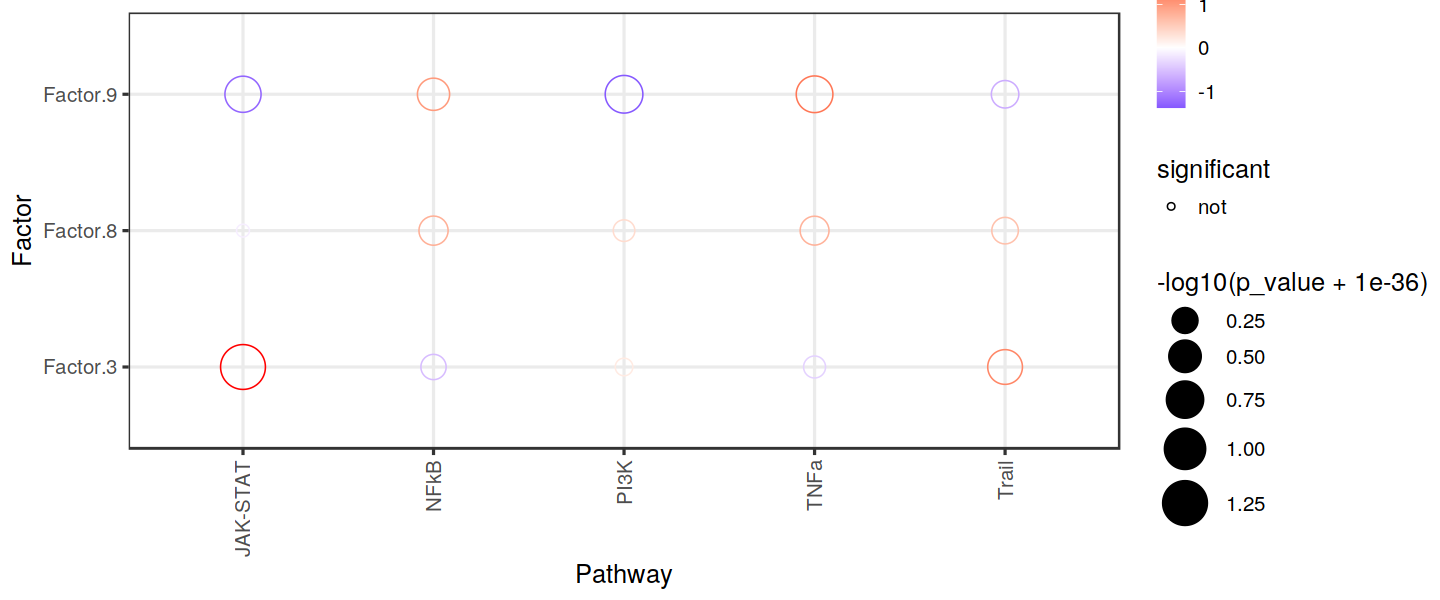

In [58]:
h_ = 5
w_ = 12
options(repr.plot.height=h_, repr.plot.width=w_)

res %>% # sig/isnig flag
  mutate(significant = if_else(p_adj <= 0.1, "signif.", "not")) %>%
  ggplot(aes(x=source, y=condition, shape=significant,
             colour=score, size=-log10(p_value+1e-36))) +
  geom_point() +
  scale_colour_gradient2(high = "red", low="blue") +
  scale_size_continuous(range = c(3, 12)) +
  scale_shape_manual(values=c(21, 16)) +
  theme_bw(base_size = 15) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  labs(x="Pathway",
       y="Factor",
       colour="Activity"
       )

In [101]:
write.csv(progeny_lr, paste0(data_path, 'processed/present_progeny_db.csv'))

In [102]:
paste0(data_path, 'processed/present_progeny_db.csv')

[1] "/data/hratch/norcross_abc/processed/present_progeny_db.csv"

In [90]:
progeny[progeny$source %in% lrs,]

source target weight

In [85]:
head(lrs)

[1] "Ace"    "Bdkrb2" "Actr2"  "Adrb2"  "Ldlr"   "Ada"

In [69]:
# unite(LR, c('source_genesymbol', 'target_genesymbol'), sep = '^')


[1] "Ace^Bdkrb2"                "Actr2^Adrb2"              
  [3] "Actr2^Ldlr"                "Ada^Dpp4"                 
  [5] "Adam10^Axl"                "Adam10^Cadm1"             
  [7] "Adam10^Cd44"               "Adam10^Gpnmb"             
  [9] "Adam10^Il6ra"              "Adam10^Met"               
 [11] "Adam10^Notch1"             "Adam10^Notch2"            
 [13] "Adam10^Tspan10"            "Adam10^Tspan14"           
 [15] "Adam10^Tspan17"            "Adam10^Tspan5"            
 [17] "Adam11^Itga4"              "Adam12^Itga9"             
 [19] "Adam12^Itgb1"              "Adam12^Sdc4"              
 [21] "Adam15^Itga5"              "Adam15^Itga9"             
 [23] "Adam15^Itgav"              "Adam15^Itgb1"             
 [25] "Adam15^Itgb3"              "Adam17^Il6ra"             
 [27] "Adam17^Itga5"              "Adam17^Itgb1"             
 [29] "Adam17^Met"                "Adam17^Notch1"            
 [31] "Adam17^Rhbdf2"             "Adam23^Itga4"             
 [33] "Adam23^Itga5"              "Adam23^Itgb3"             
 [35] "Adam9^Itga3"               "Adam9^Itga6"              
 [37] "Adam9^Itgav"               "Adam9^Itgb1"              
 [39] "Adam9^Itgb5"               "Adm2^Adrb2"               
 [41] "Adm2^Calcrl"               "Adm2^Ramp1"               
 [43] "Adm2^Ramp3"                "Adm2^Vipr1"               
 [45] "Adm^Adrb2"                 "Adm^Calcrl"               
 [47] "Adm^Gpr84"                 "Adm^Ramp1"                
 [49] "Adm^Ramp3"                 "Adm^Vipr1"                
 [51] "Ado^Adora2a"               "Ado^Adora2b"              
 [53] "Ado^Adora3"                "Agrn^Atp1a3"              
 [55] "Agrn^Dag1"                 "Agrn^Itgb1"               
 [57] "Agrn^Lrp1"                 "Alcam^Cd6"                
 [59] "Alcam^Nrp1"                "Ang^Egfr"                 
 [61] "Ang^Plxnb2"                "Angptl2^Itga5_Itgb1"      
 [63] "Angptl2^Pirb"              "Angptl4^Cdh5"             
 [65] "Angptl4^Itga5_Itgb1"       "Angptl4^Itgav_Itgb3"      
 [67] "Angptl4^Sdc1"              "Angptl4^Sdc2"             
 [69] "Angptl4^Sdc3"              "Angptl4^Sdc4"             
 [71] "Angptl7^Pirb"              "Anxa1^Egfr"               
 [73] "Anxa2^Tlr2"                "Apoa2^Ldlr"               
 [75] "Apoa2^Lrp1"                "Apod^Lepr"                
 [77] "Apoe^Abca1"                "Apoe^Ldlr"                
 [79] "Apoe^Lrp1"                 "Apoe^Lrp5"                
 [81] "Apoe^Lrp6"                 "Apoe^Lrp8"                
 [83] "Apoe^Lsr"                  "Apoe^Scarb1"              
 [85] "Apoe^Sdc2"                 "Apoe^Sorl1"               
 [87] "App^Ager"                  "App^Aplp1"                
 [89] "App^Aplp2"                 "App^Cd74"                 
 [91] "App^Fpr2"                  "App^Gpc1"                 
 [93] "App^Lrp1"                  "App^Lrp10"                
 [95] "App^Lrp6"                  "App^Ncstn"                
 [97] "App^Ngfr"                  "App^Notch2"               
 [99] "App^Ptger2"                "App^Rpsa"                 
[101] "App^Tnfrsf21"              "Areg^Erbb3"               
[103] "Arf1^Insr"                 "Arf1^Pld2"                
[105] "Arf6^Smap1"                "Arpc5^Adrb2"              
[107] "Arpc5^Ldlr"                "B2m^Cd247"                
[109] "B2m^Cd3d"                  "B2m^Cd3g"                 
[111] "B2m^Hfe"                   "B2m^Klrc1"                
[113] "B2m^Klrd1"                 "B2m^Tfrc"                 
[115] "Bmp1^Bmpr1a"               "Bmp1^Bmpr2"               
[117] "Bmp7^Actr2"                "Bmp7^Acvr1_Acvr2a"        
[119] "Bmp7^Acvr1_Acvr2b"         "Bmp7^Acvr1_Bmpr2"         
[121] "Bmp7^Acvr1b"               "Bmp7^Acvr2a_Bmpr1a"       
[123] "Bmp7^Bmpr1a_Bmpr2"         "Bmp7^Eng"                 
[125] "Bmp7^Ptprk"                "Bsg^Slc16a1"              
[127] "Bsg^Slc16a7"               "Btla^Cd247"               
[129] "Btla^Cd79a"                

In [45]:
# pathway = 'JAK-STAT'
# factor = 'Factor.8'
# # Plot LRs associated with Estrogen
# lrs <-  factors$interactions %>%
#   left_join(progeny_lr, by="lr") %>%
#   filter(set==pathway) %>%
#   select(lr, set, mor, loading = factor) %>%
#   mutate(lr = gsub(as.character(str_glue("\\^")), " -> ", lr)) %>%
#   mutate(weight = if_else(mor >= 0, "positive", "negative"))
# lrs %>%
#   # only label those that are > x
#   mutate(lr = if_else(loading>=0.001 & abs(mor) > 2, lr, "")) %>%
#   ggplot(aes(x=mor, y=loading, colour=weight)) +
#   # label only top 20
#   stat_smooth(method = "lm", col = "red") +
#   geom_point(alpha = 0.5) + 
#   ggrepel::geom_label_repel(aes(label = lr)) +
#   theme_bw(base_size = 15) +
#   scale_colour_manual(values = c("royalblue3", "red")) +
#   labs(x="Pathway Weight", y="LR Loading")

Factors 8 and 9 are complementary -- they involve similar cell types but opposite contexts. Let's see what differences there are at the LR resolution:

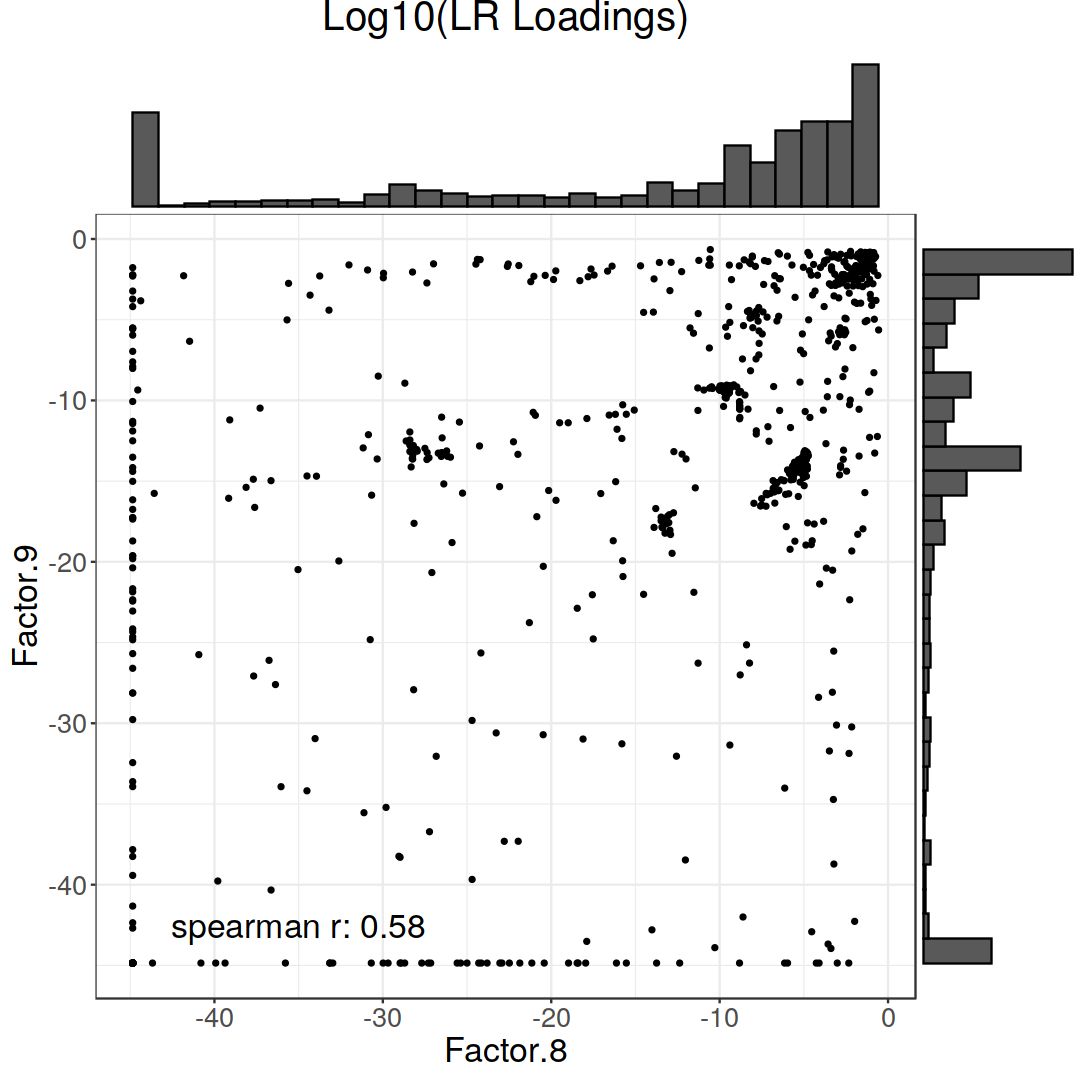

In [911]:
h_ = 9
w_ = 9
options(repr.plot.height=h_, repr.plot.width=w_)

viz.df<-factors$interactions[(c('Factor.8', 'Factor.9'))]

min_nonzero = min(viz.df[viz.df !=0]) # small psuedocount

viz.df <- log10(viz.df + min_nonzero)

spearmanr<-cor(viz.df$Factor.8, viz.df$Factor.9, method = 'spearman')
annotation <- data.frame(
   x = c(-35),
   y = c(-42.5),
   label = c((paste0('spearman r: ', format(round(spearmanr, 2), nsmall = 2))))
)

g<-ggplot(viz.df, aes(x = Factor.8, y = Factor.9)) + geom_point(size = 1, position = "jitter") + 
theme_bw() + ggtitle('Log10(LR Loadings)') + 
theme(plot.title = element_text(hjust = 0.5), text = element_text(size=20)) + 
geom_text(data=annotation, aes( x=x, y=y, label=label),
           size=7 , color = 'black')
g<-ggExtra::ggMarginal(g, type = "histogram")
g

In [640]:
viz.df[['lr']]<-factors$interactions[['lr']]
# factor9.loadings<-as.character<-viz.df[(viz.df$Factor.9 >= -10) & (viz.df$Factor.8 <= -30), 'lr']
# factor8.loadings<-as.character<-viz.df[(viz.df$Factor.8 >= -15) & (viz.df$Factor.9 <= -30), 'lr']

factor9.loadings<-as.character<-viz.df[(viz.df$Factor.9 >= -20) & (viz.df$Factor.8 <= -25), 'lr']
factor8.loadings<-as.character<-viz.df[(viz.df$Factor.8 >= -20) & (viz.df$Factor.9 <= -15), 'lr']

print(paste0('There are ', length(factor9.loadings), ' Factor 9 specific LRs'))
print(paste0('There are ', length(factor8.loadings), ' Factor 8 specific LRs'))

[1] "There are 98 Factor 9 specific LRs"
[1] "There are 110 Factor 8 specific LRs"


The Factor 9 loadings are:

In [652]:
as.character(factor9.loadings)

[1] "Adam15^Itgav"        "Adam17^Rhbdf2"       "Ado^Adora2a"        
 [4] "Angptl2^Pirb"        "Angptl4^Cdh5"        "Angptl4^Sdc4"       
 [7] "Apoa2^Ldlr"          "B2m^Hfe"             "C1qb^C1qbp"         
[10] "C3^Itgam"            "Ccl25^Ccr10"         "Ccl25^Ccr9"         
[13] "Ccl4^Ccr5"           "Cd200r1^Cd200"       "Cd40lg^Traf3"       
[16] "Cd47^Sirpa"          "Cdh1^Igf1r"          "Col9a3^Cd44"        
[19] "Col9a3^Itga1_Itgb1"  "Col9a3^Itga2_Itgb1"  "Cxcl10^Sdc4"        
[22] "Dll1^Notch4"         "Efnb2^Rhbdl2"        "Egf^Erbb3"          
[25] "Egf^Rhbdl2"          "Fadd^Abca1"          "Fadd^Fas"           
[28] "Fam3c^Lifr"          "Fgf13^Egfr"          "Fgf13^Fgfr1"        
[31] "Fgf2^Sdc4"           "Fn1^Cd79a"           "Gdf11^Acvr1b_Acvr2a"
[34] "Gdf11^Acvr2a_Tgfbr1" "Gdf11^Acvr2b_Tgfbr1" "Gnai2^Egfr"         
[37] "Gnai2^S1pr3"         "Gstp1^Egfr"          "H2-Ob^Cd4"          
[40] "Hdc^Hrh2"            "Hras^Insr"           "Hsp90aa1^Egfr"      
[43] "Igfbp4^Lrp6"         "Il10^Cd70"           "Il18^Il1rl2"        
[46] "Irak4^Tlr7"          "Lamb3^Cd151"         "Lamb3^Dag1"         
[49] "Lamc1^Dag1"          "Lefty1^Acvr2a"       "Lin7c^Abca1"        
[52] "Lman1^Mcfd2"         "Lrpap1^Ldlr"         "Lrpap1^Lrp8"        
[55] "Lrpap1^Sort1"        "Mif^Egfr"            "Mmp9^Ephb2"         
[58] "Mmp9^Reck"           "Mmp9^Tlr9"           "Ntrk3^Ptprf"        
[61] "Ntrk3^Ptprs"         "Osm^Il6st_Lifr"      "Pdcd1lg2^Rgmb"      
[64] "Plat^Itgam"          "Pltp^Abca1"          "Ptpn6^Clec12a"      
[67] "Ptpn6^Egfr"          "S100a1^Ager"         "S100a8^Cd36"        
[70] "S100a8^Cd68"         "S100a9^Ager"         "S100a9^Cd36"        
[73] "S100a9^Cd68"         "Sema4a^Plxnd1"       "Spon1^App"          
[76] "Spon1^Lrp8"          "Spp1^Ptger4"         "St6gal1^Egfr"       
[79] "Tfpi^Sdc4"           "Tgfb1^Egfr"          "Tgfb1^Sdc2"         
[82] "Tgm2^Sdc4"           "Thbs4^Cd36"          "Thbs4^Itgav_Itgb3"  
[85] "Tnf^Fas"             "Tnf^Ptprs"           "Tnf^Sema4c"         
[88] "Tnf^Tnfrsf1a"        "Tnf^Tnfrsf1b"        "Tnfsf12^Cd163"      
[91] "Tnfsf13b^Tfrc"       "Tnfsf13b^Tnfrsf13b"  "Tnr^Itgav_Itgb3"    
[94] "Trf^Tfrc"            "Txlna^Stx1a"         "Vegfb^Adrb2"        
[97] "a^Atrn"              "a^Mgrn1"

The Factor 8 loadings are:

In [654]:
as.character(factor8.loadings)

[1] "Adam15^Itga9"              "Adam17^Itga5"             
  [3] "Adam23^Itga4"              "Adam23^Itgb3"             
  [5] "Adam9^Itga6"               "Adm2^Adrb2"               
  [7] "Adm2^Ramp1"                "Agrn^Itgb1"               
  [9] "Angptl2^Itga5_Itgb1"       "Angptl4^Sdc1"             
 [11] "Angptl4^Sdc2"              "Anxa2^Tlr2"               
 [13] "Apod^Lepr"                 "Apoe^Sdc2"                
 [15] "App^Ager"                  "App^Aplp2"                
 [17] "App^Ncstn"                 "App^Ptger2"               
 [19] "Areg^Erbb3"                "Bmp7^Acvr1_Acvr2a"        
 [21] "Bmp7^Acvr1_Acvr2b"         "Btla^Tnfrsf14"            
 [23] "Calr^Itga2b"               "Ccl17^Ccr4"               
 [25] "Ccl22^Ccr4"                "Cd34^Sell"                
 [27] "Cd70^Cd27"                 "Cd80^Cd28"                
 [29] "Cd80^Ctla4"                "Ceacam1^Havcr2"           
 [31] "Clec11a^Itga10"            "Clec1b^Klrb1a"            
 [33] "Cntn1^Notch2"              "Col11a1^Itga1_Itgb1"      
 [35] "Col27a1^Itga1_Itgb1"       "Col27a1^Itga2_Itgb1"      
 [37] "Cxcl16^Cxcr6"              "Dll1^Notch2"              
 [39] "Efnb2^Pecam1"              "Efnb3^Ephb2"              
 [41] "Entpd1^Adora3"             "F11r^Itgal_Itgb2"         
 [43] "F13a1^Itga4"               "Fam3c^Ffar2"              
 [45] "Fasl^Tnfrsf1a"             "Fgf2^Sdc2"                
 [47] "Fn1^Dpp4"                  "Fn1^Itga2"                
 [49] "Fn1^Itga4_Itgb1"           "Fn1^Itga4_Itgb7"          
 [51] "Fn1^Itga5_Itgb1"           "Fn1^Itga6"                
 [53] "Fn1^Itga8_Itgb1"           "Fn1^Itgav_Itgb1"          
 [55] "Fn1^Itgav_Itgb3"           "Fn1^Nt5e"                 
 [57] "Fn1^Sdc2"                  "Fndc5^Itgav"              
 [59] "Gnai2^Cxcr2"               "Grn^Cd209a"               
 [61] "Grn^Tnfrsf1a"              "Gzma^F2rl2"               
 [63] "Has2^Cd44"                 "Hspa8^Adrb2"              
 [65] "Il15^Il15ra_Il2rb_Il2rg"   "Il15^Il2ra"               
 [67] "Il15ra^Axl"                "Il18^Il18r1_Il18rap"      
 [69] "Il1b^Sigirr"               "Il7^Il2rg_Il7r"           
 [71] "Irak4^Tlr6"                "Jag1^Notch1"              
 [73] "Jag2^Notch1"               "Jag2^Notch2"              
 [75] "L1cam^Itgav_Itgb3"         "Lta^Tnfrsf14"             
 [77] "Mdk^Sdc2"                  "Mfge8^Itgb3"              
 [79] "Mfge8^Itgb5"               "Mif^Cd74_Cxcr2"           
 [81] "Mtmr4^Smad3"               "Ncam1^Fgfr1"              
 [83] "Pam^Dpp4"                  "Pdgfb^S1pr1"              
 [85] "Penk^Oprd1"                "Sema7a^Itga1_Itgb1"       
 [87] "Sema7a^Plxnc1"             "Sirpa^Cd47"               
 [89] "Spint1^St14"               "Spp1^Itga8_Itgb1"         
 [91] "Spp1^Itgav_Itgb3"          "Spp1^S1pr1"               
 [93] "Tgfb3^Acvr1_Tgfbr1_Tgfbr2" "Tgfb3^Acvrl1"             
 [95] "Tgfb3^Tgfbr3"              "Tnf^Ffar2"                
 [97] "Tnfsf12^Tnfrsf12a"         "Tnfsf12^Tnfrsf8"          
 [99] "Tnfsf13b^Tnfrsf13c"        "Tnfsf14^Ltbr"             
[101] "Tnfsf14^Tnfrsf14"          "Vasp^Cxcr2"               
[103] "Vcam1^Itga4_Itgb1"         "Vwf^Itgb1"                
[105] "Wnt3^Fzd10_Lrp6"           "Wnt3^Fzd6_Lrp6"           
[107] "Wnt5b^Fzd1_Lrp6"           "Wnt5b^Fzd5_Lrp6"          
[109] "Wnt5b^Fzd7_Lrp6"           "Xcl1^Xcr1"

In [656]:
write.csv(ora_db, paste0(data_path, 'interim/lr_pathways_all.csv'))

In [642]:
# run ORA on top LRs per factor
factor.list<-list(Factor.8 = factor8.loadings, Factor.9 = factor9.loadings)

ora_res<-list()
for (factor.name in names(factor.list)){
    factor_lrs <- factor.list[[factor.name]]
    if (length(setdiff(factor_lrs, lr_list)) > 0){
        stop('Unexpected LRs in loadings')
    }
    
    # if universe argument is not set, all the LRs in ora_db (which is all the LRs from the DB that mapped
    # to a pathway) will be used
    cp.out<-clusterProfiler::enricher(factor_lrs, TERM2GENE = ora_db, 
                                                     pAdjustMethod = 'BH', 
                                                      pvalueCutoff = 1, # will filter later
                                                      qvalueCutoff = 1
                                                     )
    tr = 'ADAPTIVE IMMUNE RESPONSE BASED ON SOMATIC RECOMBINATION OF IMMUNE RECEPTORS BUILT FROM IMMUNOGLOBULIN SUPERFAMILY DOMAINS'
    cp.out@result[cp.out@result$ID == tr, 'ID'] = 'ADAPTIVE IMMUNE RESPONSE (SOMATIC RECOMBINATION)'
    ora_res[[factor.name]]<-cp.out

}


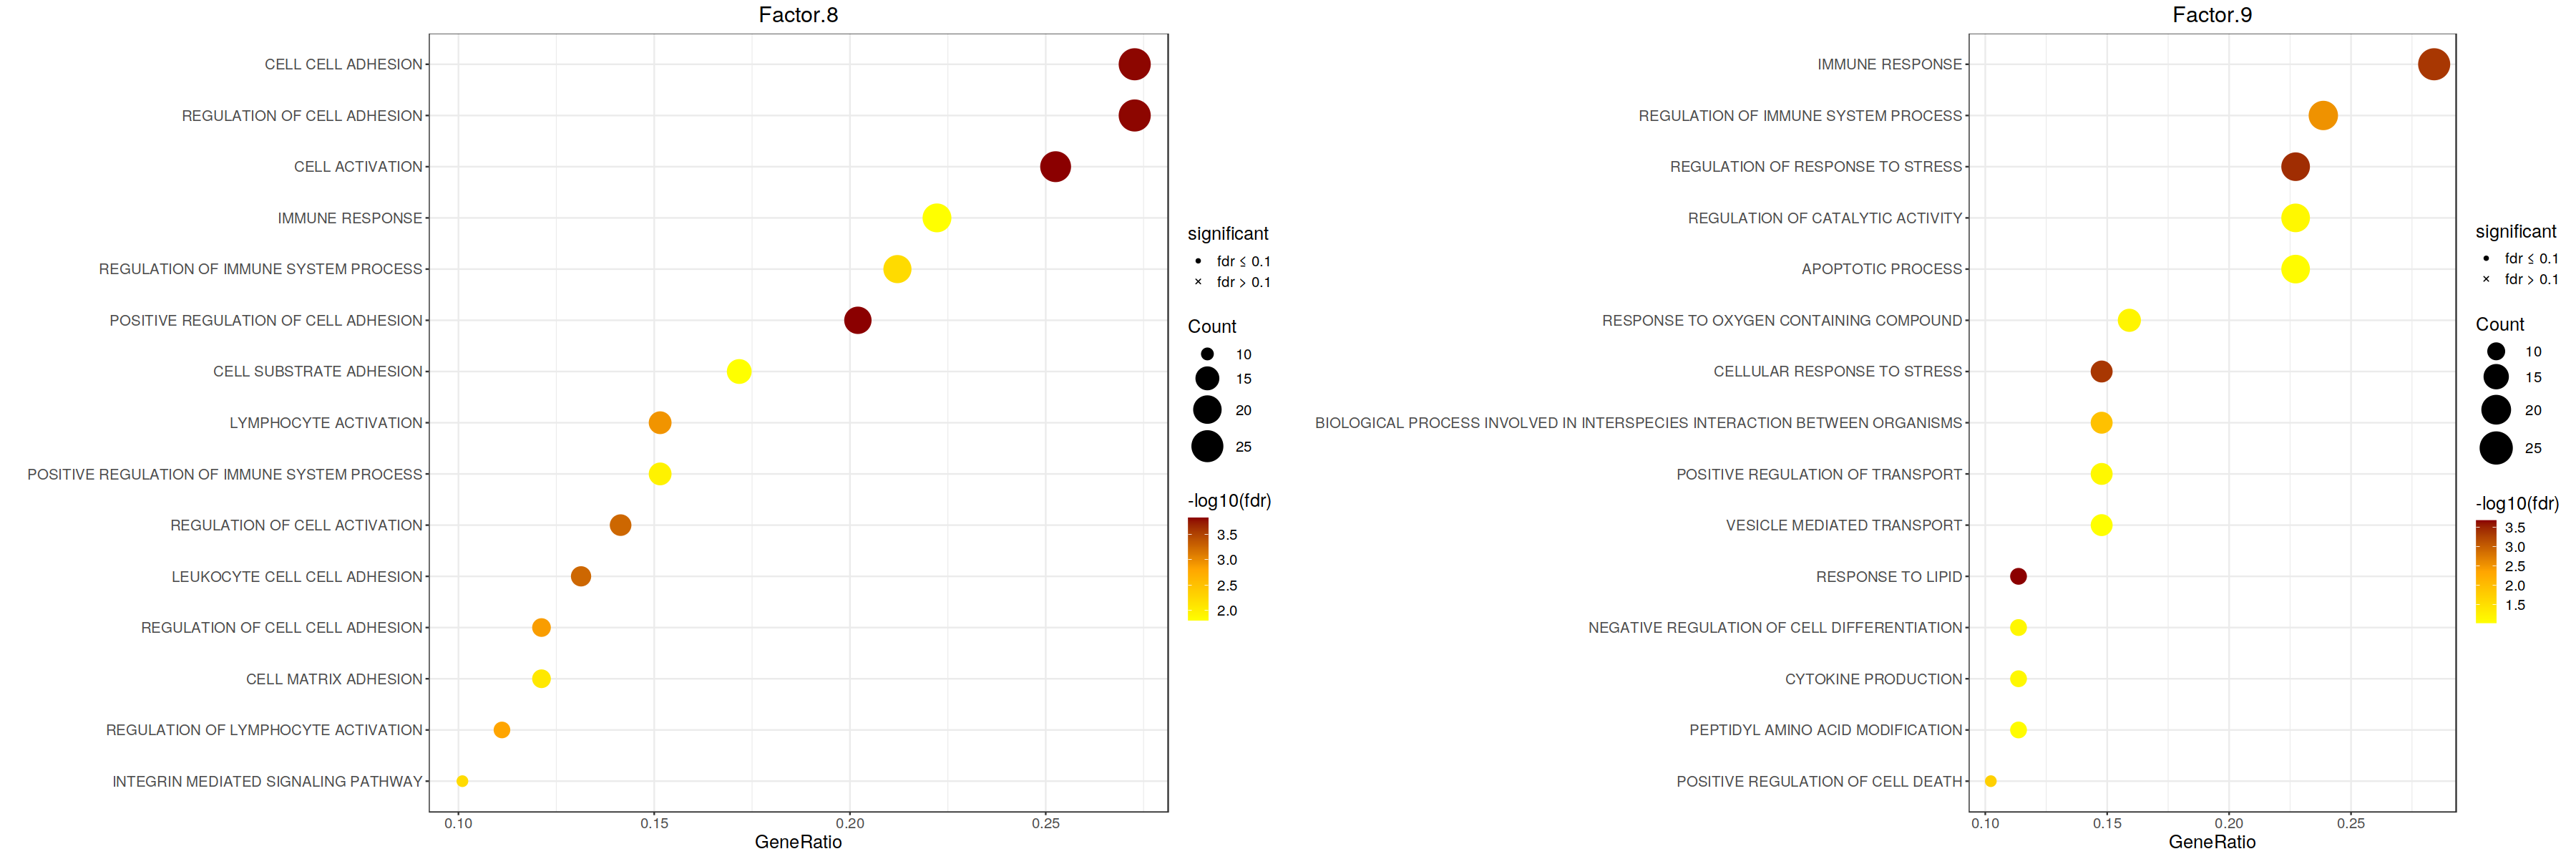

In [643]:
w_ = 30
h_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)


# visualize
dotplot_list<-c()
for (fn in names(ora_res)){
    cp.out<-ora_res[[fn]]
    g<-visualize_ora(cp.out, fn, top_n_terms = 15)
    
    dotplot_list[[fn]]<-g

}

suppressWarnings({
    g<-cowplot::plot_grid(dotplot_list[[1]], dotplot_list[[2]],
                   ncol = 2)
})

g

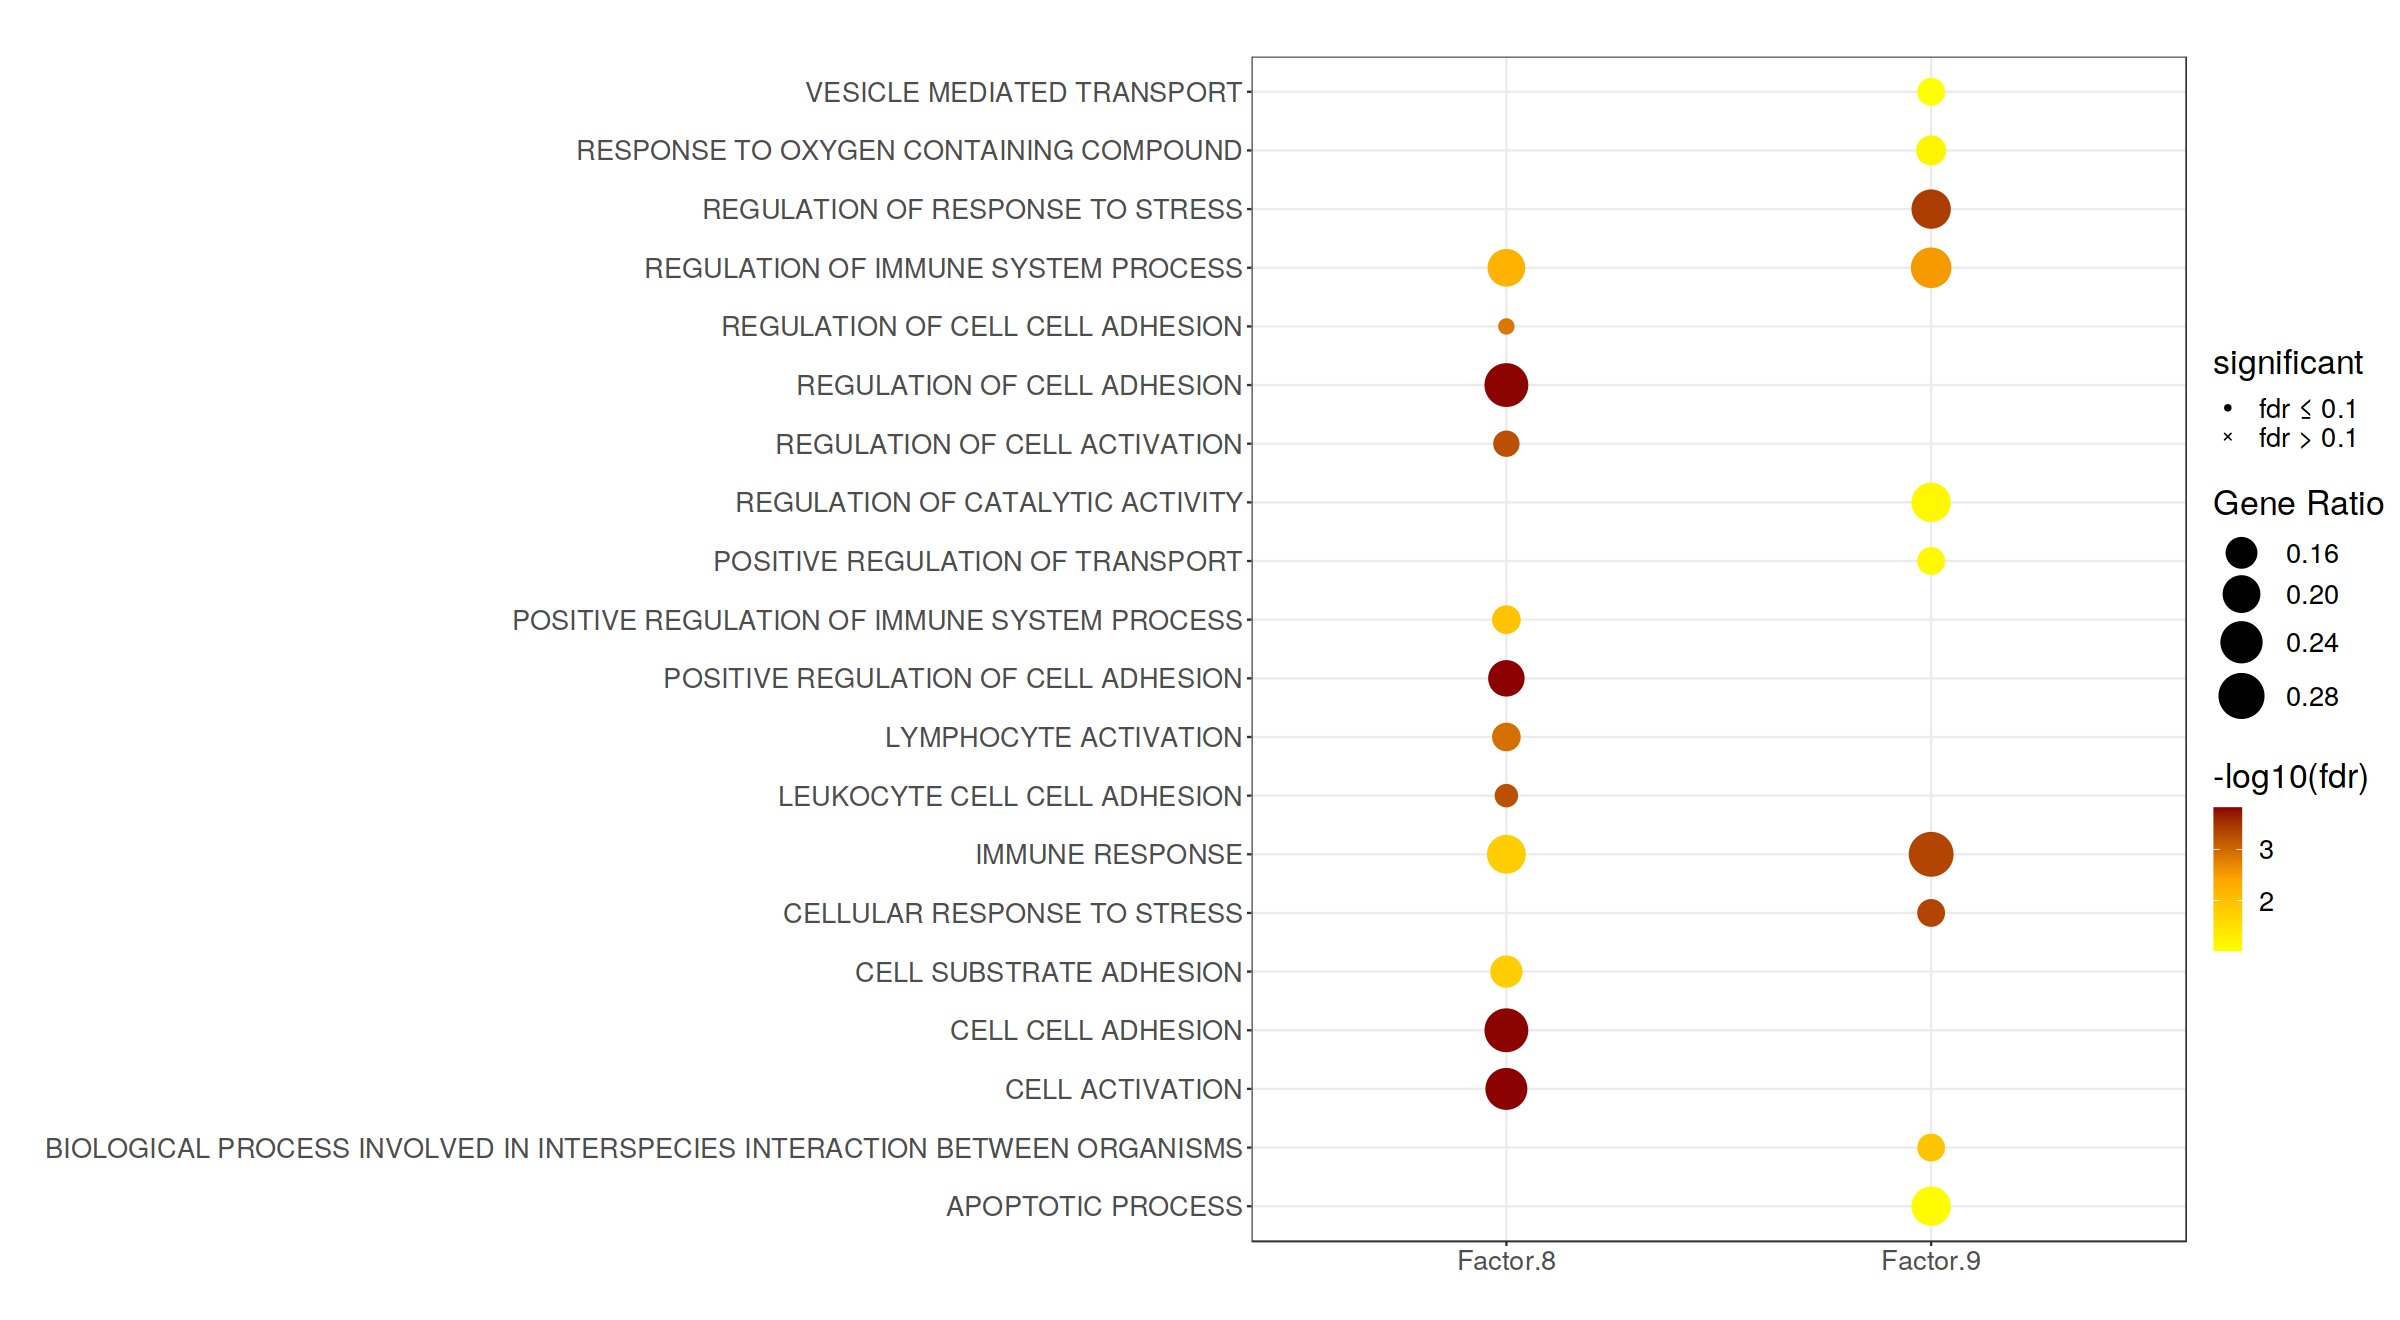

In [645]:
h_ = 11
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)
g<-visualize_ora_all(ora_res, sig.thres = 0.1, top_n_terms = 20)
g

In [665]:
write.csv(ora_res[['Factor.9']]@result[c('ID', 'geneID')], 
          paste0(data_path, 'interim/', 'factor9_', 'pathways_with_LRs.csv'))
write.csv(ora_res[['Factor.8']]@result[c('ID', 'geneID')], 
          paste0(data_path, 'interim/', 'factor8_', 'pathways_with_LRs.csv'))

Factors 8 and 3 are also complementary -- they involve similar contexts but distinct cell types. Let's see what differences there are at the LR resolution:

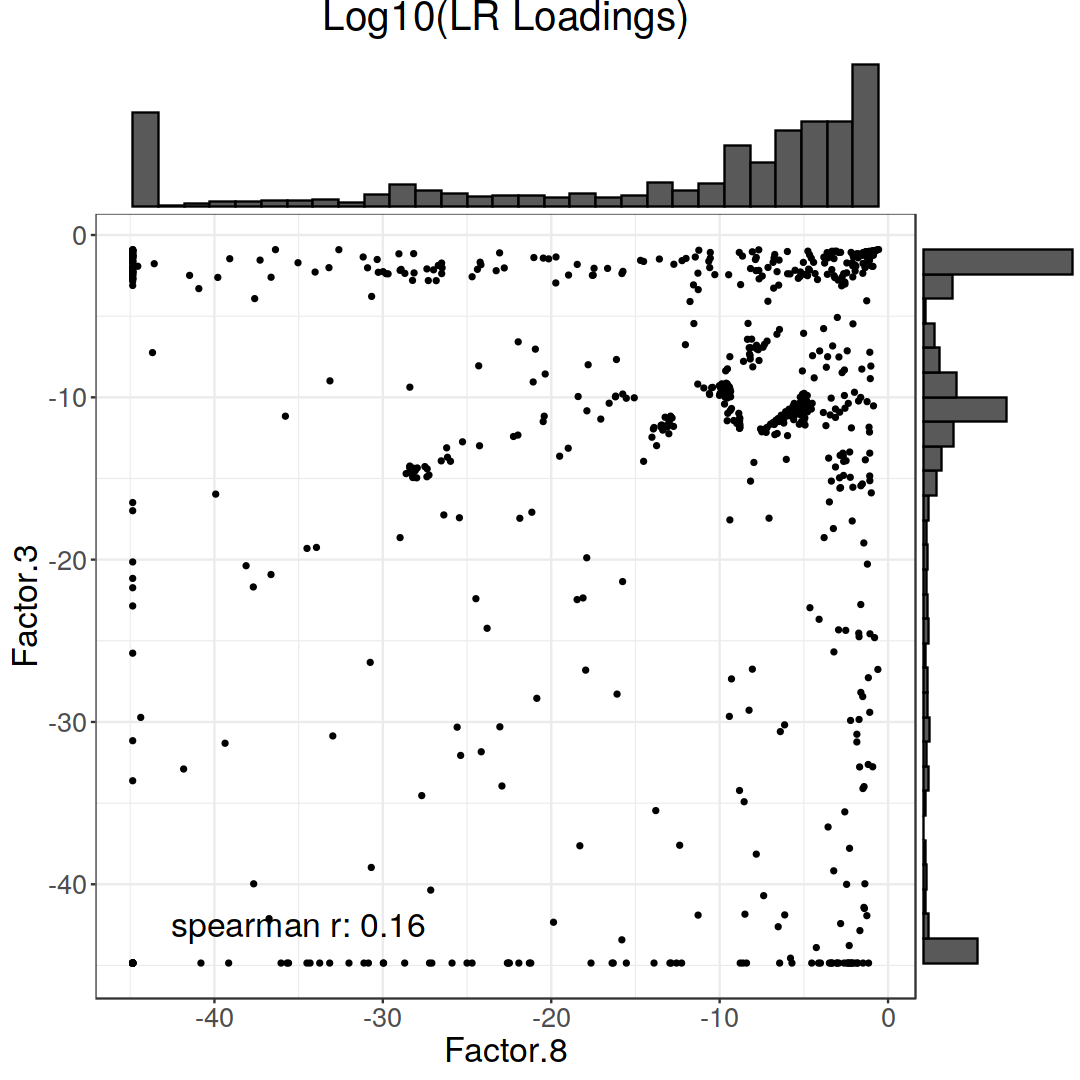

In [913]:
h_ = 9
w_ = 9
options(repr.plot.height=h_, repr.plot.width=w_)

viz.df<-factors$interactions[(c('Factor.8', 'Factor.3'))]

min_nonzero = min(viz.df[viz.df !=0]) # small psuedocount

viz.df <- log10(viz.df + min_nonzero)

spearmanr<-cor(viz.df$Factor.8, viz.df$Factor.3, method = 'spearman')
annotation <- data.frame(
   x = c(-35),
   y = c(-42.5),
   label = c((paste0('spearman r: ', format(round(spearmanr, 2), nsmall = 2))))
)

g<-ggplot(viz.df, aes(x = Factor.8, y = Factor.3)) + geom_point(size = 1, position = "jitter") + 
theme_bw() + ggtitle('Log10(LR Loadings)') + 
theme(plot.title = element_text(hjust = 0.5), text = element_text(size=20)) + 
geom_text(data=annotation, aes( x=x, y=y, label=label),
           size=7 , color = 'black')
g<-ggExtra::ggMarginal(g, type = "histogram")

g

Immediately, it is apparent that there is much less agreement b/w the loadings in Factor 8 and 3 than in Factor 8 and 9, as quantified by the spearman correlation. Let's get the factor specific LRs using the same thresholds as before: 

In [932]:
viz.df[['lr']]<-factors$interactions[['lr']]

# factor3.loadings<-as.character<-viz.df[(viz.df$Factor.3 >= -20) & (viz.df$Factor.8 <= -25), 'lr']
# factor8.loadings<-as.character<-viz.df[(viz.df$Factor.8 >= -20) & (viz.df$Factor.3 <= -15), 'lr']

factor3.loadings<-as.character<-viz.df[(viz.df$Factor.3 >= -20) & (viz.df$Factor.8 <= -25), 'lr']
factor8.loadings<-as.character<-viz.df[(viz.df$Factor.8 >= -10) & (viz.df$Factor.3 <= -10), 'lr']

print(paste0('There are ', length(factor3.loadings), ' Factor 3 specific LRs'))
print(paste0('There are ', length(factor8.loadings), ' Factor 8 specific LRs'))

[1] "There are 131 Factor 3 specific LRs"
[1] "There are 264 Factor 8 specific LRs"


The factor 3 loadings are:

In [927]:
as.character(factor3.loadings)

[1] "Adam10^Cadm1"        "Adam17^Rhbdf2"       "Adm^Ramp1"          
  [4] "Angptl2^Pirb"        "Angptl4^Cdh5"        "Angptl4^Sdc3"       
  [7] "Angptl4^Sdc4"        "Angptl7^Pirb"        "Anxa1^Egfr"         
 [10] "Apoe^Lrp8"           "Apoe^Scarb1"         "Arf1^Pld2"          
 [13] "B2m^Hfe"             "C1qb^C1qbp"          "C3^Itgam"           
 [16] "Ccl25^Ccr9"          "Ccl4^Ccr5"           "Cd200r1^Cd200"      
 [19] "Cd47^Sirpa"          "Cd48^Cd244"          "Cd70^Tnfrsf13b"     
 [22] "Cdh1^Egfr"           "Cdh1^Erbb3"          "Cdh1^Igf1r"         
 [25] "Cdh1^Ptprf"          "Ceacam1^Egfr"        "Col9a3^Cd44"        
 [28] "Col9a3^Itga1_Itgb1"  "Col9a3^Itga2_Itgb1"  "Copa^P2ry6"         
 [31] "Csf1^Csf2ra"         "Csf1^Sirpa"          "Cxcl10^Sdc4"        
 [34] "Dll1^Notch4"         "Efna2^Epha2"         "Efnb2^Rhbdl2"       
 [37] "Egf^Erbb3"           "Egf^Rhbdl2"          "Fam3c^Lifr"         
 [40] "Fgf13^Egfr"          "Fgf13^Fgfr1"         "Fgf2^Sdc4"          
 [43] "Flt3l^Flt3"          "Fn1^Cd44"            "Fn1^Cd79a"          
 [46] "Fn1^Plaur"           "Gdf11^Acvr1b_Acvr2a" "Gdf11^Acvr2a_Tgfbr1"
 [49] "Gdf11^Acvr2b_Tgfbr1" "Gnai2^Egfr"          "Gnai2^P2ry12"       
 [52] "Gnai2^S1pr3"         "Grn^Egfr"            "Grn^Sort1"          
 [55] "Gstp1^Egfr"          "H2-Ob^Cd4"           "Hdc^Hrh2"           
 [58] "Hras^Insr"           "Hras^Tlr9"           "Hsp90aa1^Egfr"      
 [61] "Hsp90b1^Tlr9"        "Icam1^Egfr"          "Igfbp4^Lrp6"        
 [64] "Il10^Cd70"           "Il18^Il1rl2"         "Irak4^Tlr7"         
 [67] "Jag1^Notch2"         "Lamb3^Dag1"          "Lamc1^Dag1"         
 [70] "Lefty1^Acvr2a"       "Lefty1^Acvr2b"       "Lman1^Mcfd2"        
 [73] "Lrpap1^Ldlr"         "Lrpap1^Lrp8"         "Lrpap1^Sort1"       
 [76] "Lta_Ltb^Ltbr"        "Ly86^Cd180"          "Mdk^Notch2"         
 [79] "Mdk^Sdc3"            "Mdk^Sdc4"            "Mif^Egfr"           
 [82] "Mmp9^Ephb2"          "Mmp9^Reck"           "Mmp9^Tlr9"          
 [85] "Ntrk3^Ptprf"         "Ntrk3^Ptprs"         "Osm^Il6st_Lifr"     
 [88] "Plat^Itgam"          "Psap^Sort1"          "Psen1^Notch3"       
 [91] "Ptdss1^Scarb1"       "Ptpn6^Cd300lf"       "Ptpn6^Clec12a"      
 [94] "Ptpn6^Egfr"          "Qrfp^P2ry14"         "S100a1^Ager"        
 [97] "S100a4^Egfr"         "S100a8^Cd36"         "S100a8^Cd68"        
[100] "S100a9^Ager"         "S100a9^Cd68"         "Sdc2^Ptprj"         
[103] "Sema4a^Plxnb2"       "Sema4c^Plxnb2"       "Sema4d^Plxnb2"      
[106] "Serpinf1^Plxdc1"     "Spon1^App"           "Spon1^Lrp8"         
[109] "St6gal1^Egfr"        "Tfpi^Sdc4"           "Tgfb1^Acvrl1"       
[112] "Tgfb1^Egfr"          "Tgfb1^Sdc2"          "Tgm2^Sdc4"          
[115] "Thbs4^Cd36"          "Thbs4^Itgav_Itgb3"   "Tnf^Ptprs"          
[118] "Tnf^Sema4c"          "Tnf^Tnfrsf1a"        "Tnf^Trpm2"          
[121] "Tnfsf12^Cd163"       "Tnfsf13b^Tfrc"       "Tnfsf13b^Tnfrsf13b" 
[124] "Trf^Hfe"             "Trf^Ldlr"            "Trf^Tfrc"           
[127] "Vcam1^Itgad_Itgb2"   "Vwf^Itga4"           "Vwf^Sirpa"          
[130] "a^Atrn"              "a^Mgrn1"

The factor 8 loadings are:

In [928]:
as.character(factor8.loadings)

[1] "Ada^Dpp4"                "Adam10^Axl"             
  [3] "Adam10^Tspan5"           "Adam15^Itgb1"           
  [5] "Adam17^Itga5"            "Adam9^Itga6"            
  [7] "Adam9^Itgb1"             "Agrn^Itgb1"             
  [9] "Alcam^Cd6"               "Angptl2^Itga5_Itgb1"    
 [11] "Anxa2^Tlr2"              "App^Aplp2"              
 [13] "App^Ptger2"              "B2m^Klrc1"              
 [15] "Bsg^Slc16a1"             "Btla^Cd247"             
 [17] "Calr^Scarf1"             "Ccl17^Ccr4"             
 [19] "Ccl22^Ccr4"              "Ccl5^Ccr4"              
 [21] "Ccl5^Ccrl2"              "Cd274^Pdcd1"            
 [23] "Cd28^Cd80"               "Cd40lg^Cd9"             
 [25] "Cd40lg^Itga5_Itgb1"      "Cd40lg^Itgam_Itgb2"     
 [27] "Cd70^Cd27"               "Cd72^Cd5"               
 [29] "Cd80^Cd28"               "Cd80^Ctla4"             
 [31] "Cd86^Cd28"               "Cd86^Ctla4"             
 [33] "Cdh1^Itga2_Itgb1"        "Cdh1^Klrg1"             
 [35] "Ceacam1^Havcr2"          "Cklf^Ccr4"              
 [37] "Clec11a^Itgb1"           "Col27a1^Itga1_Itgb1"    
 [39] "Col27a1^Itga2_Itgb1"     "Cxcl16^Cxcr6"           
 [41] "Efnb2^Pecam1"            "Egf^Nrp1"               
 [43] "Entpd1^Adora2a"          "Fabp5^Rxra"             
 [45] "Fadd^Traf2"              "Fam3c^Pdcd1"            
 [47] "Fasl^Tnfrsf1a"           "Fn1^Dpp4"               
 [49] "Fn1^Itga4_Itgb1"         "Fn1^Itgav_Itgb1"        
 [51] "Fndc5^Itgav"             "Gnai2^F2r"              
 [53] "Gnas^Vipr1"              "Grn^Tnfrsf1b"           
 [55] "Gzma^F2r"                "Gzma^F2rl1"             
 [57] "Gzma^F2rl2"              "Gzma^F2rl3"             
 [59] "H2-M3^Klrc1"             "Has2^Hmmr"              
 [61] "Hsp90b1^Tlr2"            "Hspa1a^Grin2d"          
 [63] "Icam1^Il2ra"             "Icam2^Itgam_Itgb2"      
 [65] "Icosl^Cd28"              "Icosl^Ctla4"            
 [67] "Icosl^Icos"              "Il15^Il15ra_Il2rb_Il2rg"
 [69] "Il15^Il2ra"              "Il15ra^Axl"             
 [71] "Il18^Il18r1_Il18rap"     "Il1b^Sigirr"            
 [73] "Il2^Il2ra_Il2rb_Il2rg"   "Il2^Il2rb_Il2rg"        
 [75] "L1cam^Cd9"               "L1cam^Itgav_Itgb3"      
 [77] "Lamb3^Itga2_Itgb1"       "Lamb3^Itga6_Itgb1"      
 [79] "Lamb3^Itga6_Itgb4"       "Lamb3^Itgav_Itgb8"      
 [81] "Lamc1^Itga2_Itgb1"       "Lamc1^Itga6_Itgb1"      
 [83] "Lta^Tnfrsf1b"            "Mdk^Itga6_Itgb1"        
 [85] "Mfge8^Itgav"             "Mtmr4^Smad3"            
 [87] "Nampt^Adora2a"           "Nampt^Itga5_Itgb1"      
 [89] "P4hb^Mttp"               "Pdcd1lg2^Pdcd1"         
 [91] "Pdgfb^S1pr1"             "Psap^Ar"                
 [93] "Psap^Celsr1"             "Ptdss1^Jmjd6"           
 [95] "Rtn4^S1pr2"              "Rtn4^Tnfrsf19"          
 [97] "Sema7a^Itga1_Itgb1"      "Sema7a^Plxnc1"          
 [99] "Sertad1^Ar"              "Slpi^Plscr1"            
[101] "Spint1^St14"             "Spp1^Itga8_Itgb1"       
[103] "Spp1^Itgav_Itgb1"        "Spp1^Itgav_Itgb3"       
[105] "Spp1^S1pr1"              "St6gal1^Cd22"           
[107] "Tgfb1^Itgb8"             "Tgfb1^Tgfbr3"           
[109] "Tgs1^Rxra"               "Tnf^Ffar2"              
[111] "Tnf^Icos"                "Tnfsf10^Ccr6"           
[113] "Tnfsf12^Tnfrsf25"        "Tnfsf14^Ltbr"           
[115] "Tnfsf4^Tnfrsf4"          "Tnfsf8^Tnfrsf8"         
[117] "Wnt10a^Fzd5_Lrp6"

In [933]:
# run ORA on top LRs per factor
factor.list<-list(Factor.8 = factor8.loadings, Factor.3 = factor3.loadings)

ora_res<-list()
for (factor.name in names(factor.list)){
    factor_lrs <- factor.list[[factor.name]]
    if (length(setdiff(factor_lrs, lr_list)) > 0){
        stop('Unexpected LRs in loadings')
    }
    
    # if universe argument is not set, all the LRs in ora_db (which is all the LRs from the DB that mapped
    # to a pathway) will be used
    cp.out<-clusterProfiler::enricher(factor_lrs, TERM2GENE = ora_db, 
                                                     pAdjustMethod = 'BH', 
                                                      pvalueCutoff = 1, # will filter later
                                                      qvalueCutoff = 1
                                                     )
    tr = 'ADAPTIVE IMMUNE RESPONSE BASED ON SOMATIC RECOMBINATION OF IMMUNE RECEPTORS BUILT FROM IMMUNOGLOBULIN SUPERFAMILY DOMAINS'
    cp.out@result[cp.out@result$ID == tr, 'ID'] = 'ADAPTIVE IMMUNE RESPONSE (SOMATIC RECOMBINATION)'
    ora_res[[factor.name]]<-cp.out

}


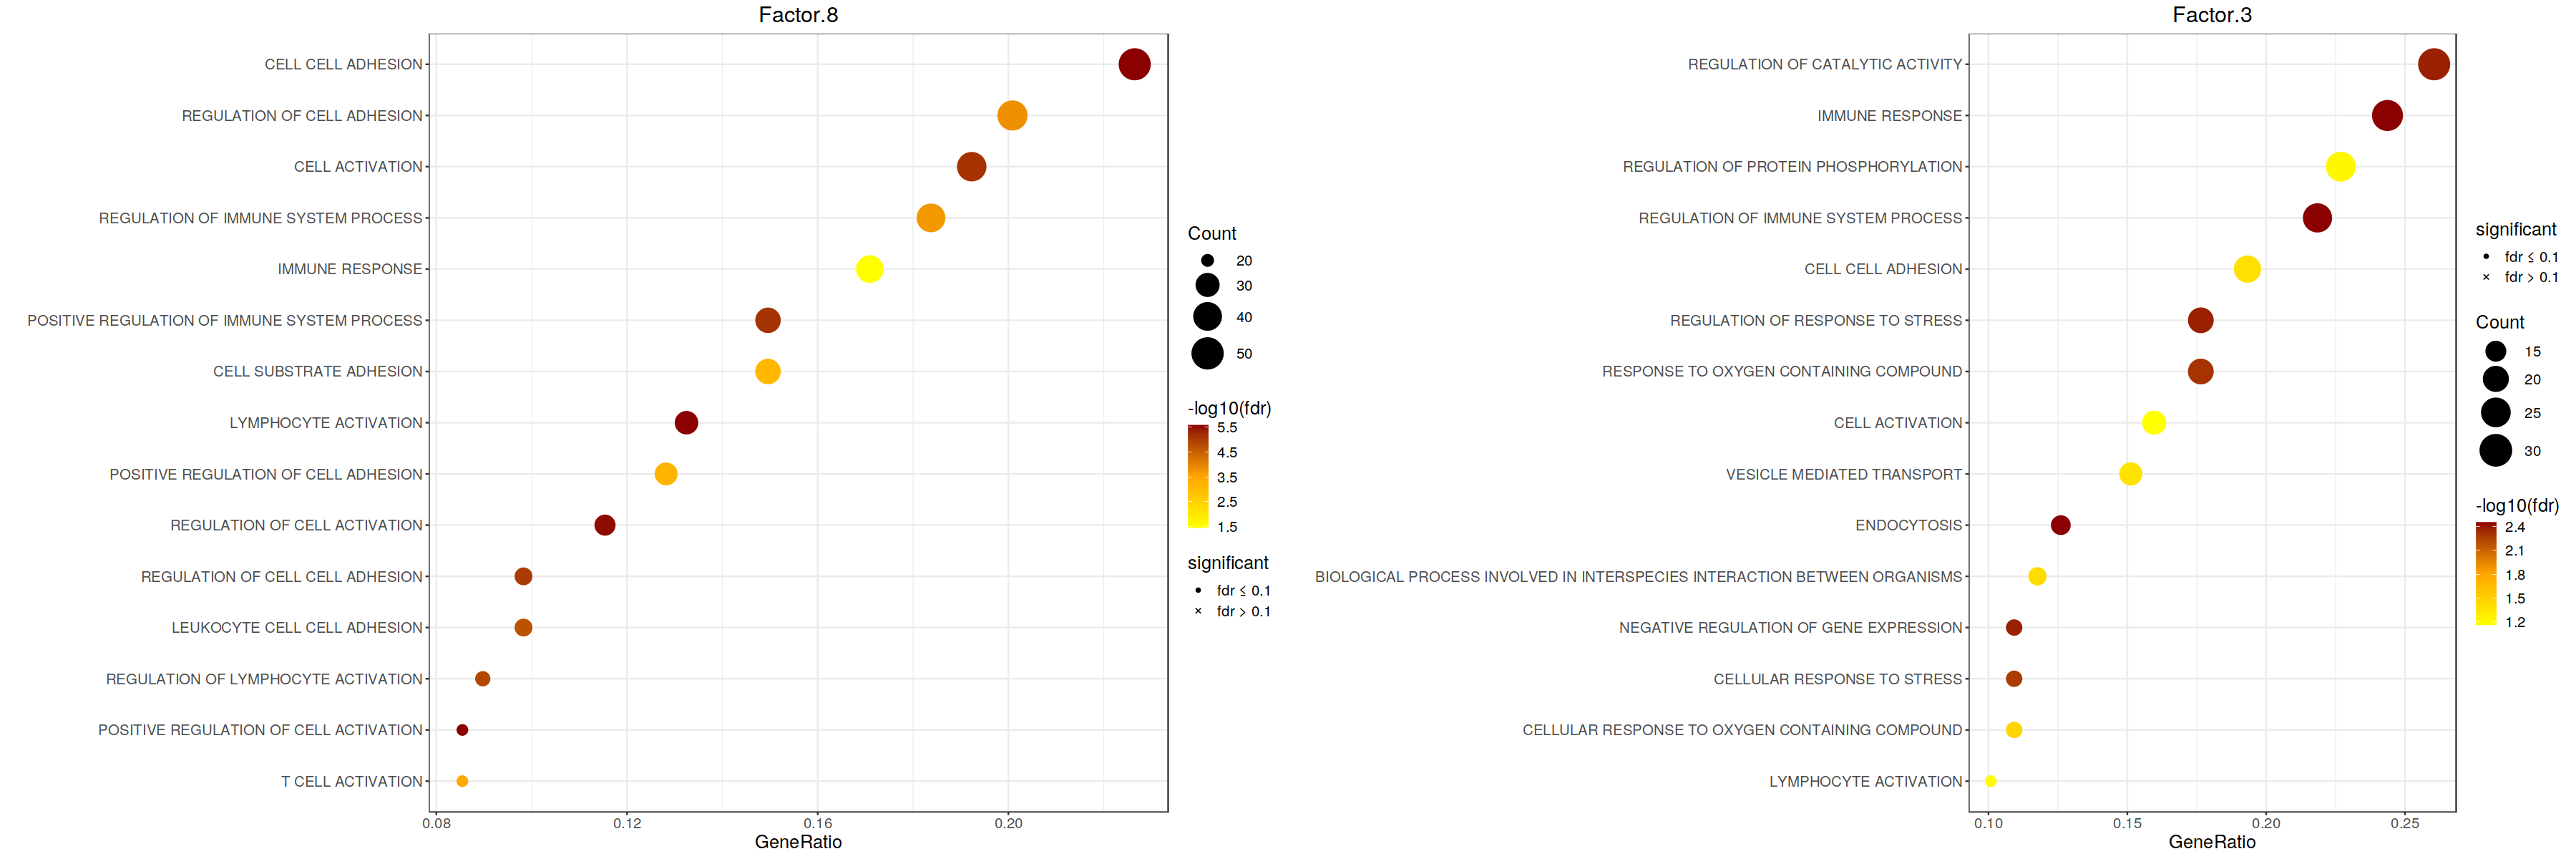

In [935]:
w_ = 30
h_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)


# visualize
dotplot_list<-c()
for (fn in names(ora_res)){
    cp.out<-ora_res[[fn]]
    g<-visualize_ora(cp.out, fn, top_n_terms = 15)
    
    dotplot_list[[fn]]<-g

}

suppressWarnings({
    g<-cowplot::plot_grid(dotplot_list[[1]], dotplot_list[[2]],
                   ncol = 2)
})

g

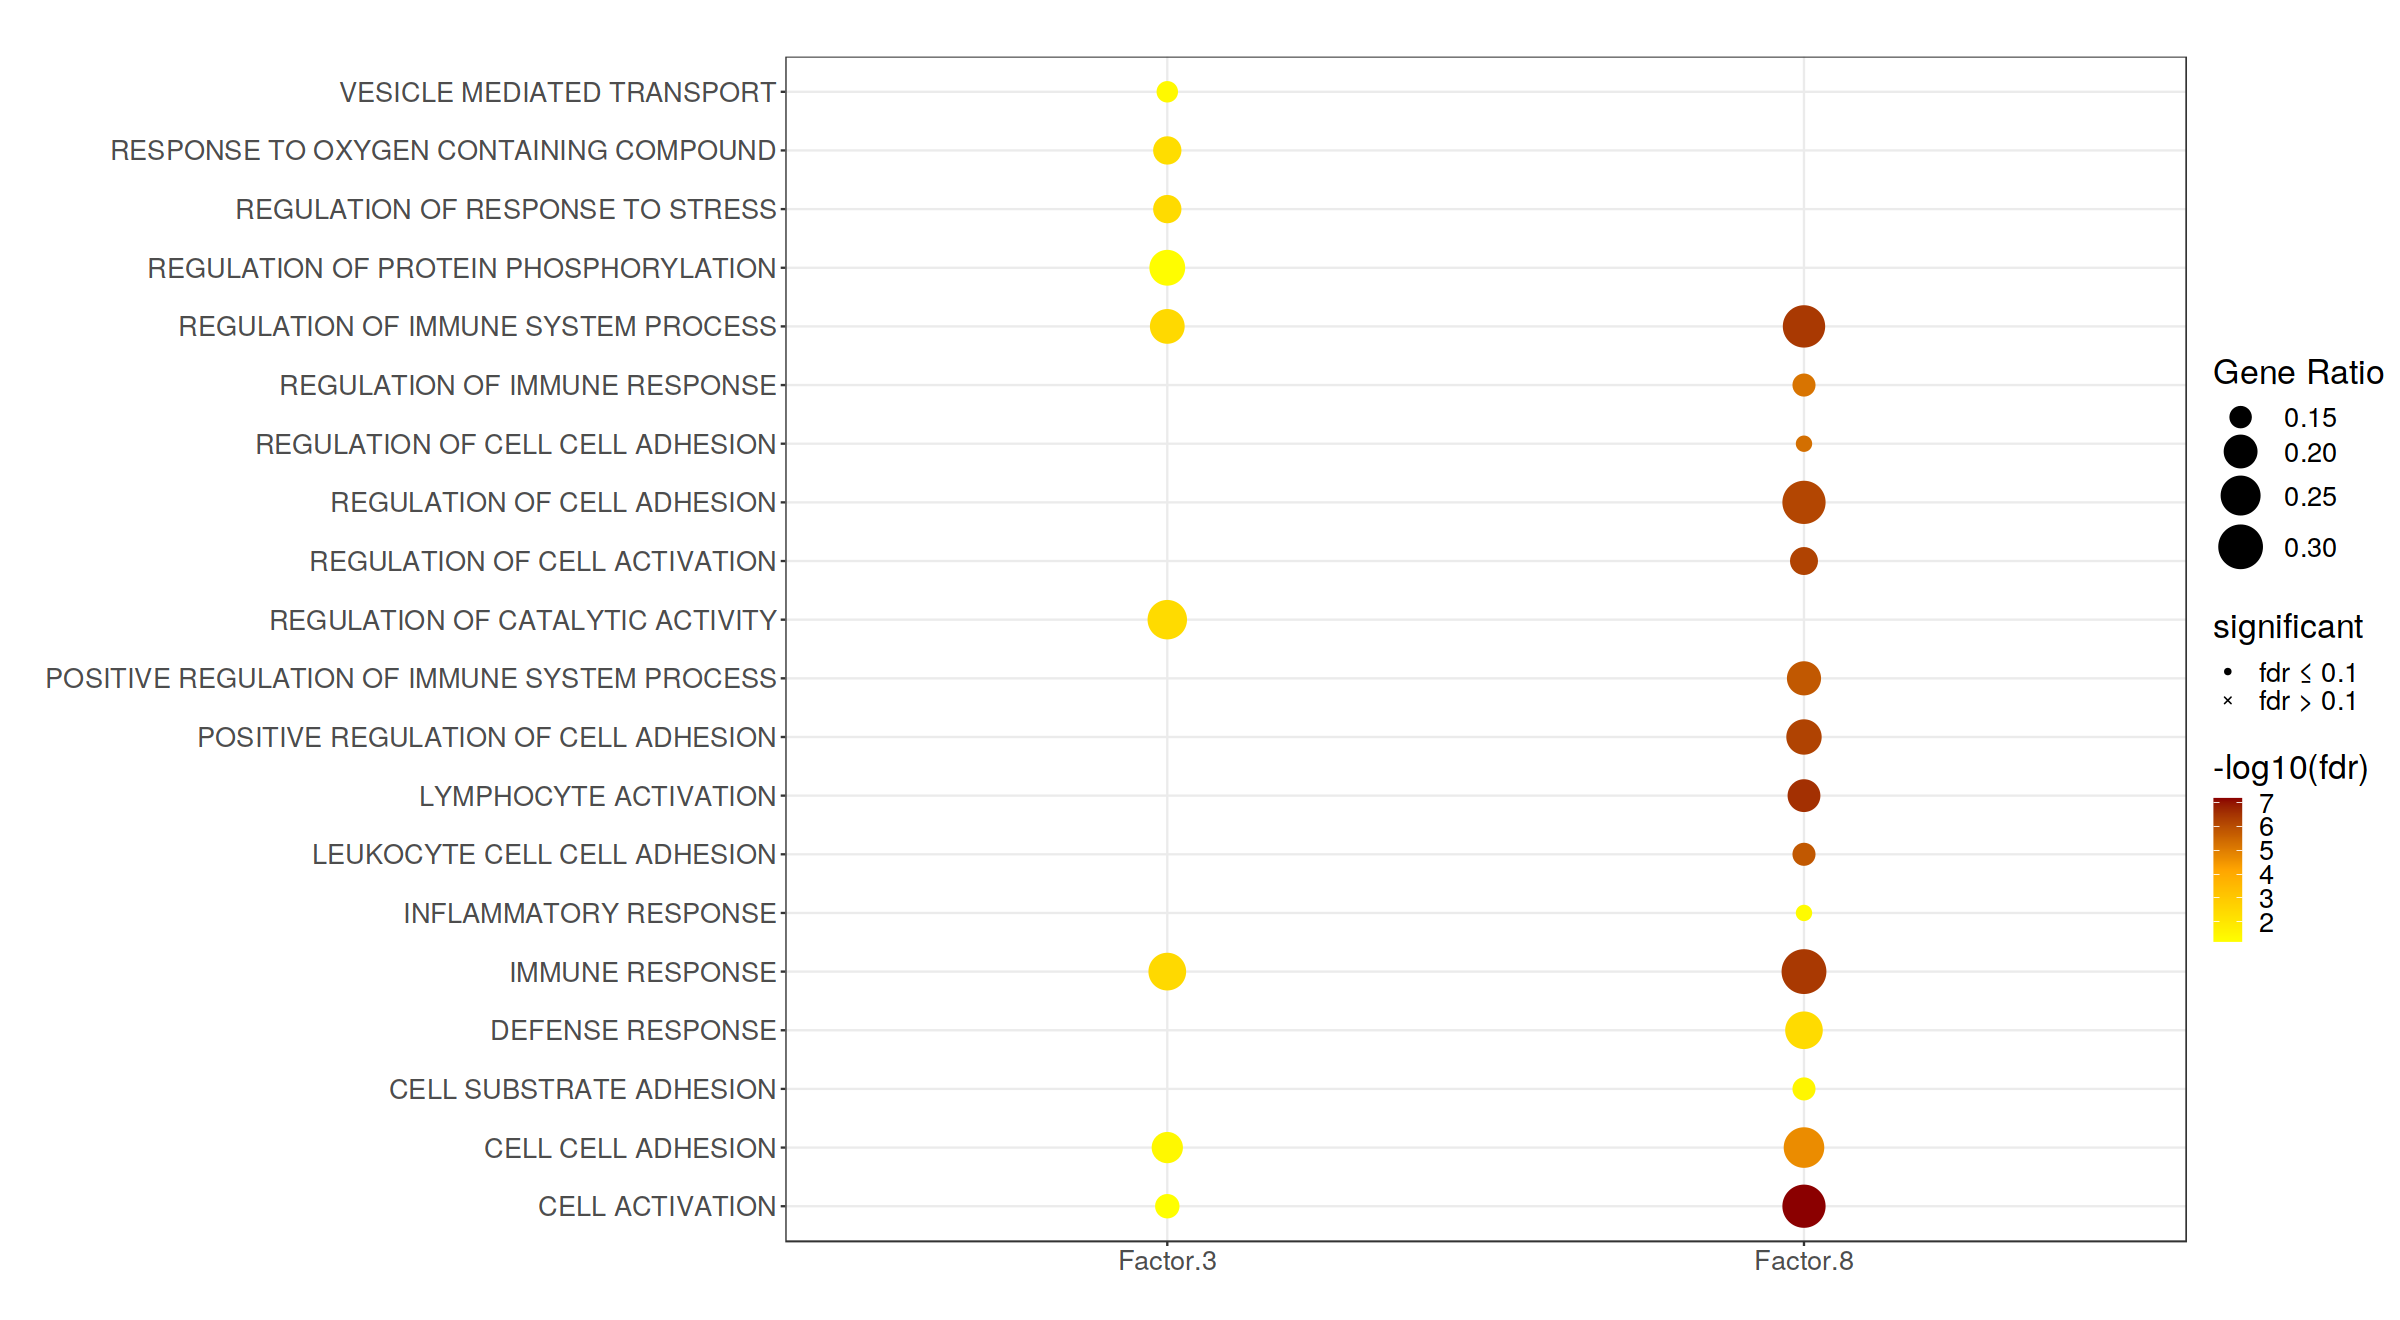

In [931]:
h_ = 11
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)
g<-visualize_ora_all(ora_res, sig.thres = 0.1, top_n_terms = 20)
g

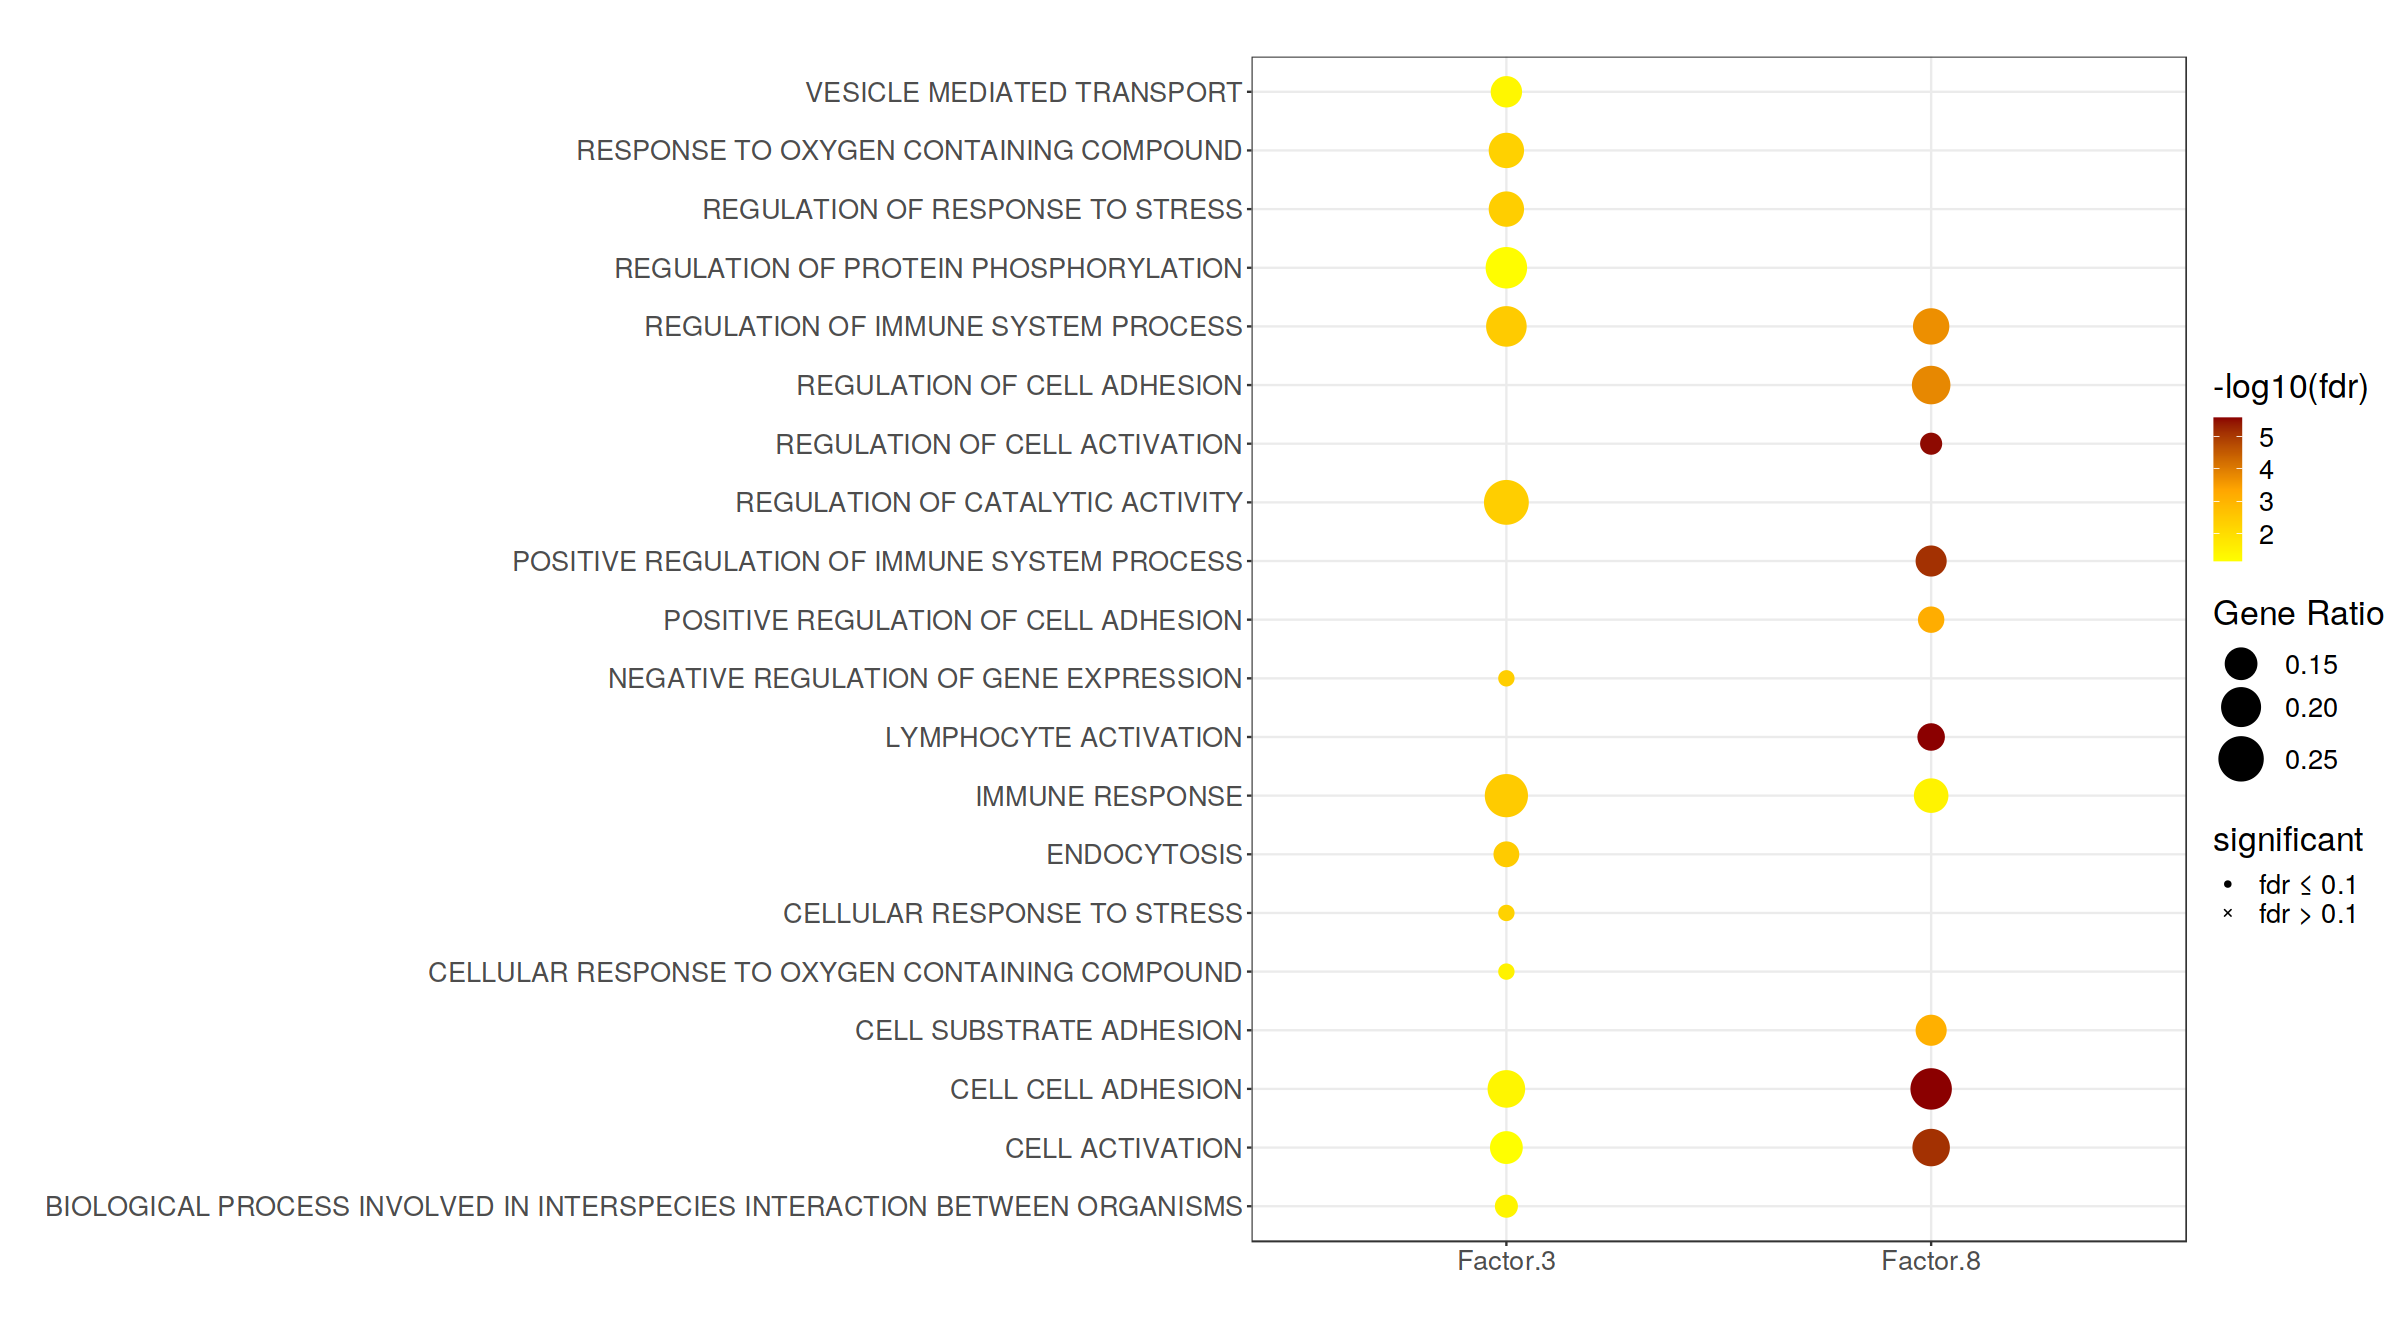

In [934]:
h_ = 11
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)
g<-visualize_ora_all(ora_res, sig.thres = 0.1, top_n_terms = 20)
g

In [952]:
write.csv(ora_res[['Factor.3']]@result[c('ID', 'geneID')], 
          paste0(data_path, 'interim/', 'factor3_', 'pathways_with_LRs.csv'))
write.csv(ora_res[['Factor.8']]@result[c('ID', 'geneID')], 
          paste0(data_path, 'interim/', 'factor8relto3_', 'pathways_with_LRs.csv'))heatmap

In [943]:
viz_df<-factors$interactions[c('lr', 'Factor.3', 'Factor.8', 'Factor.9')]
rownames(viz_df)<-viz_df$lr
viz_df<-as.matrix(viz_df[c('Factor.3', 'Factor.8', 'Factor.9')])

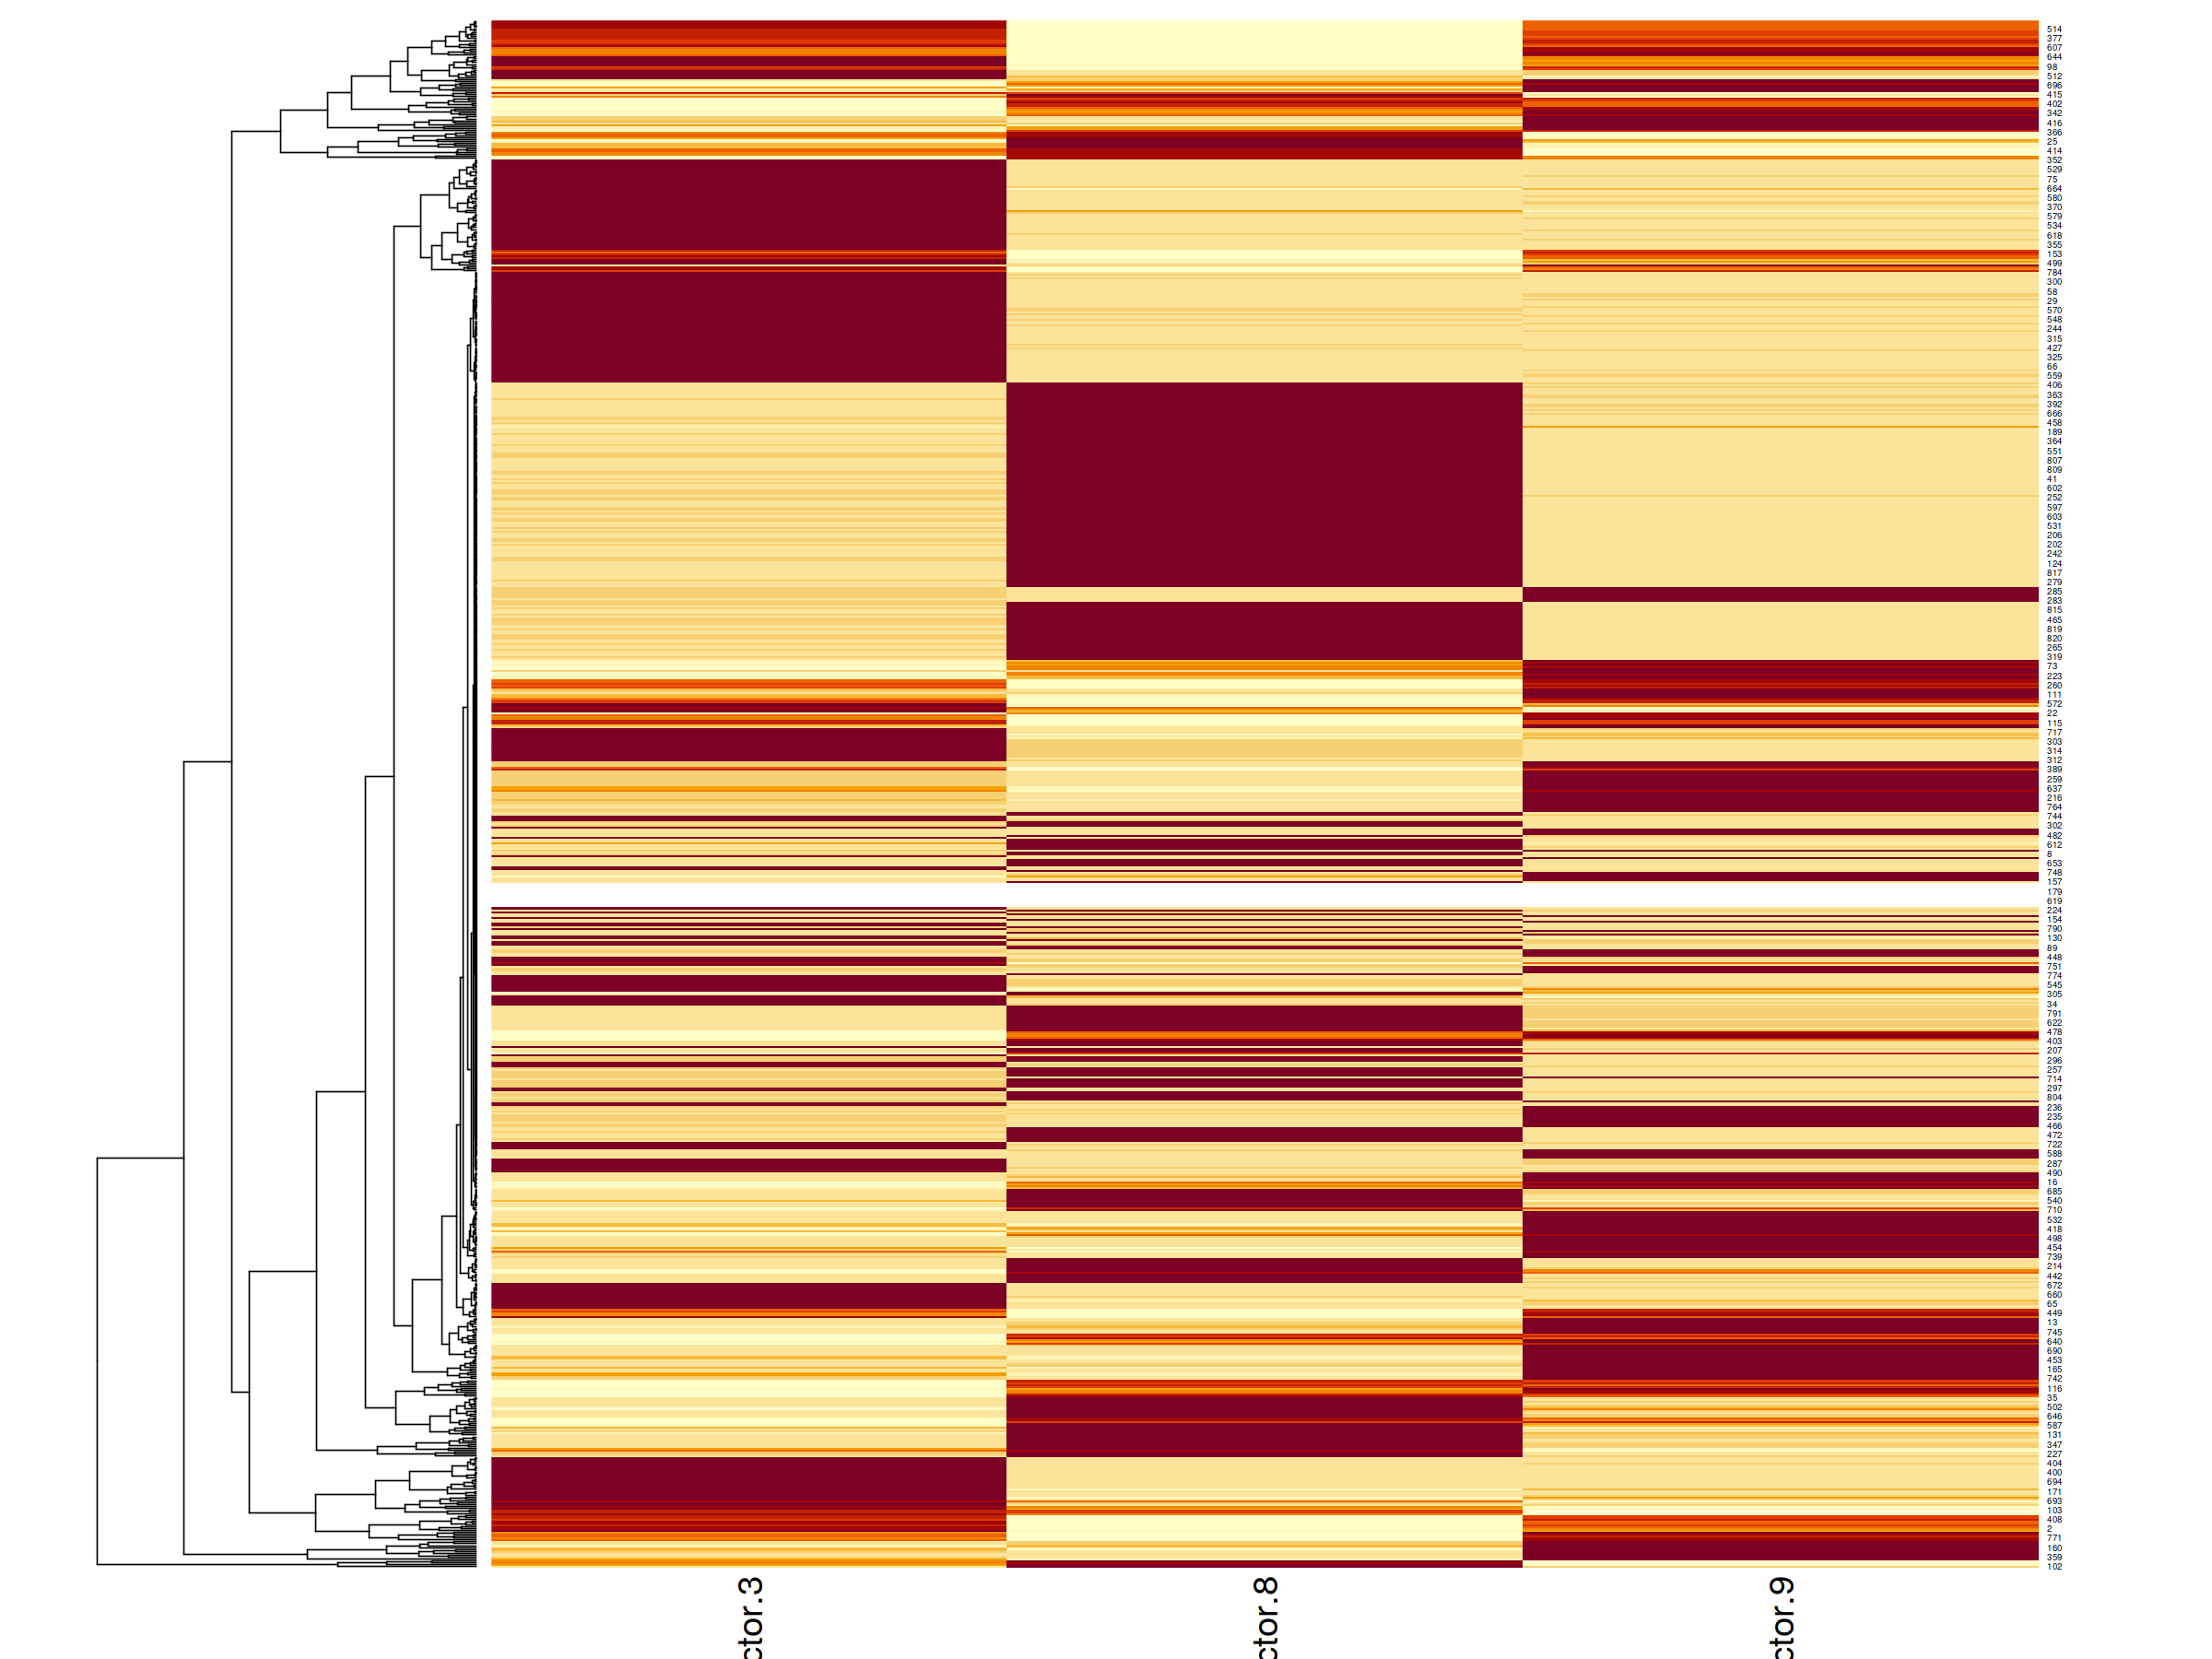

In [951]:
h_ = 15
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)
heatmap(viz_df, Colv = NA)